In [2]:
import numpy as np
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import DigitalAnalogDevice
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import time

# Helper functions

### Plot the distribution of the results

In [3]:
# helper function
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5)
    plt.xticks(rotation="vertical")
    plt.show()

### Function to generate the pascal triangle coordinates

In [4]:
def generate_pascal_triangle_coords(num_atoms, min_distance=4.0):
    """
    Generate coordinates in a Pascal Triangle layout.

    Args:
        num_atoms (int): Total number of atoms. 
                         Values 1, 3, 6, 10, or 11/12 supported (extra atoms added reasonably).
        min_distance (float): Minimum spacing between atoms.

    Returns:
        coords (np.ndarray): Array of shape (n, 2) with 2D coordinates.
    """
    triangle_numbers = {1, 3, 6, 10}
    coords = []
    h = min_distance * np.sqrt(3) / 2  # Vertical spacing for equilateral triangle

    # Handle exact triangle numbers
    if num_atoms in triangle_numbers:
        n = int((np.sqrt(8 * num_atoms + 1) - 1) / 2)
        for row in range(n):
            num_in_row = row + 1
            x_offset = - (num_in_row - 1) * min_distance / 2
            y = -row * h
            for i in range(num_in_row):
                x = x_offset + i * min_distance
                coords.append((x, y))

    elif num_atoms == 11:
        # 10 from full triangle + 1 at center bottom
        coords = generate_pascal_triangle_coords(10, min_distance).tolist()
        coords.append((0.0, -4 * h))  # Add one atom center bottom

    elif num_atoms == 12:
        # 10 from full triangle + 1 left-bottom + 1 right-bottom
        coords = generate_pascal_triangle_coords(10, min_distance).tolist()
        coords.append((-min_distance, -4 * h))  # Left of bottom row
        coords.append((min_distance, -4 * h))   # Right of bottom row

    else:
        raise ValueError("Only supports 1, 3, 6, 10, 11, or 12 atoms for Pascal triangle layout.")

    return np.array(coords)

### Generate a QUBO matrix from a set of coordinates

In [67]:
def coordinates_to_Q(coords, C6=DigitalAnalogDevice.interaction_coeff, diag_val=-10.0):
    """
    Given a list of 2D coordinates, return a QUBO matrix Q.
    
    Args:
        coords: np.array of shape (n, 2)
        C6: interaction coefficient (default in Hz·μm⁶)
        diag_val: value to set for diagonal elements

    Returns:
        Q matrix (n x n)
    """
    coords = np.array(coords)
    distances = squareform(pdist(coords))  # Shape (n, n)
    with np.errstate(divide='ignore'):
        interaction = np.where(distances != 0, C6 / distances**6, 0.0)

    Q = interaction.copy()
    np.fill_diagonal(Q, diag_val)
    return Q

### QAOA optimisation helper functions

In [68]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

# Lets get the register position from the QUBO :

In [69]:
coords = generate_pascal_triangle_coords(12, min_distance=5.0)
Q = coordinates_to_Q(coords)

#### Find optimal bitstring from Q classically

In [70]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
classic_costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    classic_costs.append(cost)
zipped = zip(bitstrings, classic_costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('100000100100', -27.14493707061728), ('100000000110', -26.709843995863842), ('100000100001', -26.709843995863842)]


In [71]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)
costs = []
np.random.seed(0)
x0 = coords.flatten() # np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))


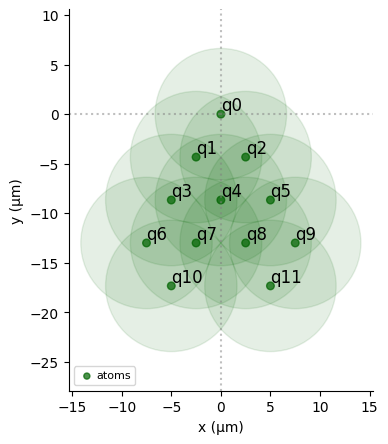

In [72]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

# Lets now do QAA and find the state that minimize our QUBO

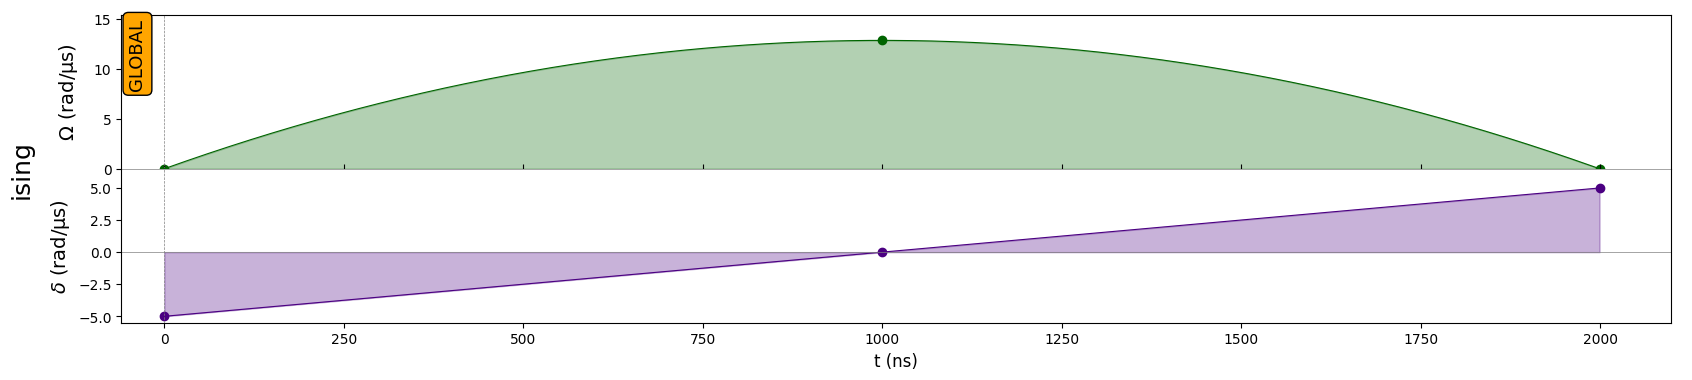

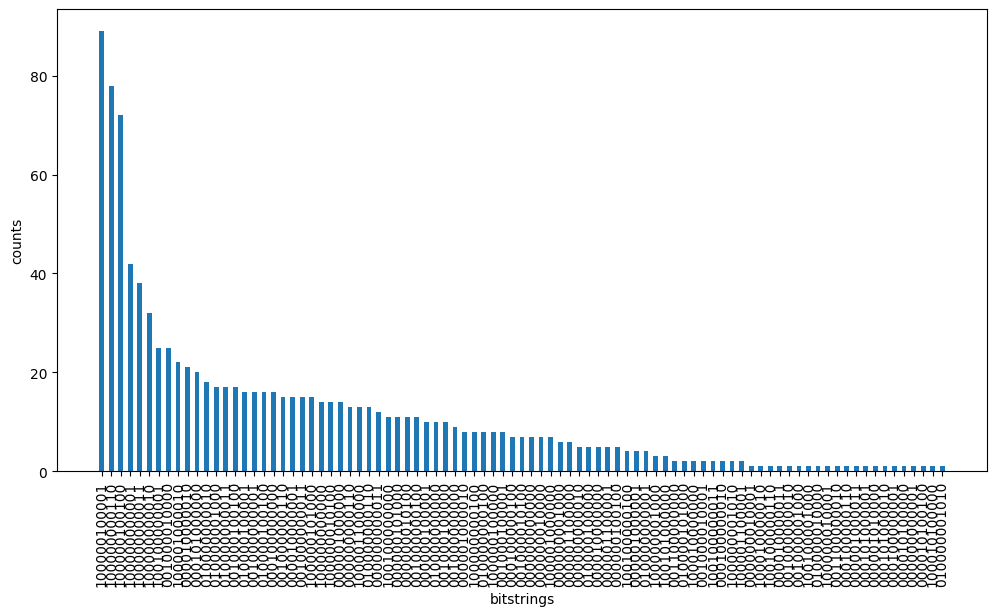

energy : -16.58050641432214


In [74]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 2000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
sequence_QAA = Sequence(reg, DigitalAnalogDevice)
sequence_QAA.declare_channel("ising", "rydberg_global")
sequence_QAA.add(adiabatic_pulse, "ising")
sequence_QAA.draw()
simul_QAA = QutipEmulator.from_sequence(sequence_QAA)
results_QAA = simul_QAA.run()
final_QAA = results_QAA.get_final_state()
count_dict_QAA = results_QAA.sample_final_state()
plot_distribution(count_dict_QAA)
print(f"energy : {get_cost(count_dict_QAA, Q)}")

# Saving sequence to json to be imported into pulser studio

In [75]:
s_readable = sequence_QAA.to_abstract_repr(
json_dumps_options={"indent": 1},
seq_name=f"qaa_seq_{time.time()}",
)
with open(f"QAA_{time.time()}.json", "w") as f:
    f.write(s_readable)

# Lets now use QAOA to find the state that minimize our QUBO

#### Unfortunately, the time it takes to optimise this, even with 1 repetition, takes too much time with 12 atoms.
we did get a result from this, but the optimizer did not converge; it only had 1 repetition

In [ ]:
LAYERS = 2
# The cost function to minimize
def func(param, *args):
    Q = args[0]
    sequence_QAOA = args[1]
    C = quantum_loop(param,sequence_QAOA)
    cost = get_cost(C, Q)
    return cost

# The function that runs the quantum loop
# This function is called by the optimizer to evaluate the cost function
def quantum_loop(parameters,sequence_QAOA,save=False):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = sequence_QAOA.build(t_list=t_params, s_list=s_params)
    if save:
        s_readable = assigned_seq.to_abstract_repr(
        json_dumps_options={"indent": 1},
        seq_name="qaoa_seq",
        )
        with open(f"QAOA_{time.time()}.json", "w") as f:
            f.write(s_readable)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

# Parametrized sequence
sequence_QAOA = Sequence(reg, DigitalAnalogDevice)
sequence_QAOA.declare_channel("ch0", "rydberg_global")

t_list = sequence_QAOA.declare_variable("t_list", size=LAYERS)
s_list = sequence_QAOA.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    sequence_QAOA.add(pulse_1, "ch0")
    sequence_QAOA.add(pulse_2, "ch0")

sequence_QAOA.measure("ground-rydberg")

scores_QAOA = []
params = []
for repetition in range(1):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=(Q, sequence_QAOA),
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 5},
        )
        scores_QAOA.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass
    print(f"Repetition {repetition} done.")

optimal_count_dict = quantum_loop(params[np.argmin(scores_QAOA)],sequence_QAOA)
plot_distribution(optimal_count_dict)

Repetition 0 done.


TypeError: quantum_loop() missing 1 required positional argument: 'sequence_QAOA'

In [47]:
scores_QAOA

[15636.954793541321]

In [50]:
params

[array([8.34771442, 2.4946938 , 8.45550597, 1.52766153])]

In [54]:
# save the sequence with the best parameters
index = np.argmin(scores_QAOA)
best_params = params[index]
quantum_loop(best_params, sequence_QAOA, save=True)

Counter({'111111111111': 1000})

In [ ]:
# QAA cost of optimized results : 
qaa_cost = get_cost(count_dict_QAA, Q)
print(f"Mninimal energy found using QAA method : {qaa_cost}")

# QAOA cost of optimized results :
qaoa_cost = func(best_params, Q, sequence_QAOA)
print(f"Mninimal energy found using QAOA method : {qaoa_cost}")

# Classical cost of Q :
print(f"Minimal energy found using classical methods : {sort_zipped[:1]}")

Cost using QAA method : -16.449517468128704
Cost using QAOA method : 15636.954793541321
[('100000100100', -27.14493707061728)]


# Study of chaotic system on pasqal technology 

In [115]:
import numpy as np

def generate_grid_clustered_graph(grid_size=8, clustering=3, radius=1,
                                  total_atoms=12, min_distance=5.0,
                                  max_distance=50.0, minimal_capacity=0.2):
    np.random.seed(0)
    positions = []

    def is_within_bounds(x, y):
        return 1 <= x <= grid_size and 1 <= y <= grid_size

    def is_valid_distance(candidate, others):
        distances = [np.linalg.norm(candidate - p) for p in others]
        return all(min_distance <= d <= max_distance for d in distances)

    # CASE 1: Clustering enabled
    if clustering > 0:
        candidate_centers = [(i, j) for i in range(2, grid_size)
                                   for j in range(2, grid_size)]
        cluster_center_indices = np.random.choice(len(candidate_centers), size=clustering, replace=False)
        cluster_centers = np.array([candidate_centers[i] for i in cluster_center_indices])

        possible_cells = set()
        for center in cluster_centers:
            for dx in range(-radius, radius + 1):
                for dy in range(-radius, radius + 1):
                    x, y = center[0] + dx, center[1] + dy
                    if is_within_bounds(x, y):
                        possible_cells.add((x, y))
        possible_cells = list(possible_cells)

    else:
        cluster_centers = np.array([])  # No clusters
        possible_cells = [(i, j) for i in range(1, grid_size + 1)
                                 for j in range(1, grid_size + 1)]

    # 2. Select atom positions
    selected_cells = []
    np.random.shuffle(possible_cells)
    for cell in possible_cells:
        cell_arr = np.array(cell)
        if len(selected_cells) == 0 or is_valid_distance(cell_arr, selected_cells):
            selected_cells.append(cell_arr)
        if len(selected_cells) == total_atoms:
            break

    # If not enough, try randomly
    while len(selected_cells) < total_atoms:
        rand = np.random.randint(1, grid_size + 1, size=2)
        if is_valid_distance(rand, selected_cells):
            selected_cells.append(rand)

    positions = np.array(selected_cells, dtype=float)

    # 3. Centering and scaling
    center_offset = (grid_size + 1) / 2.0
    positions -= center_offset
    max_grid_radius = np.linalg.norm([center_offset - 1, center_offset - 1])
    scale = max_distance / max_grid_radius
    positions *= scale

    # 4. Weight and opacity
    distances = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis=-1)
    with np.errstate(divide='ignore'):
        weights = np.where(distances > 0, 1 / distances**6, 0)
    max_weight = np.max(weights)
    opacities = np.maximum(weights / max_weight, minimal_capacity)

    return positions, cluster_centers, weights

In [102]:
def find_minimum_cost_classic(Q):
    bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
    classic_costs = []
    # this takes exponential time with the dimension of the QUBO
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q @ z
        classic_costs.append(cost)
    zipped = zip(bitstrings, classic_costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])
    return sort_zipped

def find_minimum_cost_QAA(Q):
    # We choose a median value between the min and the max
    Omega = np.median(Q[Q > 0].flatten())
    delta_0 = -5  # just has to be negative
    delta_f = -delta_0  # just has to be positive
    T = 2000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    sequence_QAA = Sequence(reg, DigitalAnalogDevice)
    sequence_QAA.declare_channel("ising", "rydberg_global")
    sequence_QAA.add(adiabatic_pulse, "ising")
    #sequence_QAA.draw()
    simul_QAA = QutipEmulator.from_sequence(sequence_QAA)
    results_QAA = simul_QAA.run()
    final_QAA = results_QAA.get_final_state()
    count_dict_QAA = results_QAA.sample_final_state()
    return get_cost(count_dict_QAA, Q)

#### Generate_grid_clustered_graph generate cluster coordinates that we then transform into neutral atom in pasqal quantum computer
we use this to study the chaotic properties of pasqal's system

In [52]:
positions, cluster_centers, weight = generate_grid_clustered_graph(grid_size=8, clustering=1, radius=3,total_atoms=12, min_distance=5.0, minimal_capacity=0.2)
positions

array([[  5.05076272, -25.25381361],
       [  5.05076272,  15.15228817],
       [ 35.35533906,   5.05076272],
       [ 15.15228817, -15.15228817],
       [ 15.15228817,  -5.05076272],
       [ -5.05076272,  -5.05076272],
       [ 35.35533906,  -5.05076272],
       [ 15.15228817,  15.15228817],
       [ 35.35533906, -35.35533906],
       [ 25.25381361,   5.05076272],
       [ 25.25381361, -35.35533906],
       [ 25.25381361,  -5.05076272]])

clustering=0 radius=6



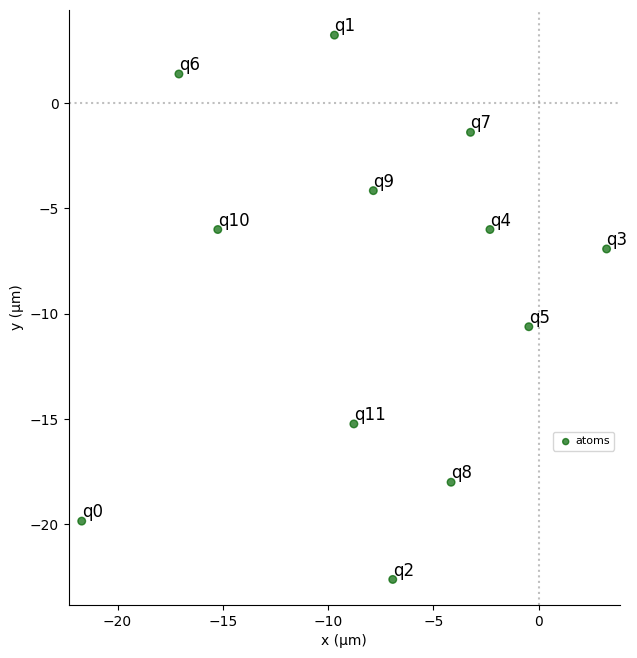

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=7



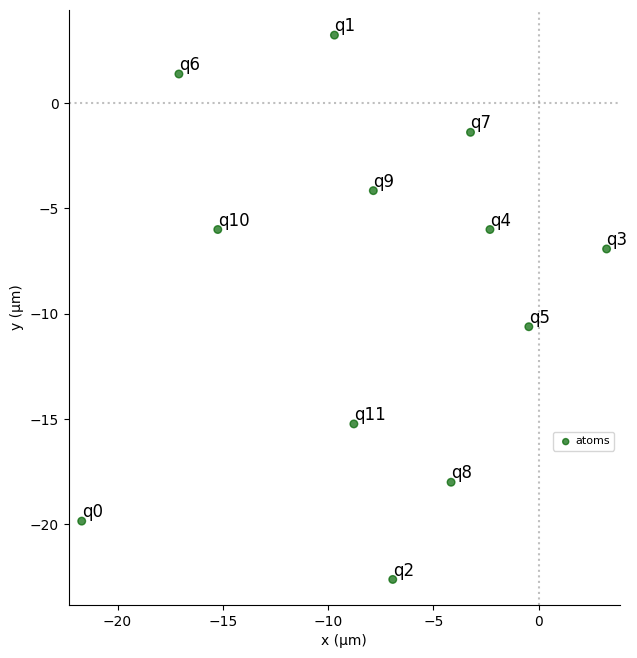

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=8



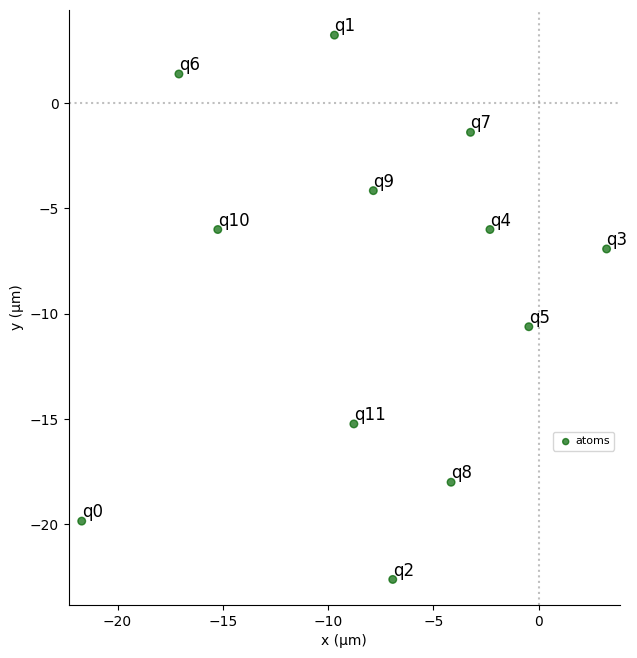

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=9



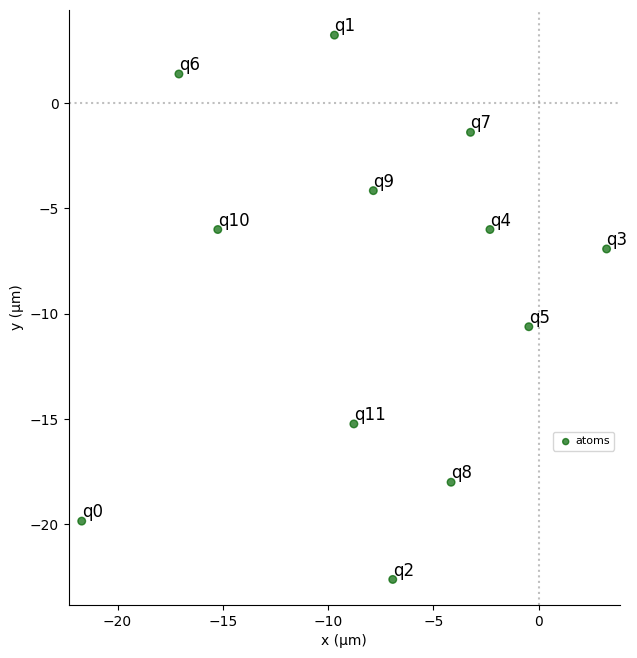

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=10



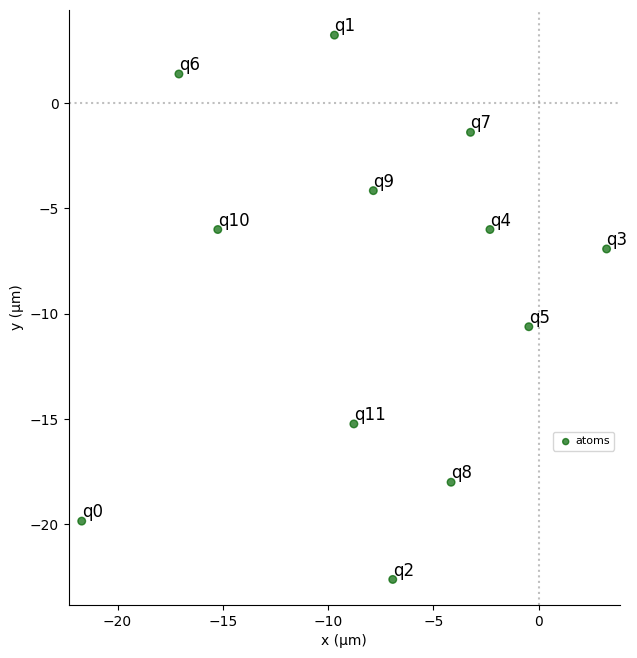

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=11



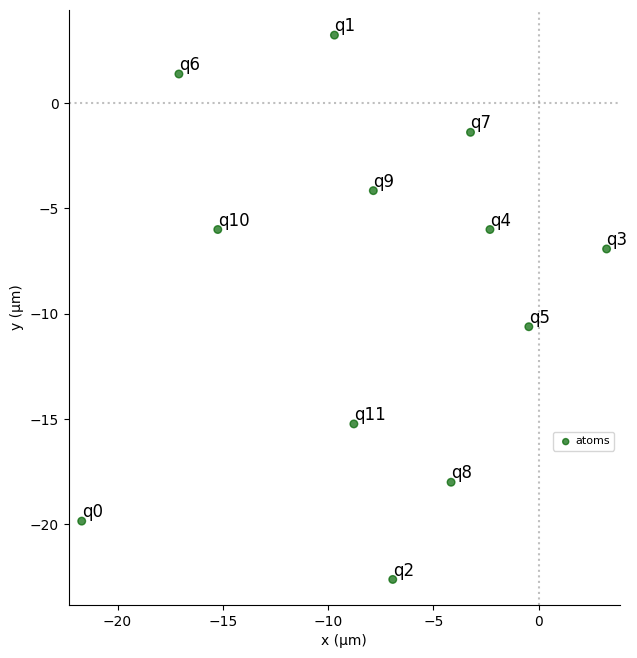

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=12



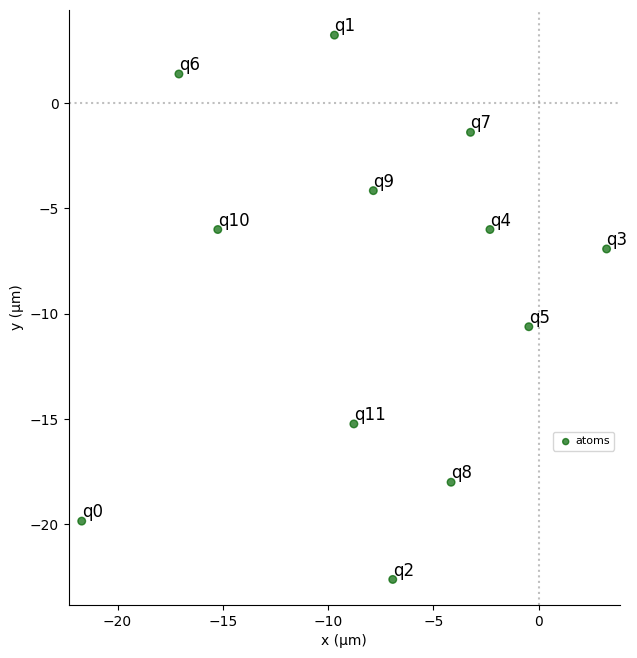

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=13



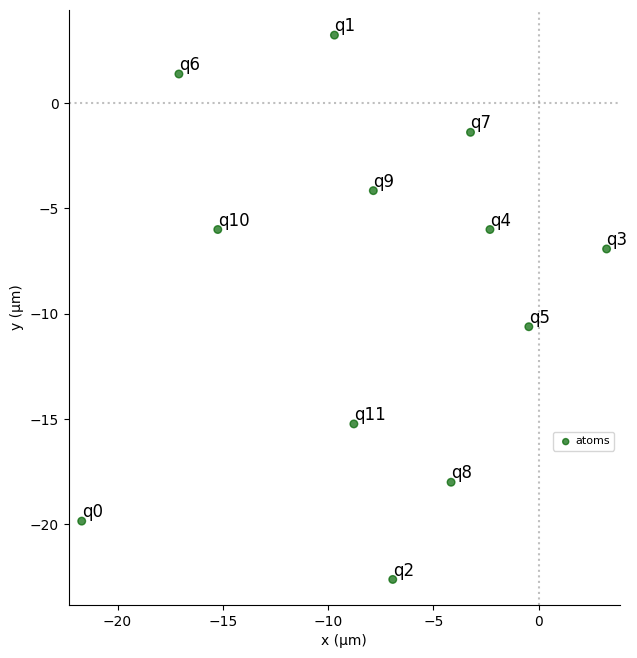

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=14



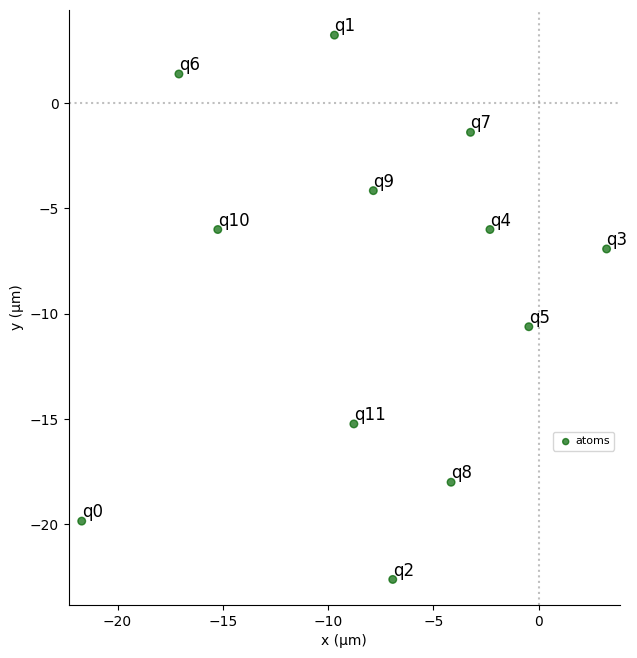

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=15



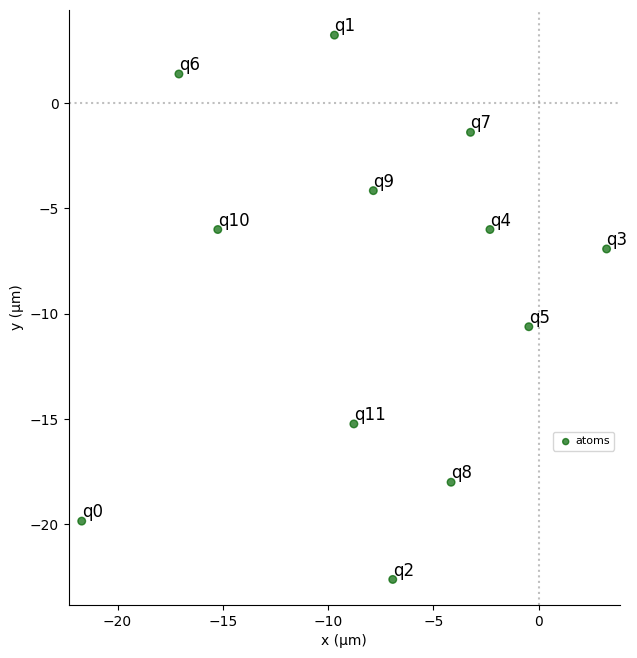

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=16



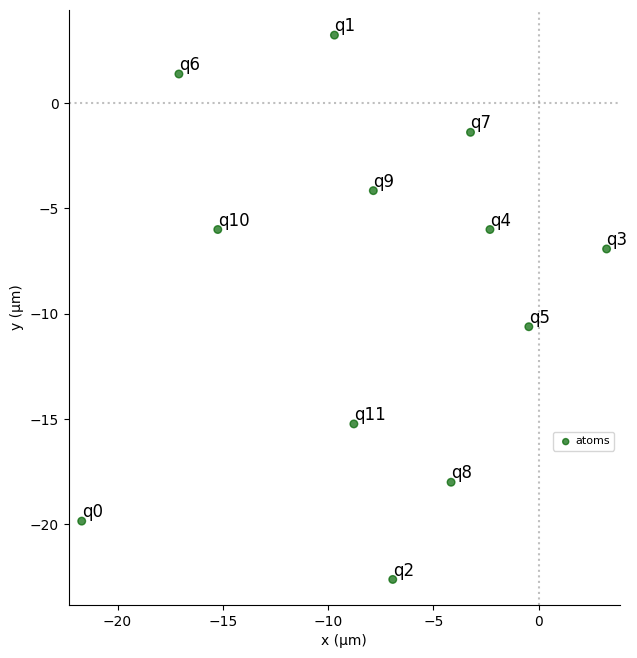

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=17



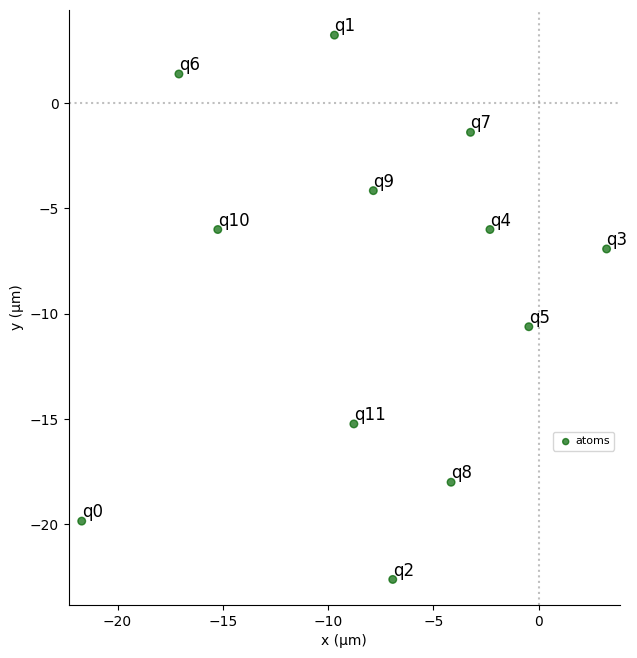

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=18



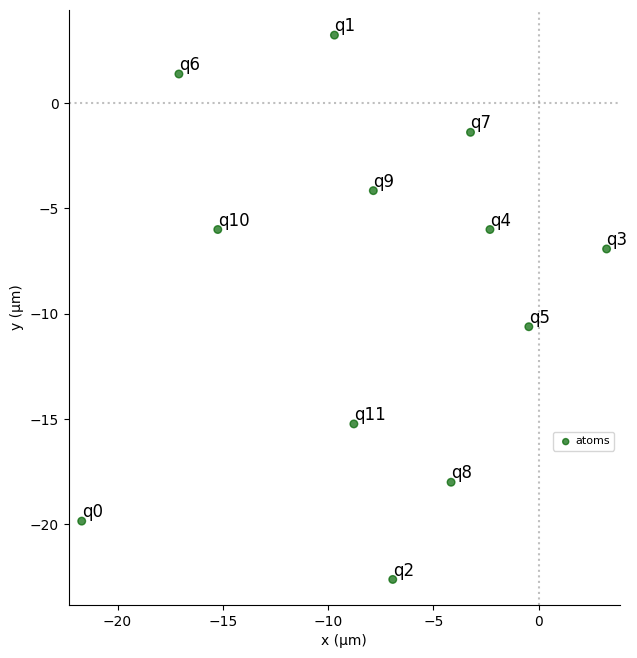

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=0 radius=19



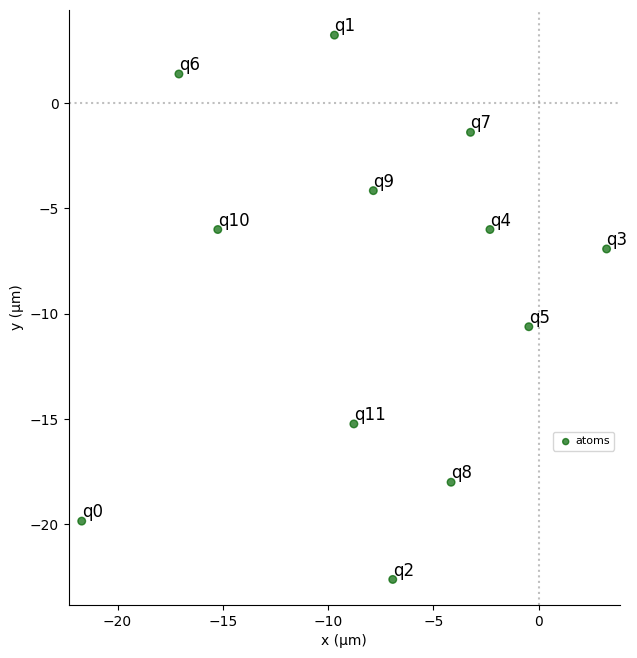

QAA lowest cost -13.288843743393986, lowest cost (found classically) : -39.840596570436865
Ratio QAA/classic : 0.6664496797908197
clustering=1 radius=6



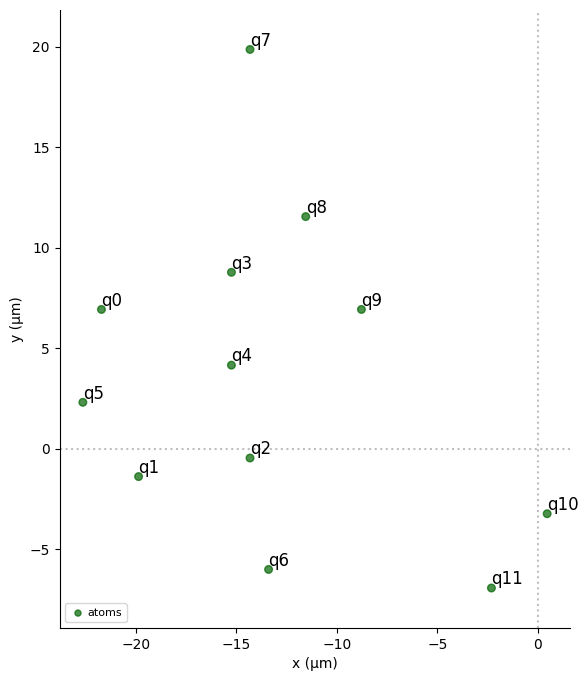

QAA lowest cost -17.698102320347243, lowest cost (found classically) : -39.75259935477991
Ratio QAA/classic : 0.5547938346773996
clustering=1 radius=7



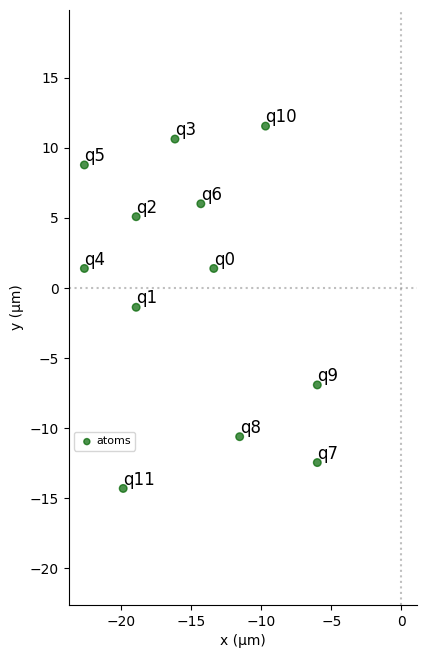

QAA lowest cost -22.115435199223167, lowest cost (found classically) : -37.53880118618547
Ratio QAA/classic : 0.41086463870983186
clustering=1 radius=8



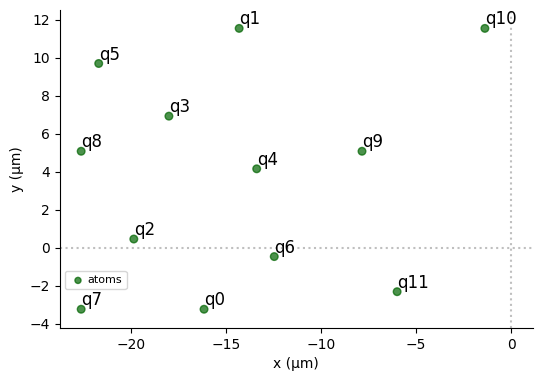

QAA lowest cost -22.22831211645756, lowest cost (found classically) : -35.72031587491004
Ratio QAA/classic : 0.37771233058801895
clustering=1 radius=9



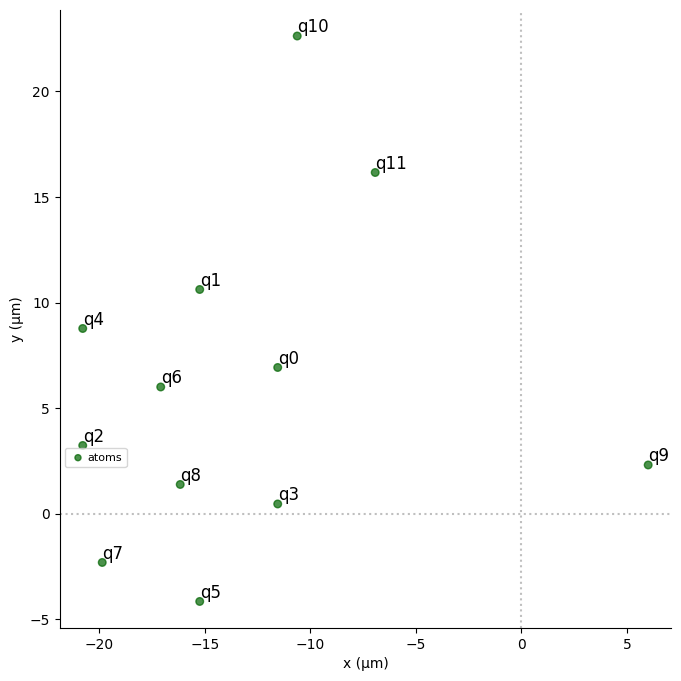

QAA lowest cost -30.607373289720588, lowest cost (found classically) : -38.00423103656185
Ratio QAA/classic : 0.19463248025529412
clustering=1 radius=10



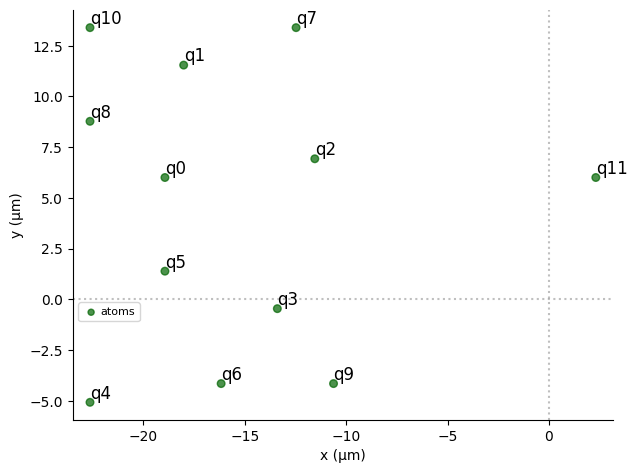

QAA lowest cost -25.13407782704678, lowest cost (found classically) : -37.3054358611205
Ratio QAA/classic : 0.3262623195017709
clustering=1 radius=11



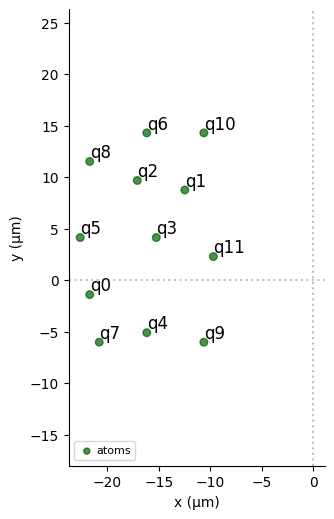

QAA lowest cost -4.486807774528017, lowest cost (found classically) : -28.68968048056098
Ratio QAA/classic : 0.8436090015861939
clustering=1 radius=12



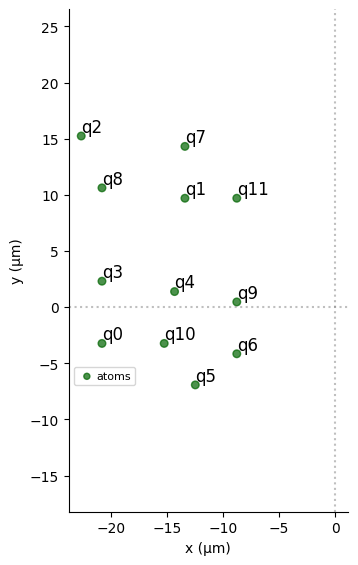

QAA lowest cost -20.96999998563767, lowest cost (found classically) : -33.2454788715749
Ratio QAA/classic : 0.36923754154231314
clustering=1 radius=13



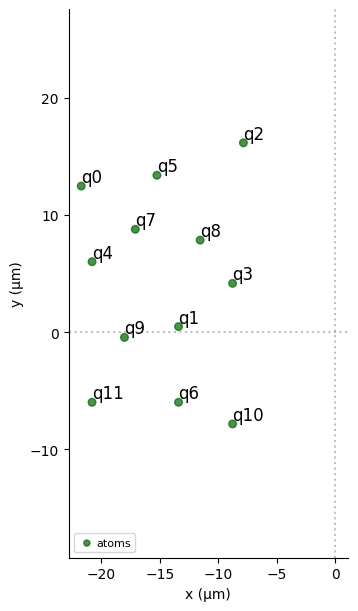

QAA lowest cost -23.42715710035213, lowest cost (found classically) : -36.24560715146869
Ratio QAA/classic : 0.35365527186643225
clustering=1 radius=14



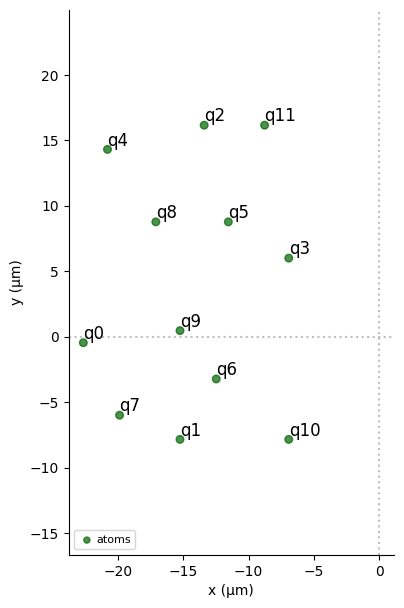

QAA lowest cost -23.952874353935652, lowest cost (found classically) : -35.97961382283133
Ratio QAA/classic : 0.33426538506269227
clustering=1 radius=15



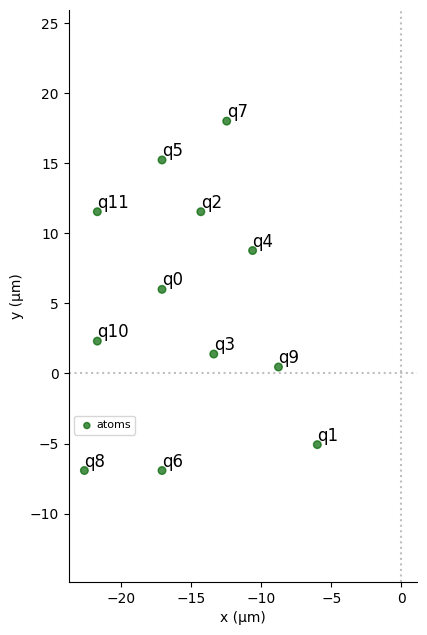

QAA lowest cost -23.726702158833344, lowest cost (found classically) : -34.897108857853524
Ratio QAA/classic : 0.32009547680642036
clustering=1 radius=16



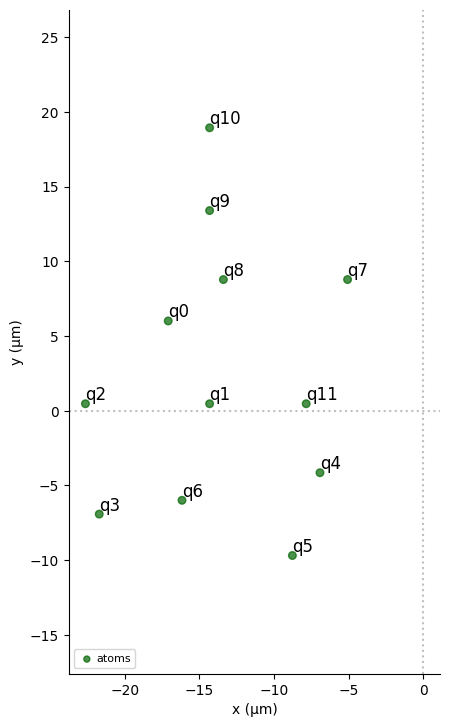

QAA lowest cost -23.00756946869268, lowest cost (found classically) : -38.901623076299366
Ratio QAA/classic : 0.4085704490127062
clustering=1 radius=17



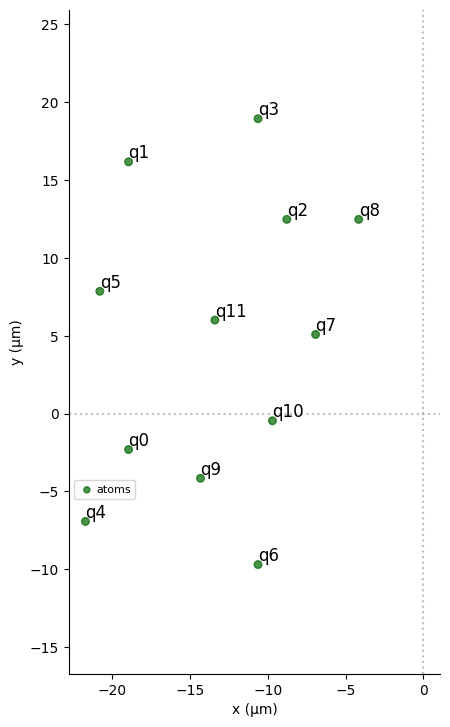

QAA lowest cost -17.169422847910493, lowest cost (found classically) : -39.25109498826384
Ratio QAA/classic : 0.5625746784123045
clustering=1 radius=18



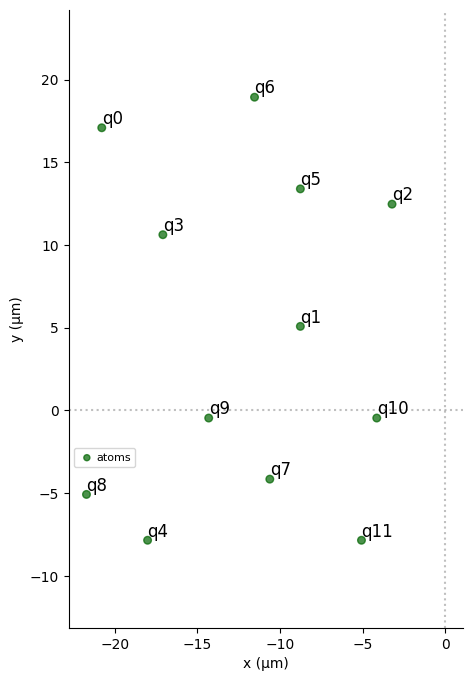

QAA lowest cost -6.598783065558398, lowest cost (found classically) : -38.925822808500556
Ratio QAA/classic : 0.8304780068998986
clustering=1 radius=19



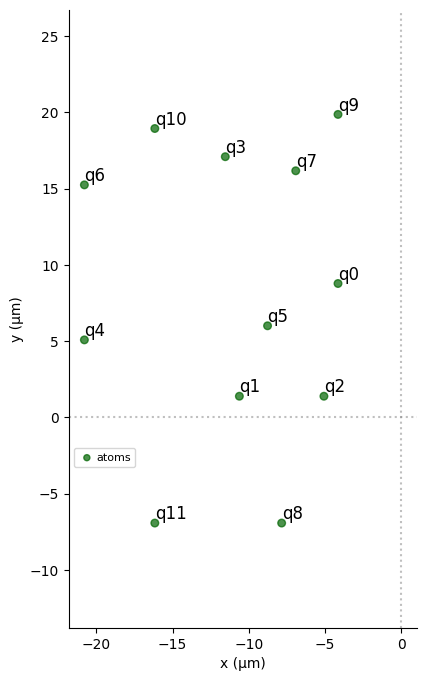

QAA lowest cost -8.445486143961737, lowest cost (found classically) : -40.236015701090324
Ratio QAA/classic : 0.7901013309393634
clustering=2 radius=6



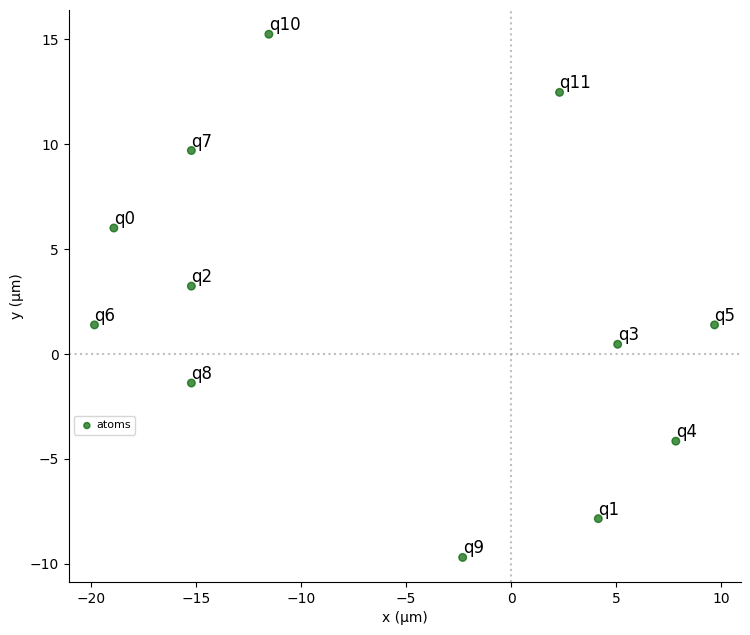

QAA lowest cost -0.29, lowest cost (found classically) : -45.165844711298334
Ratio QAA/classic : 0.9935792189462261
clustering=2 radius=7



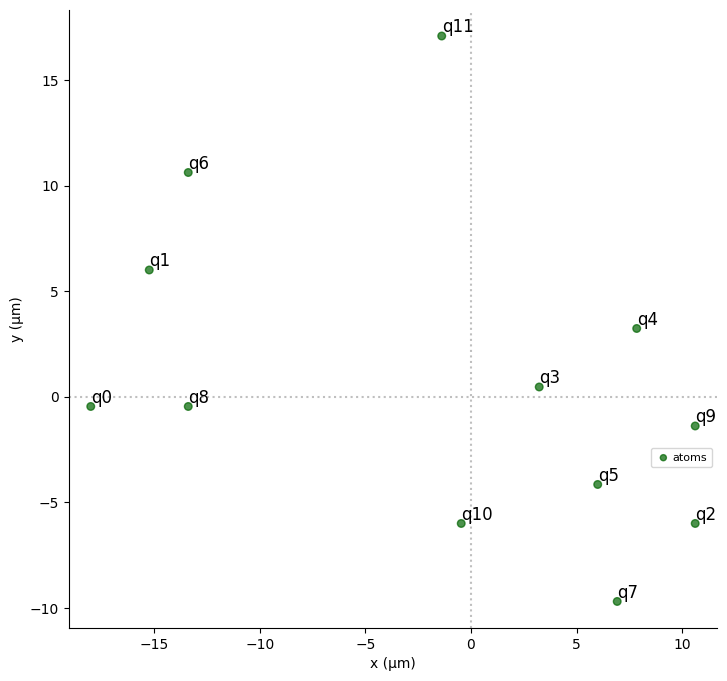

QAA lowest cost -1.1669968866686098, lowest cost (found classically) : -41.65719122428789
Ratio QAA/classic : 0.9719857039716063
clustering=2 radius=8



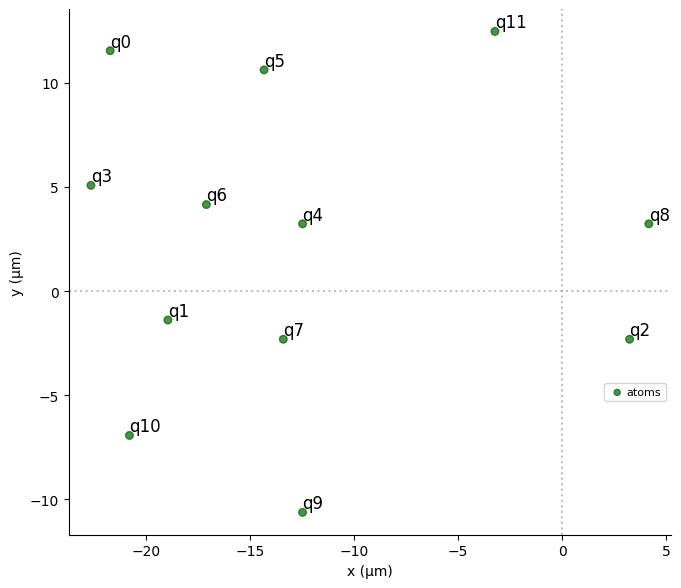

QAA lowest cost -11.42162910646606, lowest cost (found classically) : -41.47463805197051
Ratio QAA/classic : 0.7246117231414053
clustering=2 radius=9



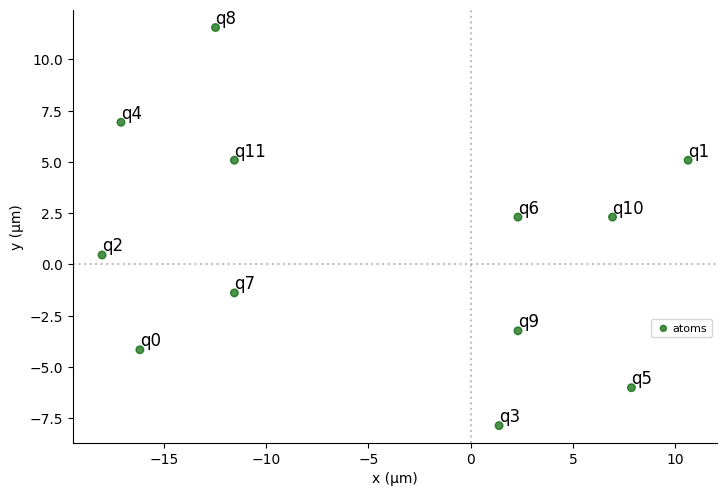

QAA lowest cost -3.9805348979591733, lowest cost (found classically) : -38.24769981356121
Ratio QAA/classic : 0.8959274696945874
clustering=2 radius=10



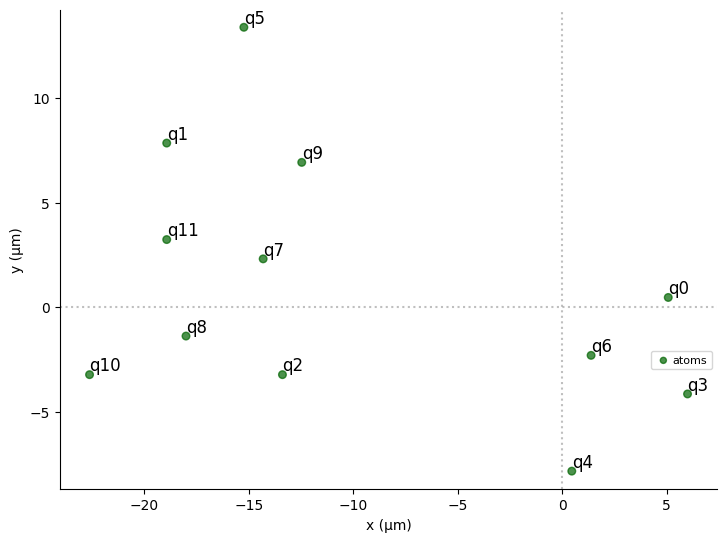

QAA lowest cost -8.346084298369833, lowest cost (found classically) : -29.65655938317198
Ratio QAA/classic : 0.7185754358576859
clustering=2 radius=11



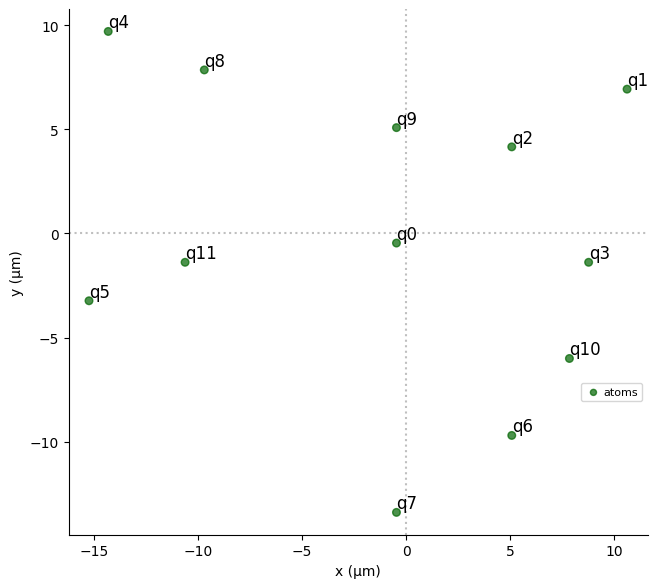

QAA lowest cost -8.832801677564627, lowest cost (found classically) : -41.60208382643612
Ratio QAA/classic : 0.7876836719426106
clustering=2 radius=12



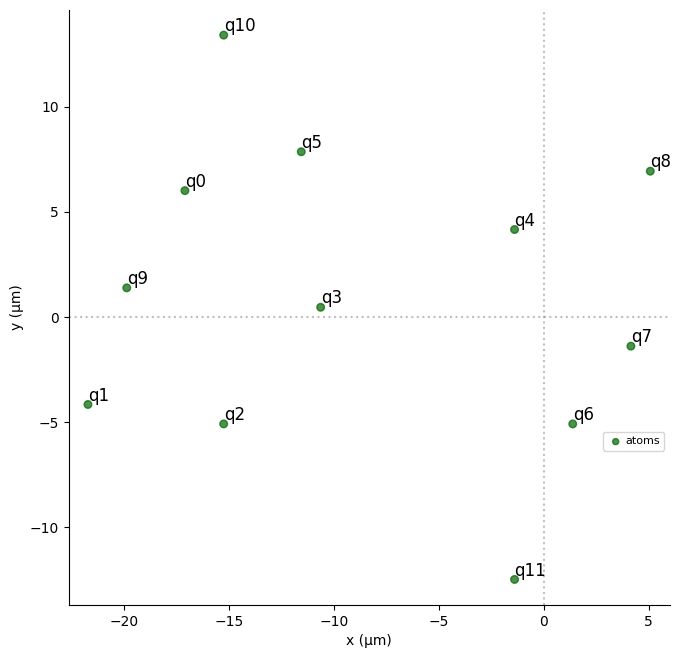

QAA lowest cost -4.394040959544242, lowest cost (found classically) : -42.98761810170649
Ratio QAA/classic : 0.8977835676043234
clustering=2 radius=13



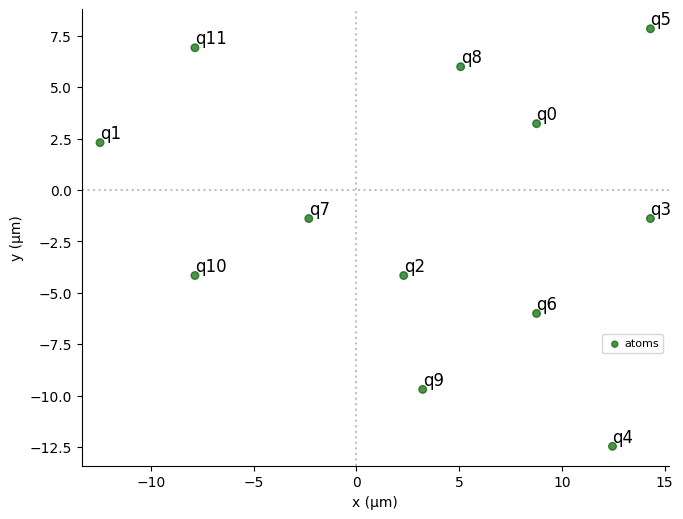

QAA lowest cost -19.518935695167976, lowest cost (found classically) : -36.618313278391405
Ratio QAA/classic : 0.4669624581892971
clustering=2 radius=14



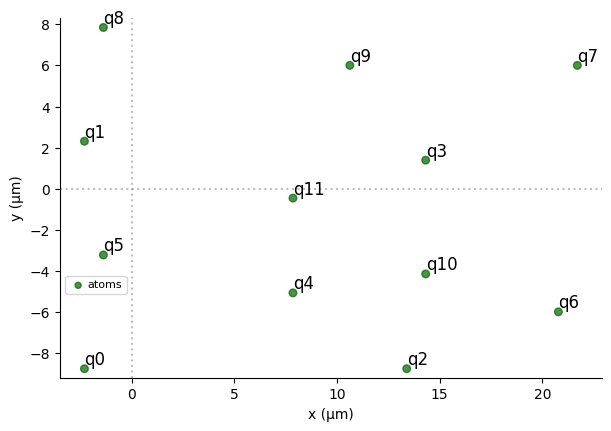

QAA lowest cost -24.662250738095892, lowest cost (found classically) : -38.428613096727474
Ratio QAA/classic : 0.35823208930233047
clustering=2 radius=15



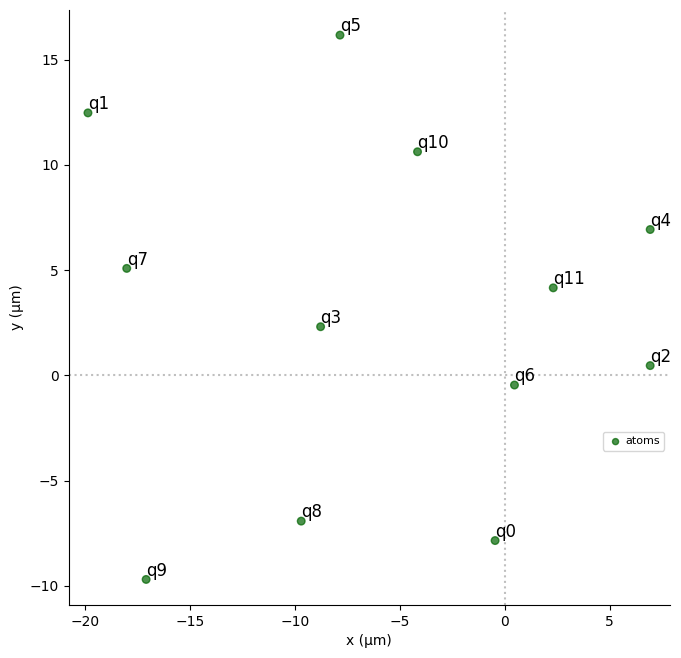

QAA lowest cost -4.6403510183134795, lowest cost (found classically) : -49.351772640019924
Ratio QAA/classic : 0.9059739747919294
clustering=2 radius=16



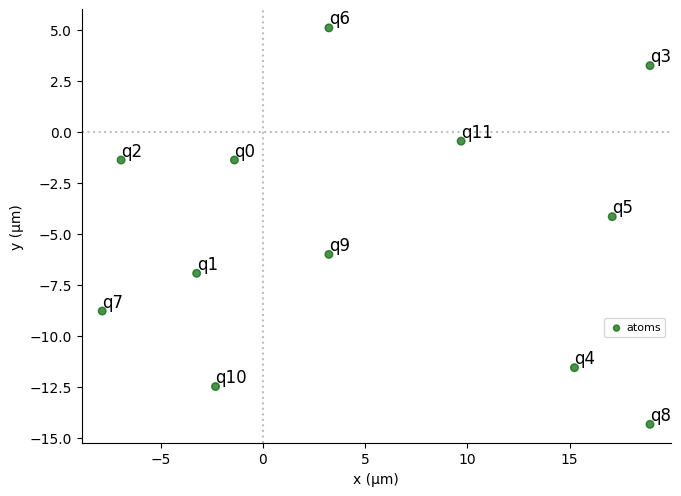

QAA lowest cost -5.71182920602143, lowest cost (found classically) : -41.2372276535225
Ratio QAA/classic : 0.8614885255135836
clustering=2 radius=17



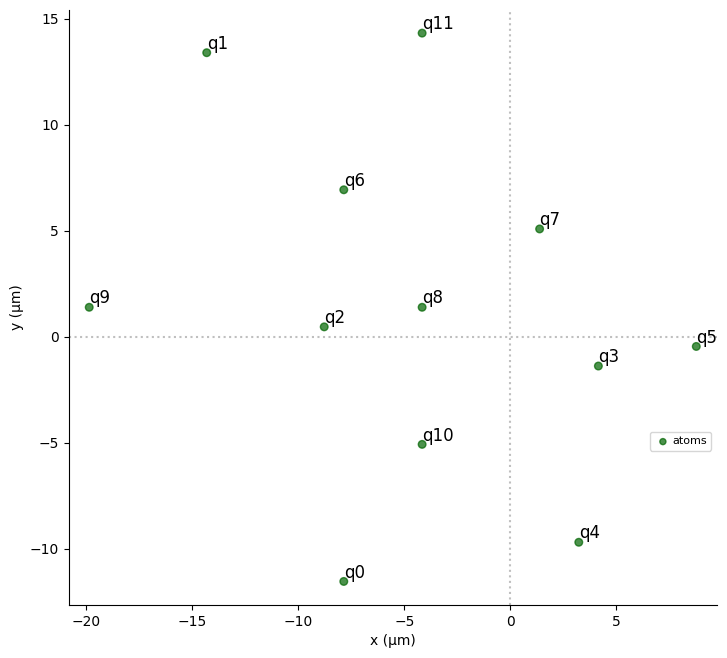

QAA lowest cost -19.199654555131882, lowest cost (found classically) : -42.01437609862083
Ratio QAA/classic : 0.5430217859224111
clustering=2 radius=18



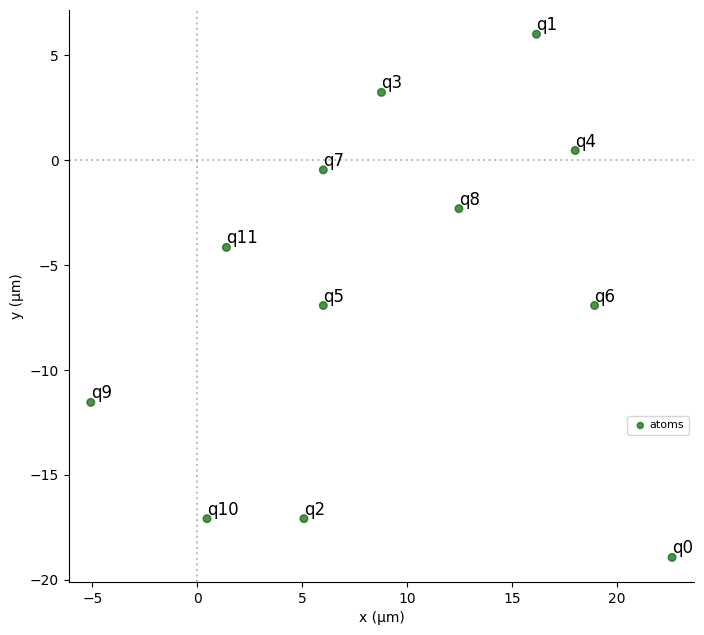

QAA lowest cost -11.632054242321523, lowest cost (found classically) : -43.71945156547309
Ratio QAA/classic : 0.733938697174605
clustering=2 radius=19



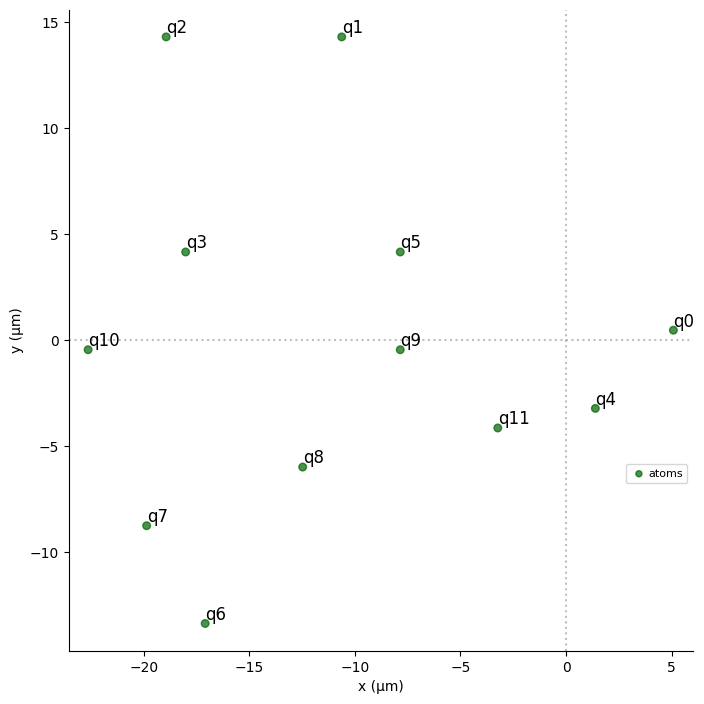

QAA lowest cost -6.69535516365059, lowest cost (found classically) : -43.8903680488074
Ratio QAA/classic : 0.8474527450714208
clustering=3 radius=6



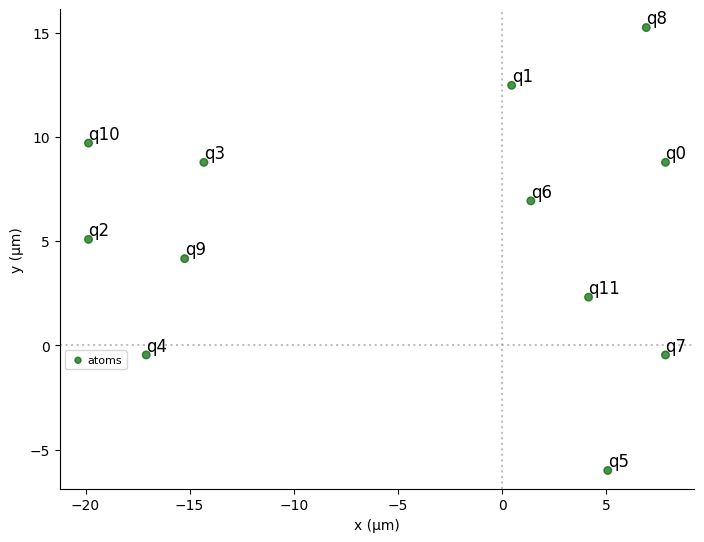

QAA lowest cost -0.9660389137805108, lowest cost (found classically) : -31.795972823648405
Ratio QAA/classic : 0.9696175701514622
clustering=3 radius=7



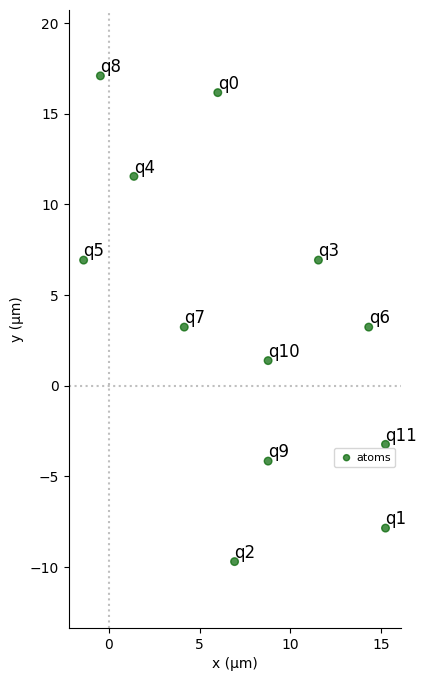

QAA lowest cost -22.108257711329617, lowest cost (found classically) : -33.30962042322831
Ratio QAA/classic : 0.3362801067552086
clustering=3 radius=8



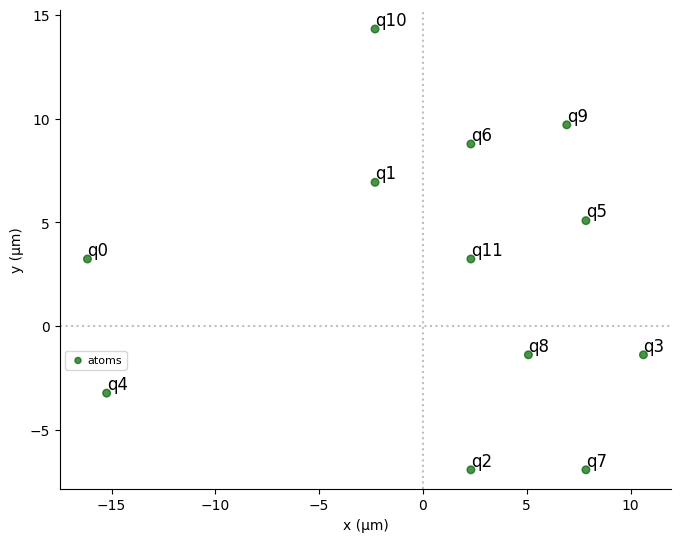

QAA lowest cost -21.56093929195758, lowest cost (found classically) : -35.774760036979245
Ratio QAA/classic : 0.39731421623315666
clustering=3 radius=9



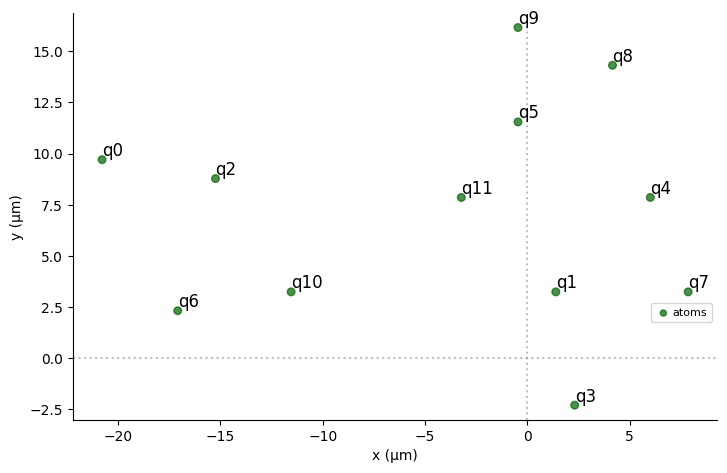

QAA lowest cost -19.617326446107118, lowest cost (found classically) : -33.1173268746722
Ratio QAA/classic : 0.40764160947089445
clustering=3 radius=10



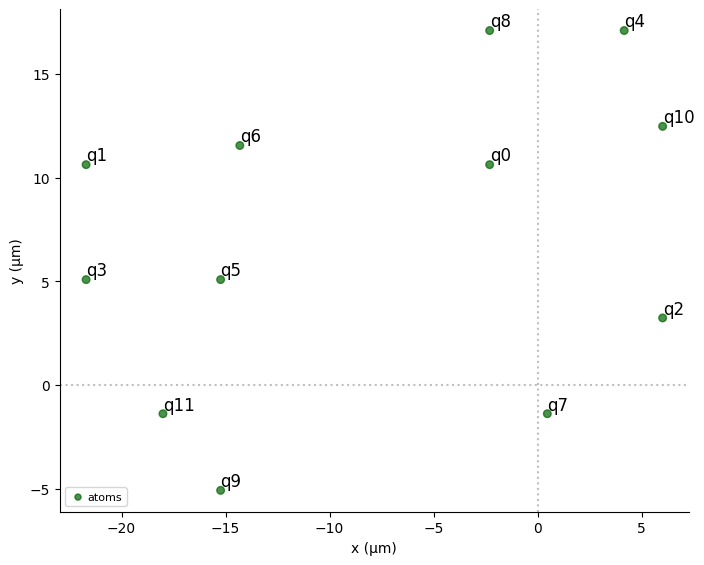

QAA lowest cost -1.7081296500062424, lowest cost (found classically) : -38.6551300186893
Ratio QAA/classic : 0.9558110489039777
clustering=3 radius=11



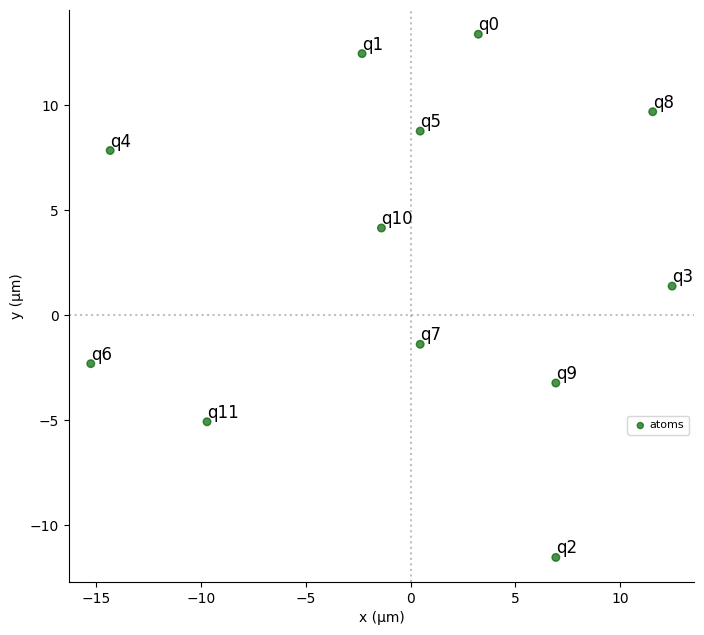

QAA lowest cost -8.669249294513902, lowest cost (found classically) : -45.229561119139845
Ratio QAA/classic : 0.8083278042057912
clustering=3 radius=12



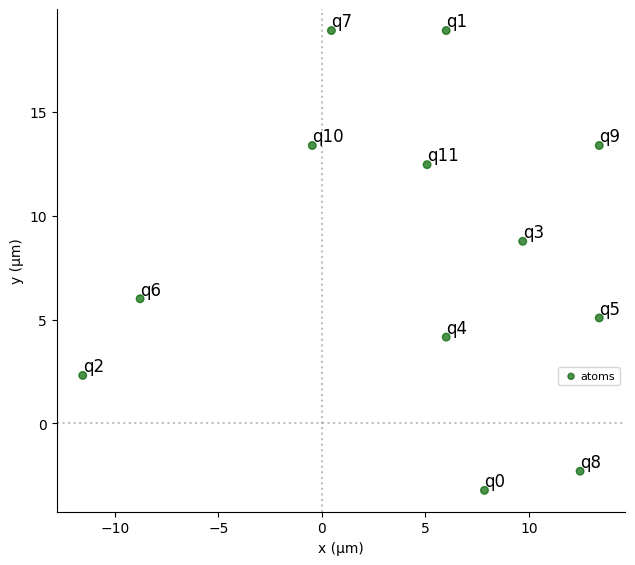

QAA lowest cost -8.842268362401505, lowest cost (found classically) : -37.82717718149975
Ratio QAA/classic : 0.766245619651312
clustering=3 radius=13



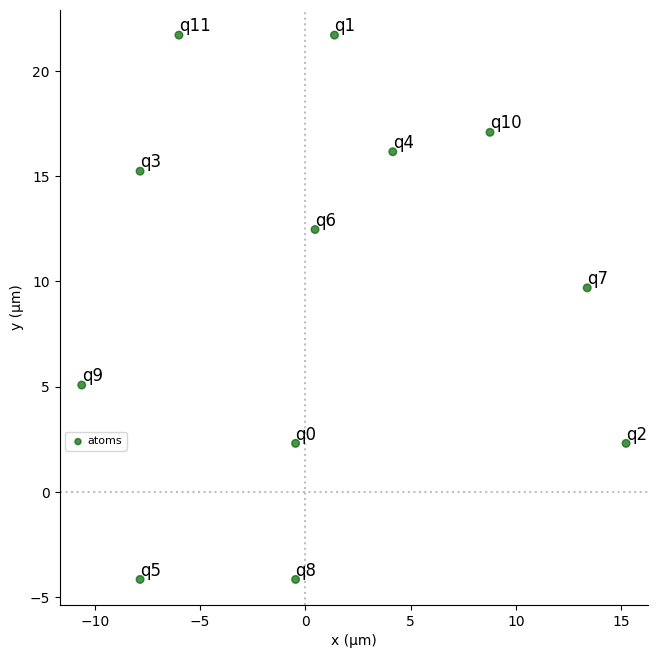

QAA lowest cost -2.5044431842584256, lowest cost (found classically) : -45.88257788373645
Ratio QAA/classic : 0.9454162494835289
clustering=3 radius=14



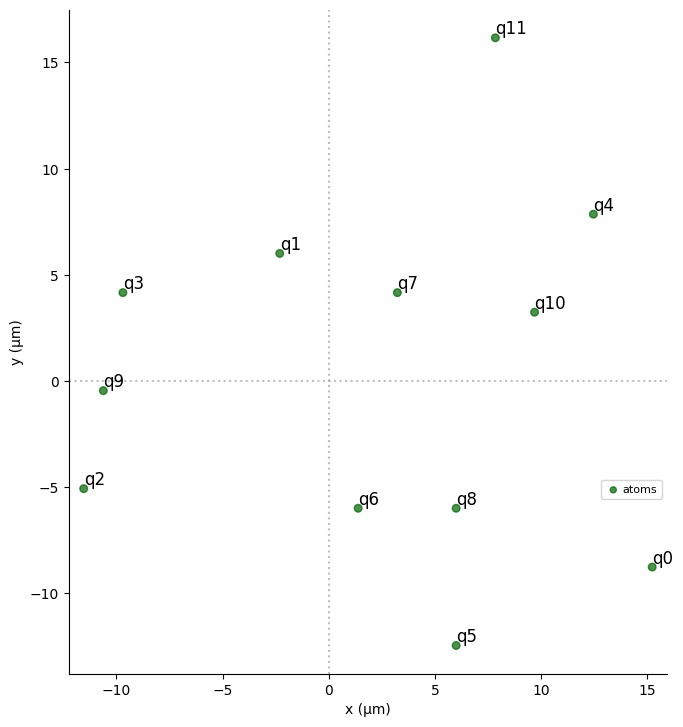

QAA lowest cost -8.436399139873808, lowest cost (found classically) : -41.168783471708764
Ratio QAA/classic : 0.7950777645477111
clustering=3 radius=15



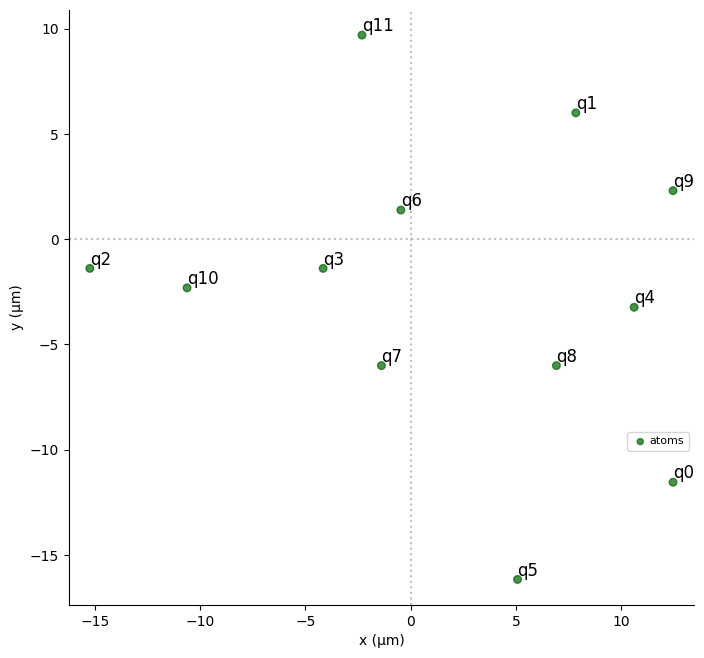

QAA lowest cost -9.957310108847524, lowest cost (found classically) : -43.98759573764847
Ratio QAA/classic : 0.7736336814534017
clustering=3 radius=16



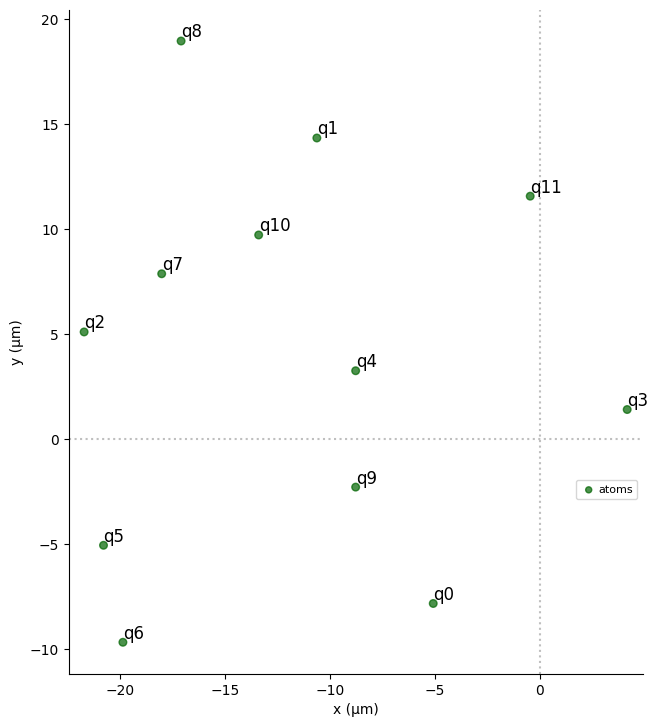

QAA lowest cost -8.119869425341912, lowest cost (found classically) : -48.26619303505451
Ratio QAA/classic : 0.8317690102584918
clustering=3 radius=17



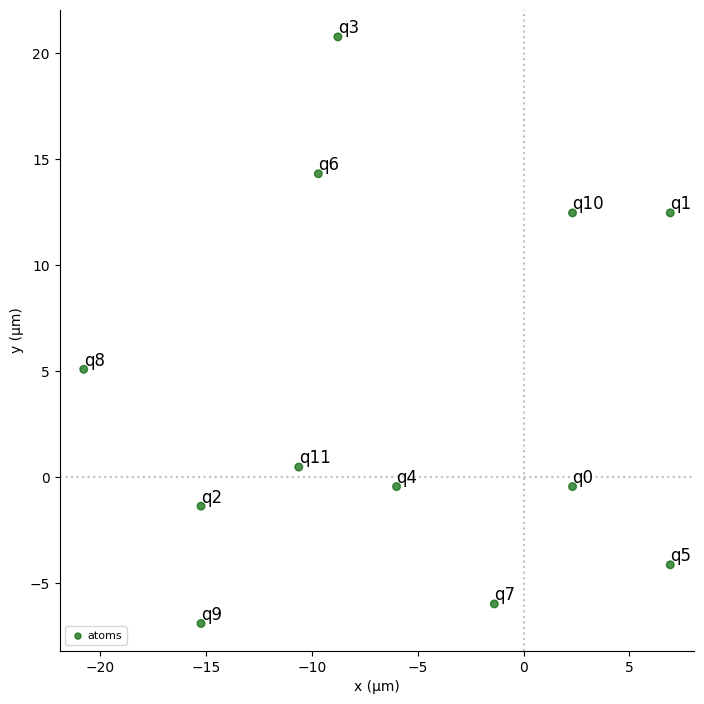

QAA lowest cost -2.1217156727532447, lowest cost (found classically) : -48.537011236739495
Ratio QAA/classic : 0.956286643559395
clustering=3 radius=18



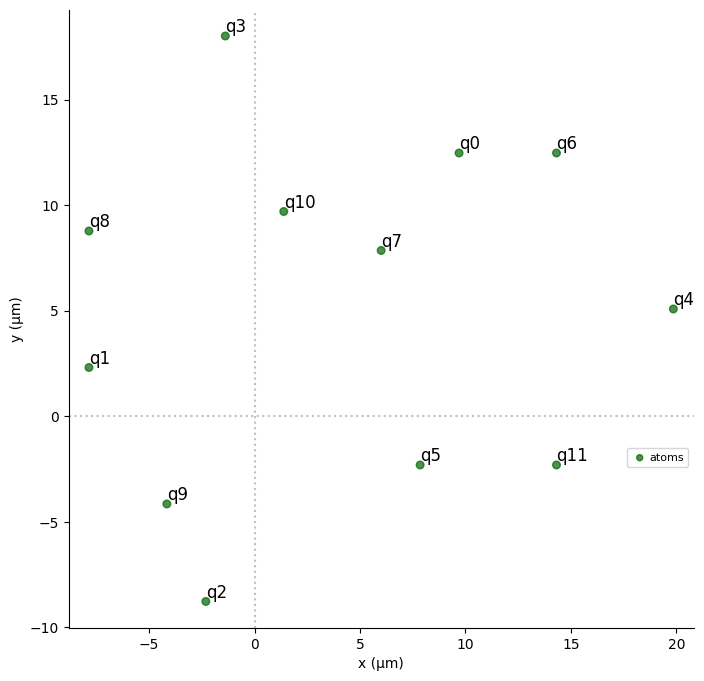

QAA lowest cost -6.634148539649553, lowest cost (found classically) : -44.4387083594985
Ratio QAA/classic : 0.8507123905136738
clustering=3 radius=19



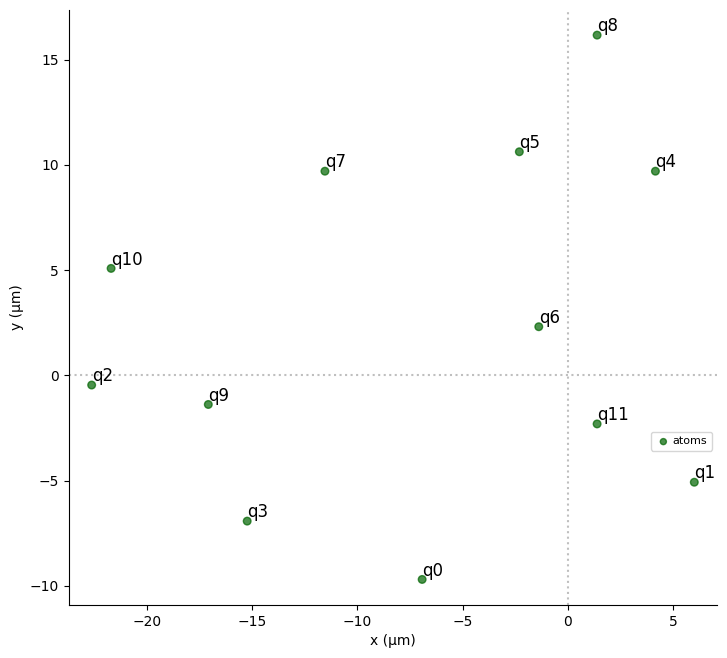

QAA lowest cost -1.8826482008575052, lowest cost (found classically) : -45.54621108433068
Ratio QAA/classic : 0.9586650973585552
clustering=4 radius=6



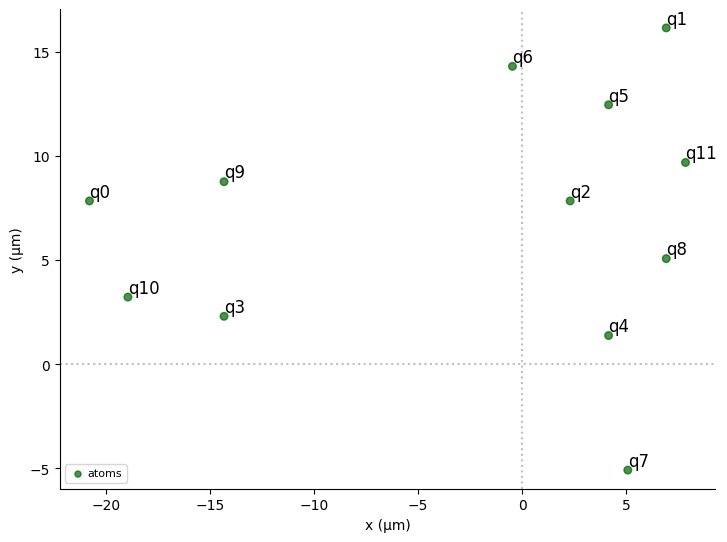

QAA lowest cost -1.9426011378198977, lowest cost (found classically) : -29.847581250918203
Ratio QAA/classic : 0.9349159611464283
clustering=4 radius=7



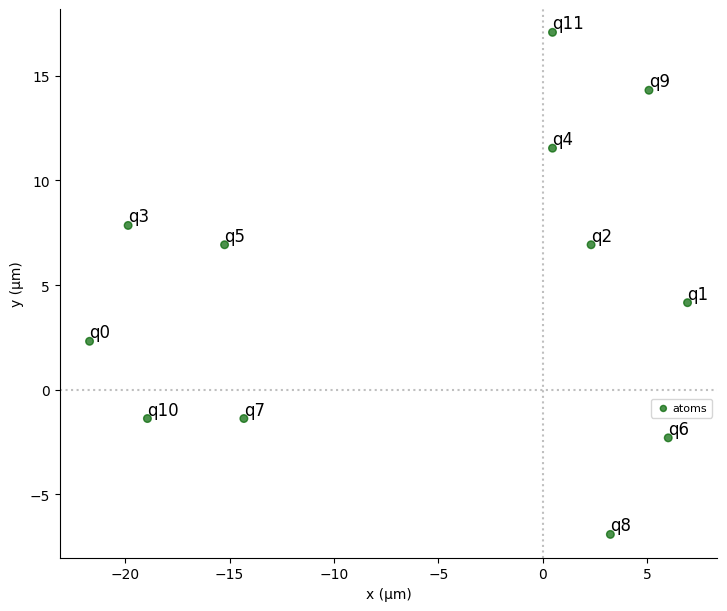

QAA lowest cost -0.61, lowest cost (found classically) : -36.970472391632775
Ratio QAA/classic : 0.9835003460724495
clustering=4 radius=8



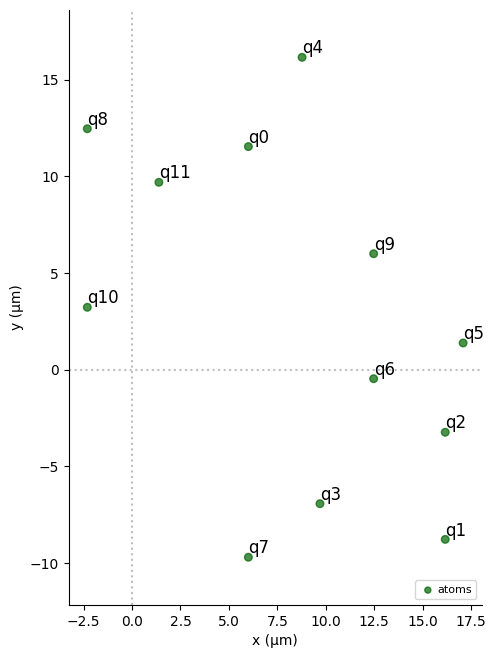

QAA lowest cost -7.569910010910231, lowest cost (found classically) : -37.31287183124155
Ratio QAA/classic : 0.7971233614730225
clustering=4 radius=9



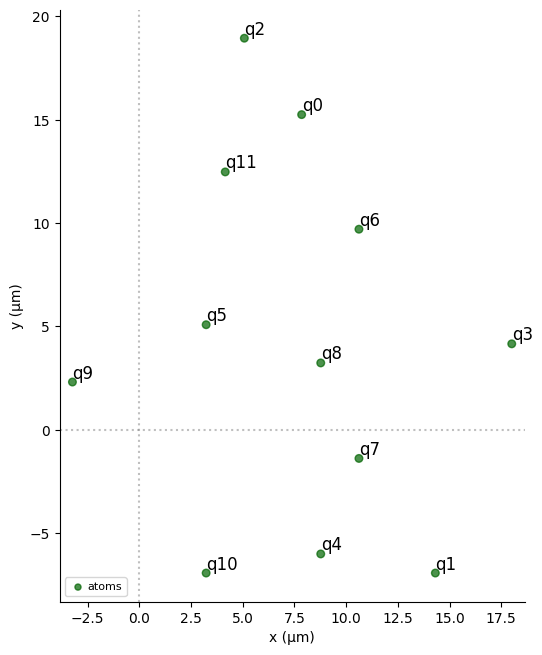

QAA lowest cost -25.65352289458911, lowest cost (found classically) : -36.65411403362721
Ratio QAA/classic : 0.3001188660281337
clustering=4 radius=10



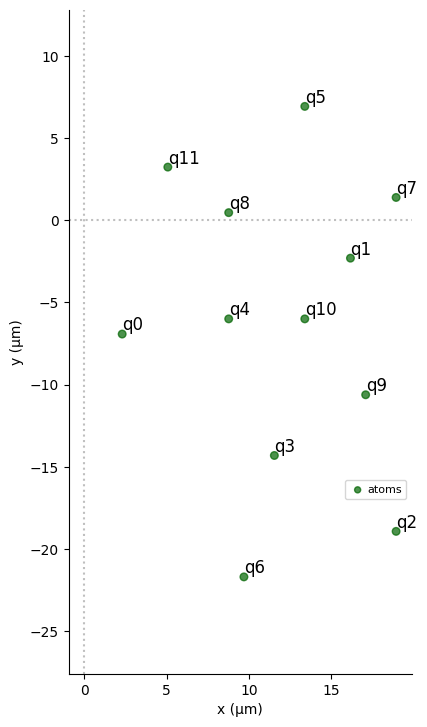

QAA lowest cost -24.190684657968415, lowest cost (found classically) : -35.96549775057746
Ratio QAA/classic : 0.32739191250091876
clustering=4 radius=11



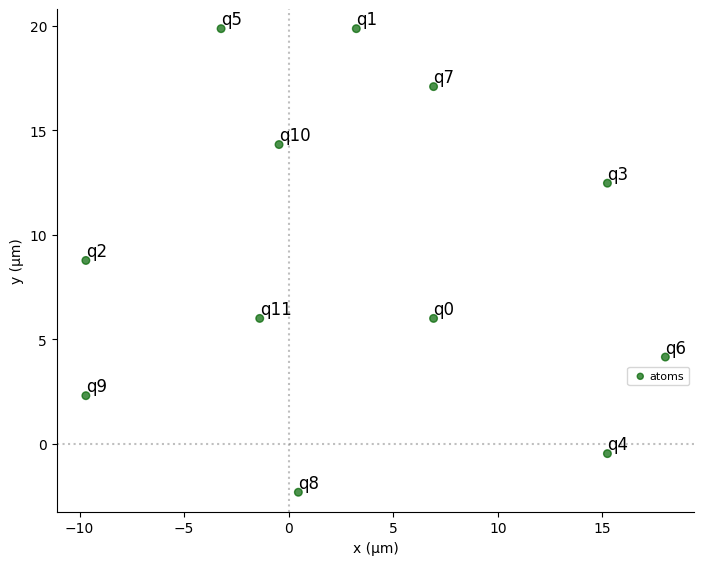

QAA lowest cost -6.049300397099227, lowest cost (found classically) : -43.5693626481612
Ratio QAA/classic : 0.8611570142544985
clustering=4 radius=12



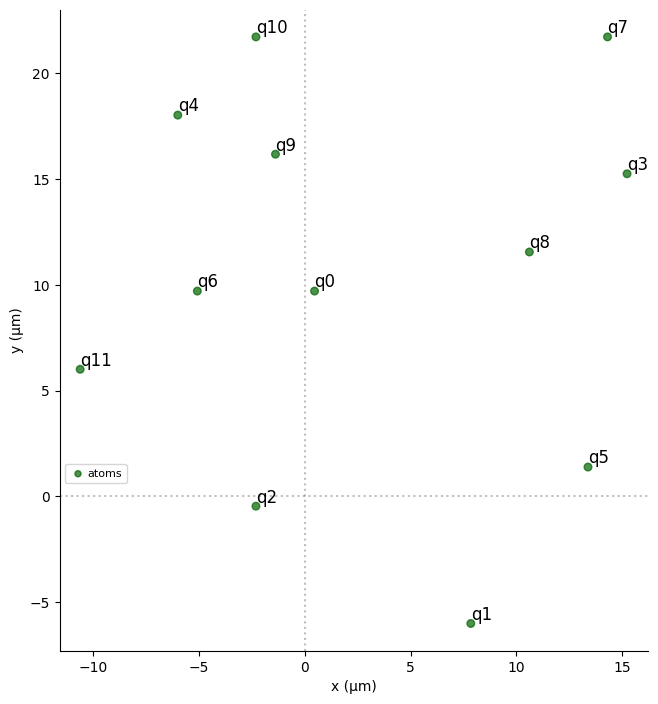

QAA lowest cost -2.5897723295757364, lowest cost (found classically) : -41.21025313207974
Ratio QAA/classic : 0.9371570875511135
clustering=4 radius=13



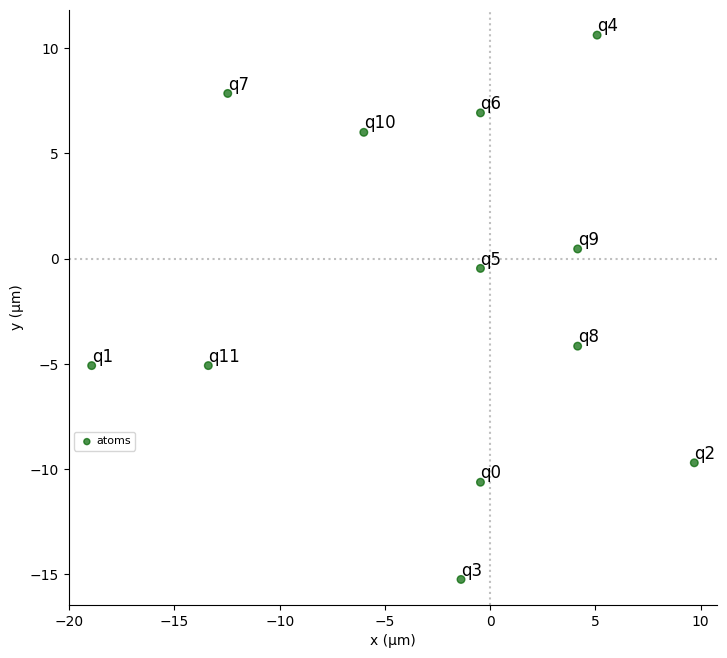

QAA lowest cost -9.984129766587923, lowest cost (found classically) : -48.06846466977899
Ratio QAA/classic : 0.7922935580493998
clustering=4 radius=14



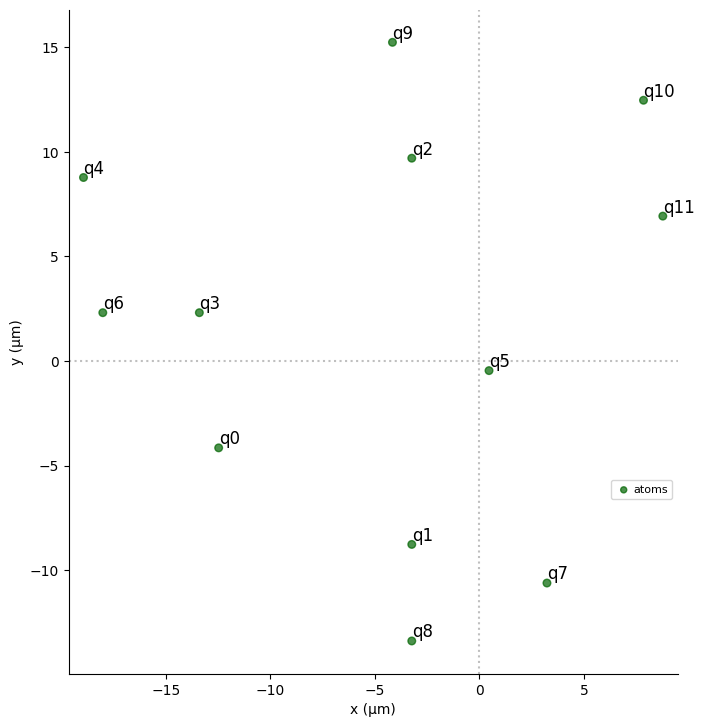

QAA lowest cost -2.339736615513042, lowest cost (found classically) : -47.32899481857448
Ratio QAA/classic : 0.9505644135380031
clustering=4 radius=15



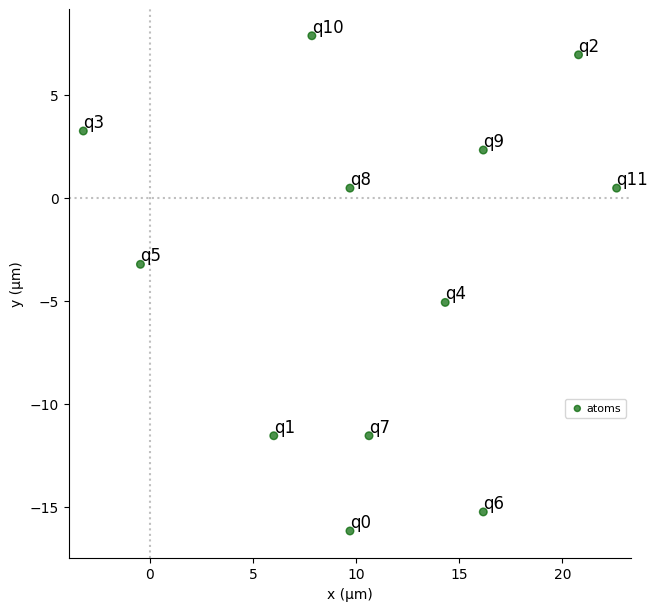

QAA lowest cost -9.923652208725409, lowest cost (found classically) : -37.98947213198981
Ratio QAA/classic : 0.7387788865755522
clustering=4 radius=16



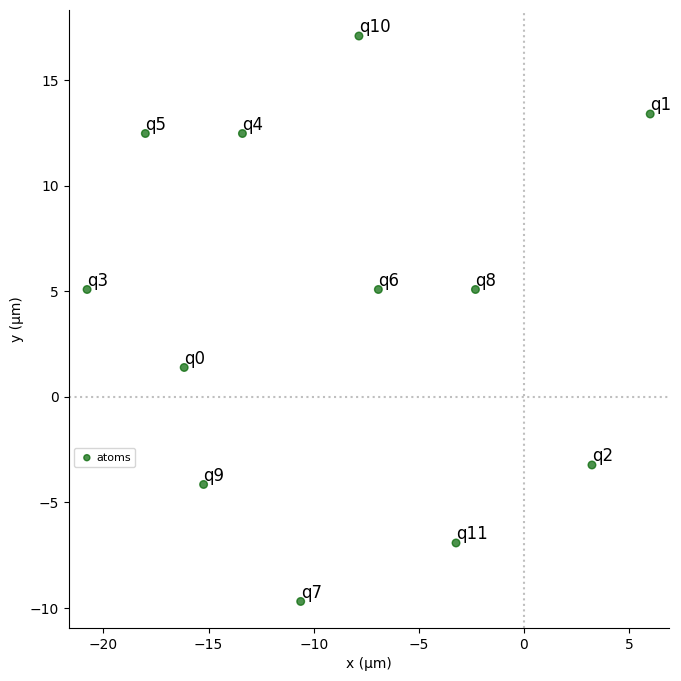

QAA lowest cost -6.536428645364619, lowest cost (found classically) : -47.664876239937165
Ratio QAA/classic : 0.8628669754126433
clustering=4 radius=17



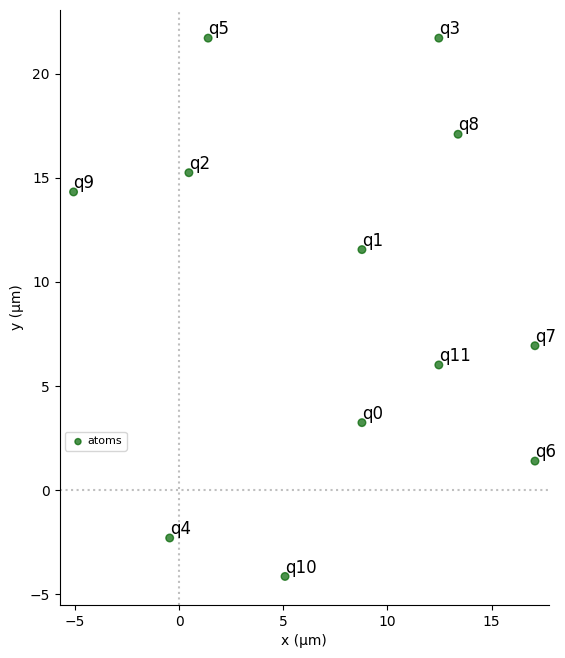

QAA lowest cost -6.837858972927012, lowest cost (found classically) : -38.83878698206371
Ratio QAA/classic : 0.8239425197268693
clustering=4 radius=18



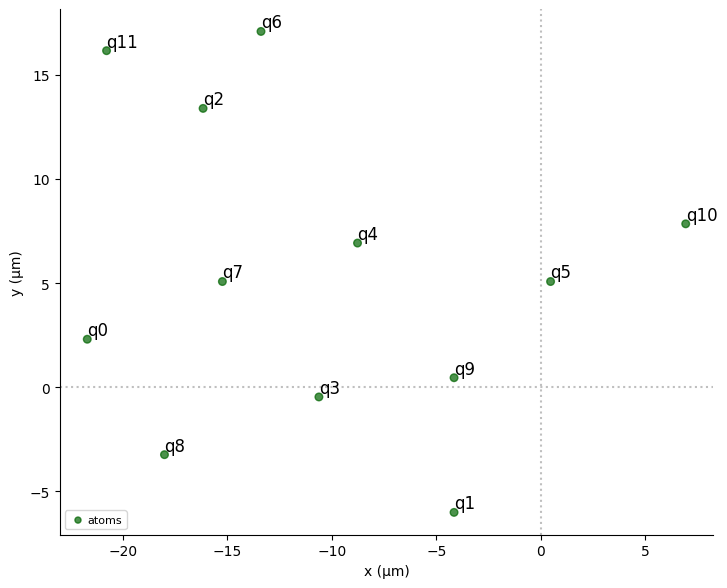

QAA lowest cost -13.3250746013546, lowest cost (found classically) : -43.17855725311384
Ratio QAA/classic : 0.6913960204079386
clustering=4 radius=19



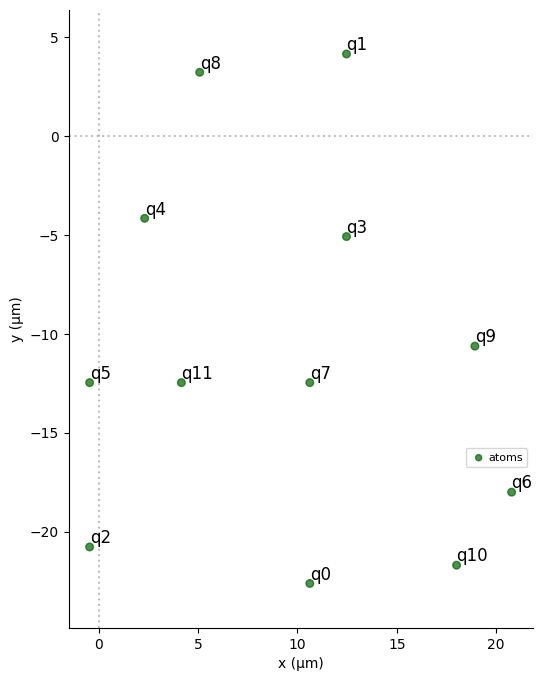

QAA lowest cost -6.473219652882298, lowest cost (found classically) : -40.23925990895407
Ratio QAA/classic : 0.8391317417982165
clustering=5 radius=6



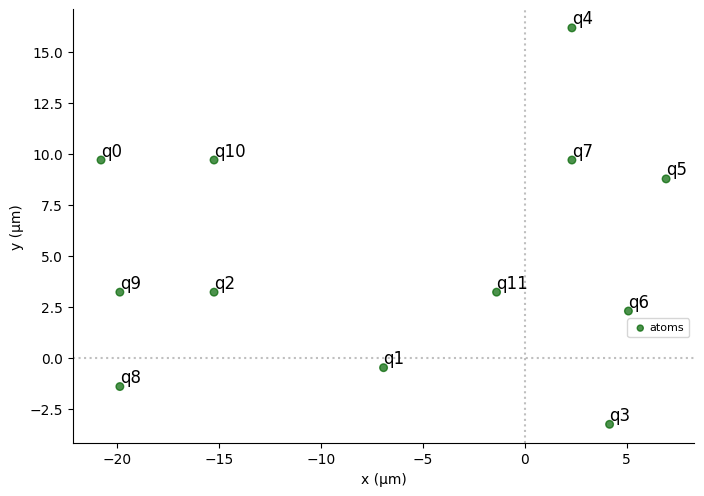

QAA lowest cost -10.375464133805439, lowest cost (found classically) : -36.864572948502854
Ratio QAA/classic : 0.7185518967411012
clustering=5 radius=7



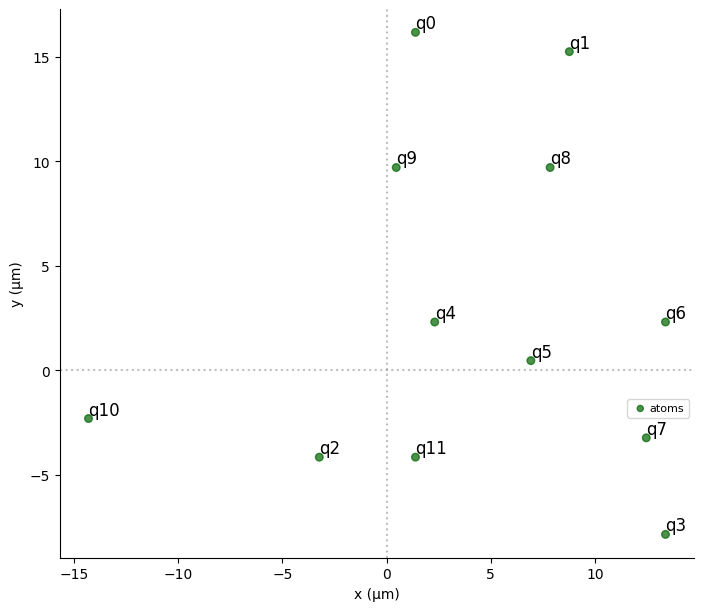

QAA lowest cost -14.143596850551939, lowest cost (found classically) : -37.35956986157426
Ratio QAA/classic : 0.6214197084453276
clustering=5 radius=8



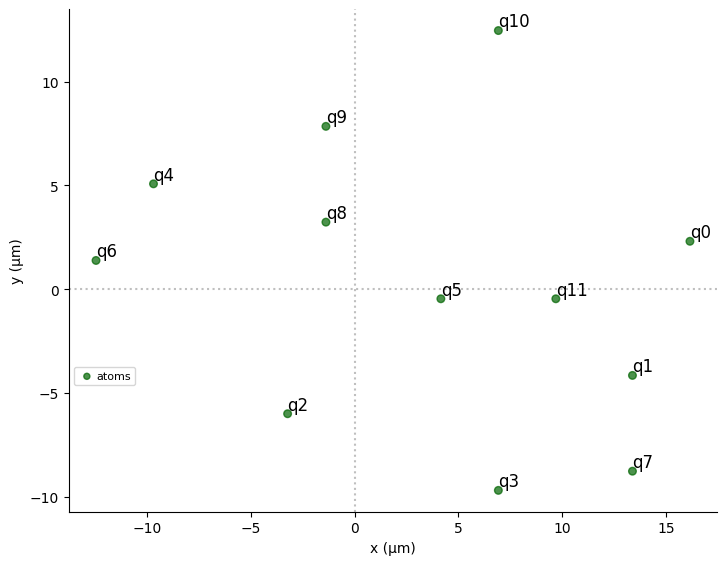

QAA lowest cost -16.91039431157095, lowest cost (found classically) : -39.90265928462216
Ratio QAA/classic : 0.5762088388407751
clustering=5 radius=9



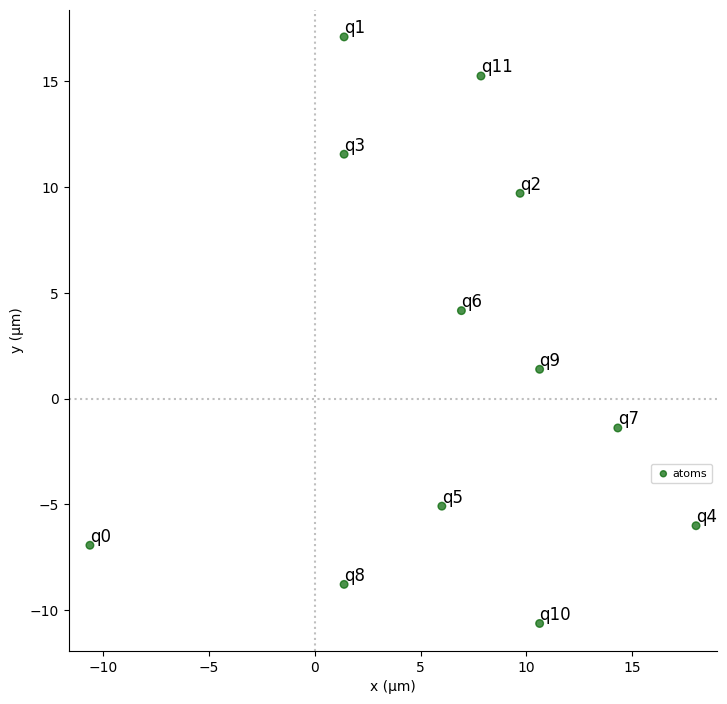

QAA lowest cost -8.06130327458147, lowest cost (found classically) : -42.17622120530803
Ratio QAA/classic : 0.8088661562319641
clustering=5 radius=10



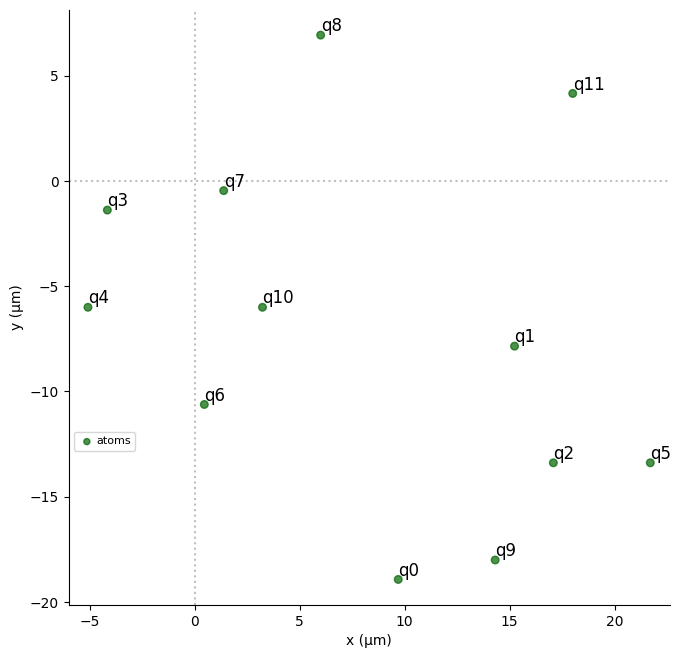

QAA lowest cost -2.692011832386514, lowest cost (found classically) : -43.72850339428642
Ratio QAA/classic : 0.9384380524502869
clustering=5 radius=11



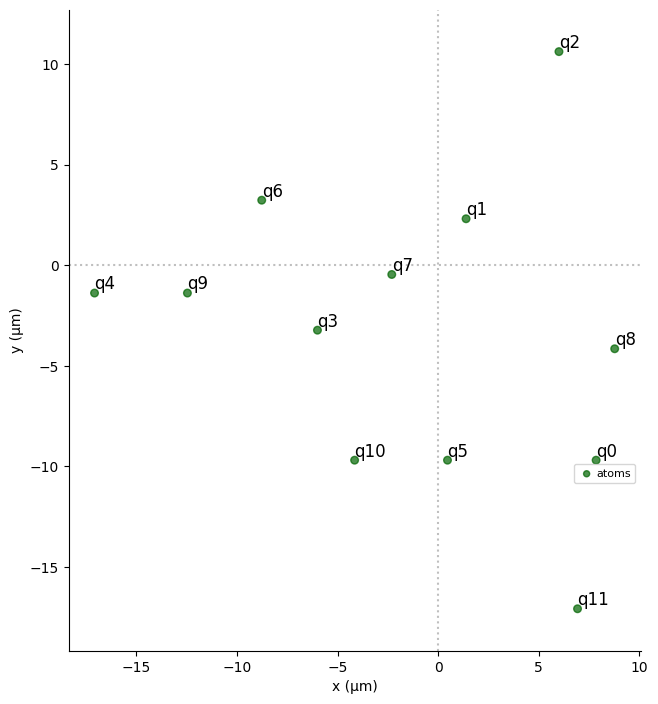

QAA lowest cost -17.080726940692468, lowest cost (found classically) : -42.52409852362088
Ratio QAA/classic : 0.5983283001001273
clustering=5 radius=12



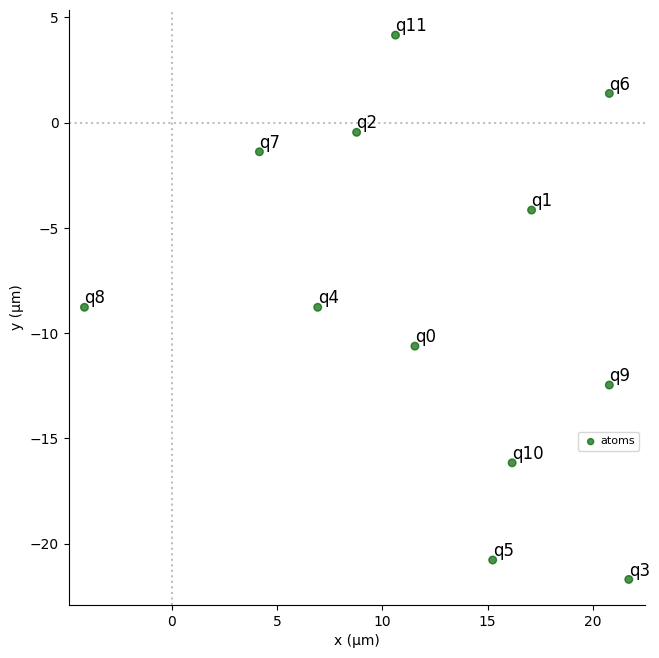

QAA lowest cost -11.201718872598676, lowest cost (found classically) : -38.160757754096586
Ratio QAA/classic : 0.7064597368642094
clustering=5 radius=13



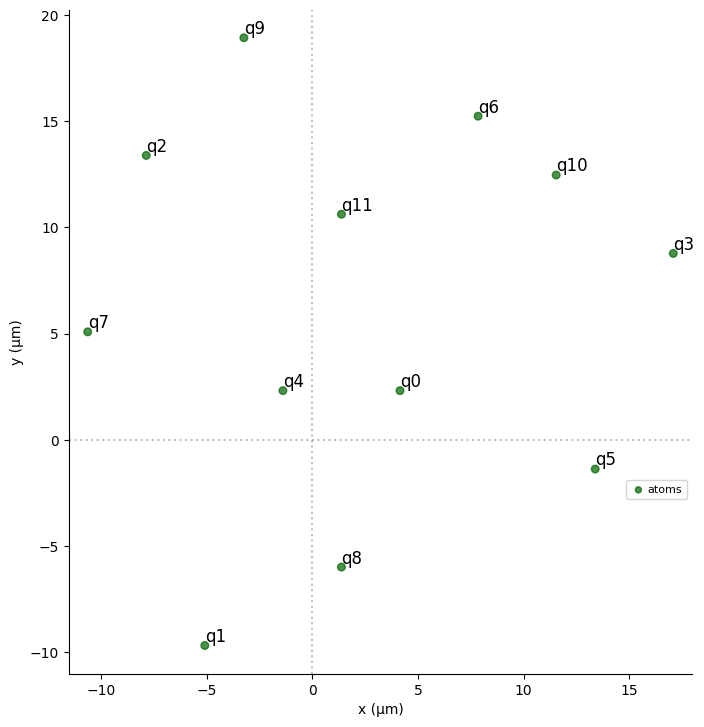

QAA lowest cost -4.184982906776829, lowest cost (found classically) : -46.15864050638816
Ratio QAA/classic : 0.9093347884412314
clustering=5 radius=14



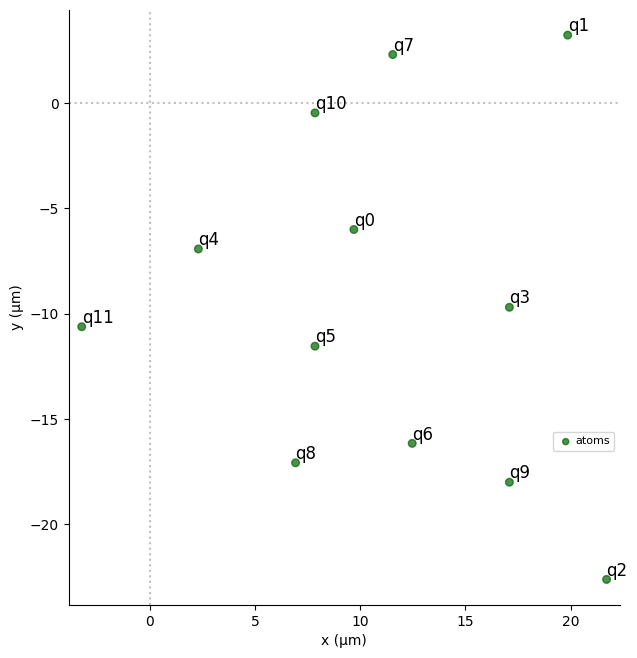

QAA lowest cost -19.932112193873216, lowest cost (found classically) : -42.61795493893845
Ratio QAA/classic : 0.5323071643763464
clustering=5 radius=15



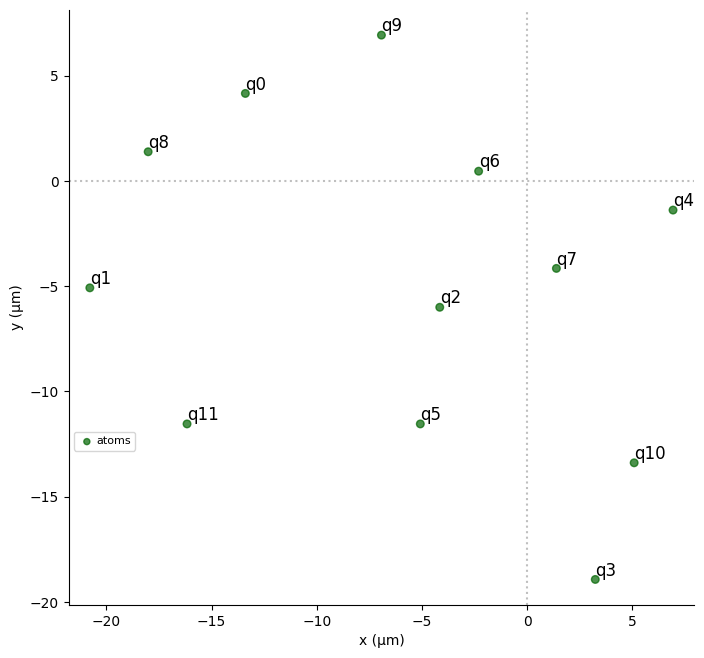

QAA lowest cost -5.030646277127212, lowest cost (found classically) : -44.09321552361122
Ratio QAA/classic : 0.885908836146609
clustering=5 radius=16



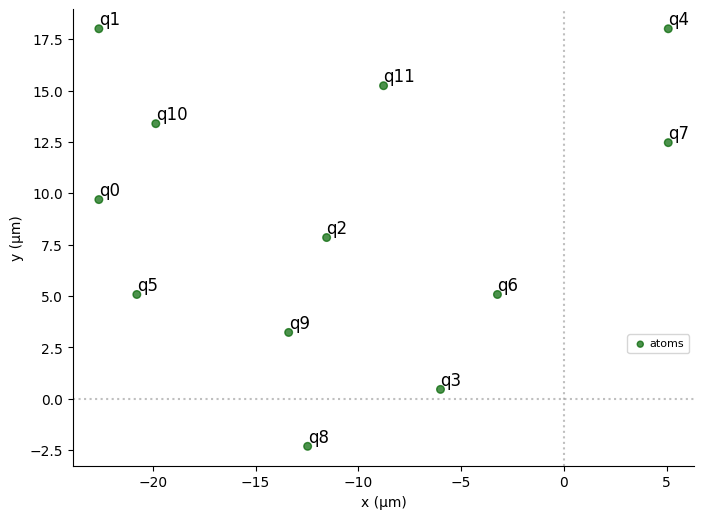

QAA lowest cost -8.049179787902773, lowest cost (found classically) : -42.41547712721719
Ratio QAA/classic : 0.8102301251083235
clustering=5 radius=17



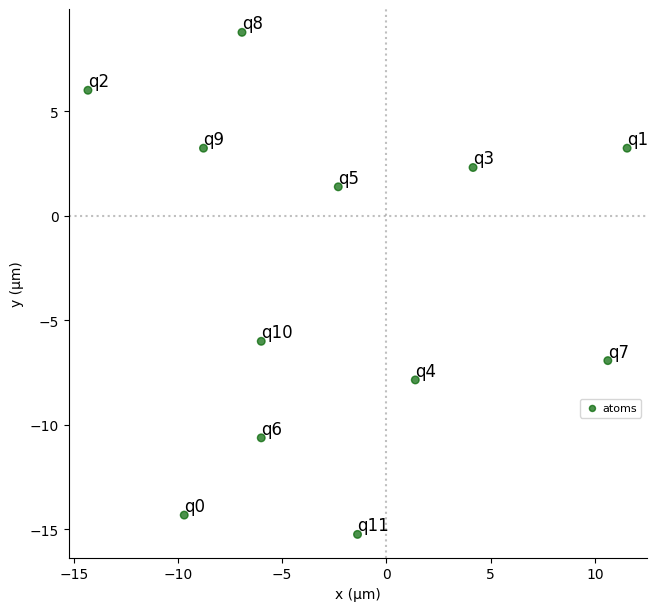

QAA lowest cost -9.656500039947293, lowest cost (found classically) : -36.31076364681314
Ratio QAA/classic : 0.7340595715949696
clustering=5 radius=18



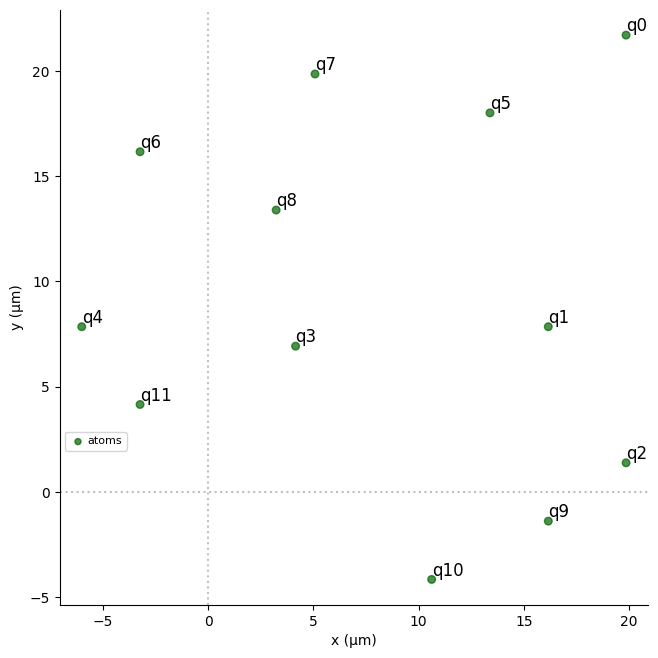

QAA lowest cost -2.576334647963419, lowest cost (found classically) : -44.26362564877353
Ratio QAA/classic : 0.9417956705940376
clustering=5 radius=19



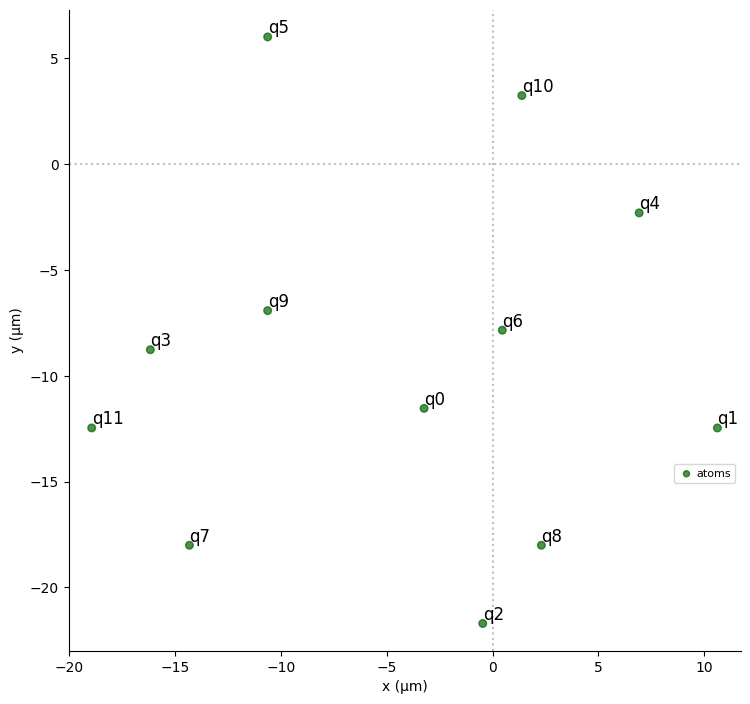

QAA lowest cost -2.5461281306980377, lowest cost (found classically) : -46.22615411293201
Ratio QAA/classic : 0.9449201825339447
clustering=6 radius=6



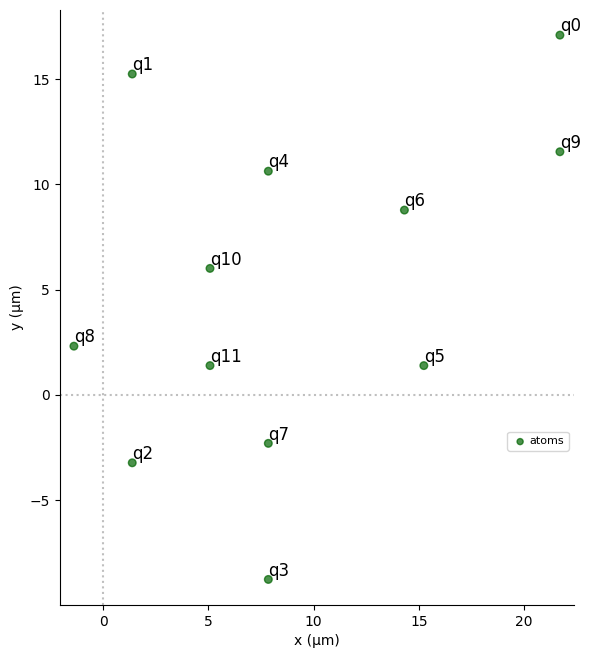

QAA lowest cost -22.922882656269106, lowest cost (found classically) : -42.619719864654364
Ratio QAA/classic : 0.46215313641046135
clustering=6 radius=7



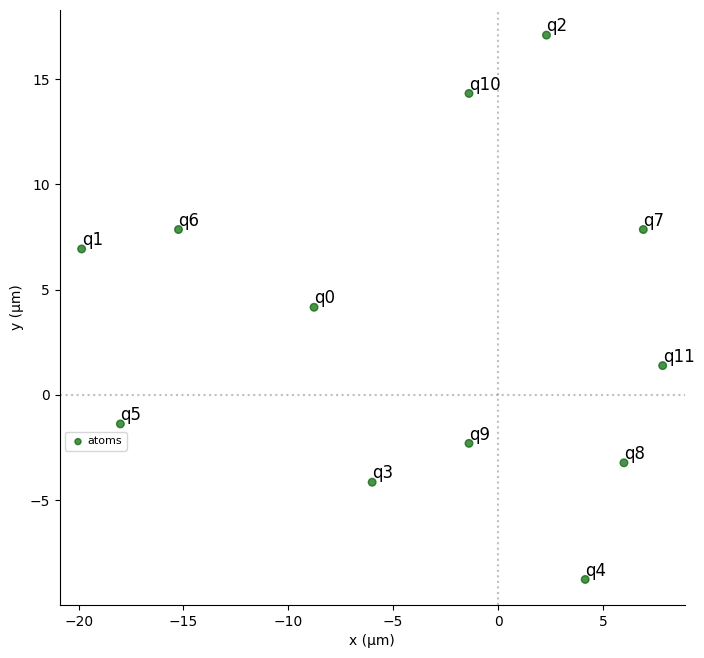

QAA lowest cost -2.6564617133840445, lowest cost (found classically) : -38.01122272178044
Ratio QAA/classic : 0.9301137526454287
clustering=6 radius=8



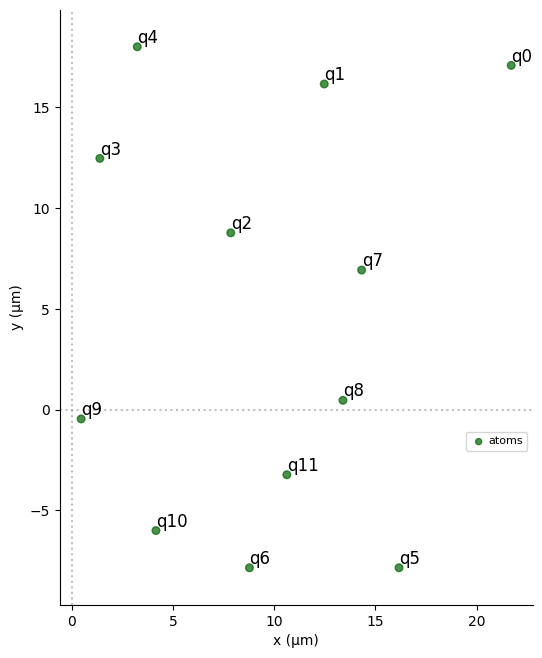

QAA lowest cost -5.942783115784102, lowest cost (found classically) : -43.78688228352056
Ratio QAA/classic : 0.8642793730481994
clustering=6 radius=9



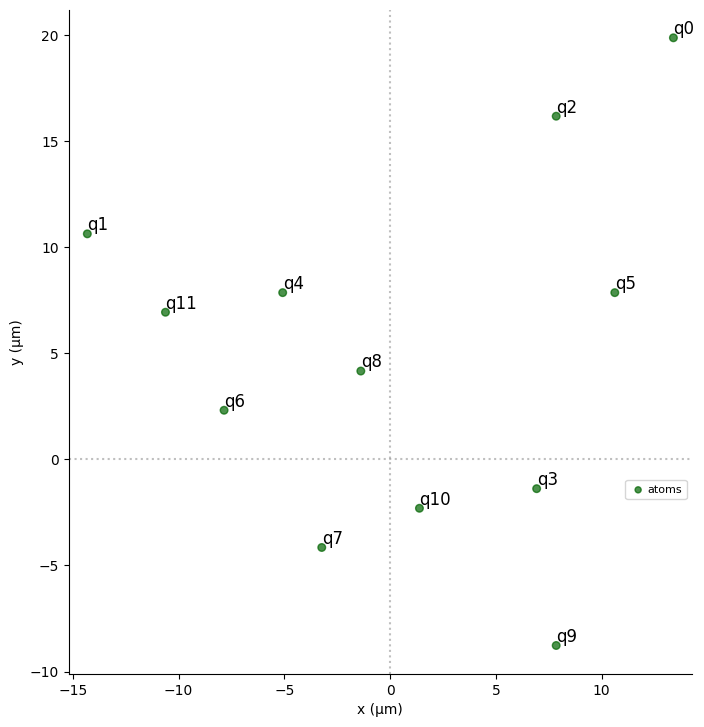

QAA lowest cost -6.885727848493168, lowest cost (found classically) : -42.13979443062346
Ratio QAA/classic : 0.8365979724977198
clustering=6 radius=10



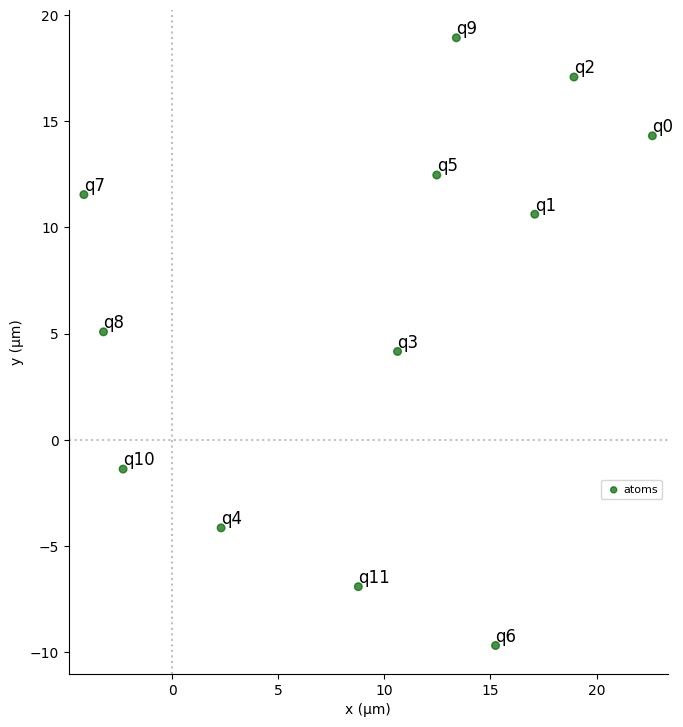

QAA lowest cost -1.7862870786913774, lowest cost (found classically) : -43.741037711519866
Ratio QAA/classic : 0.9591622153440376
clustering=6 radius=11



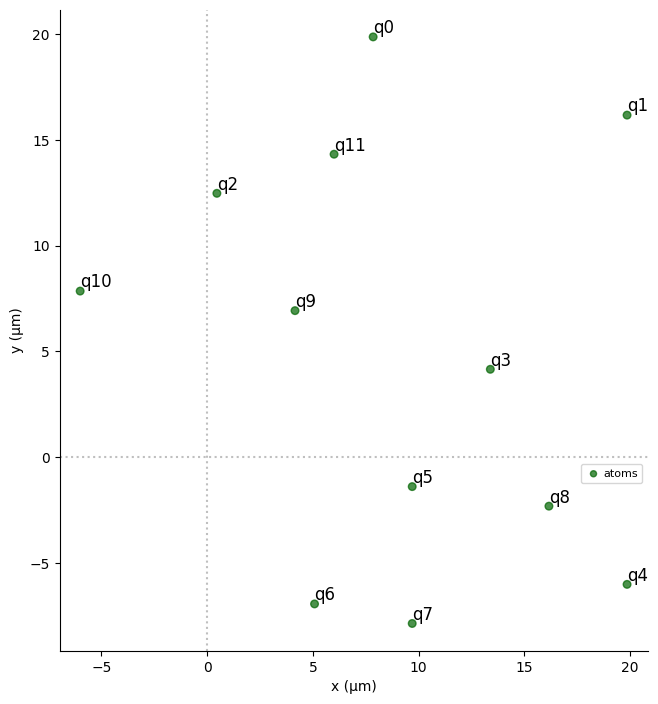

QAA lowest cost -5.576939389671783, lowest cost (found classically) : -47.977438086940644
Ratio QAA/classic : 0.8837591248710336
clustering=6 radius=12



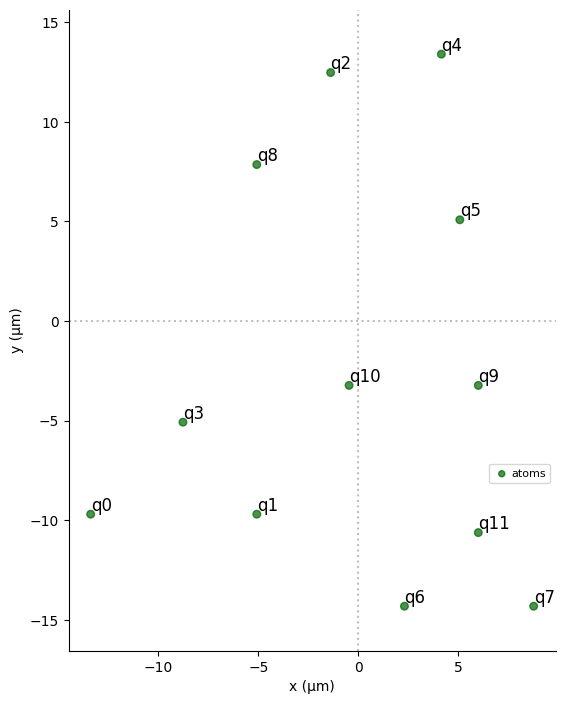

QAA lowest cost -4.4631473348562105, lowest cost (found classically) : -37.07813522081727
Ratio QAA/classic : 0.8796285922073448
clustering=6 radius=13



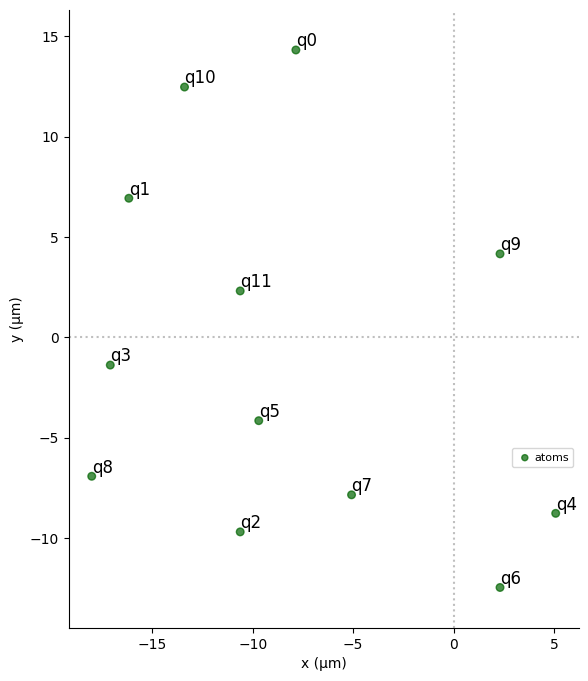

QAA lowest cost -11.612119500506717, lowest cost (found classically) : -40.5071685865054
Ratio QAA/classic : 0.7133317408816575
clustering=6 radius=14



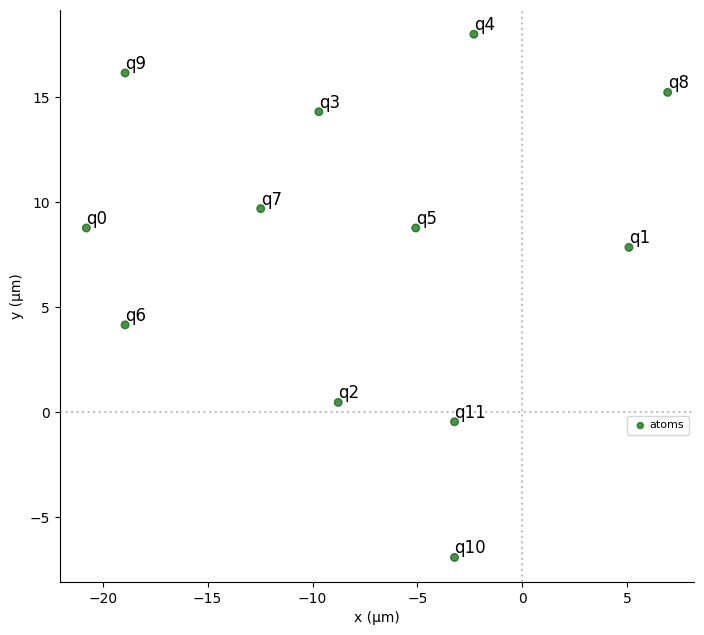

QAA lowest cost -5.02039945521834, lowest cost (found classically) : -42.18953458325848
Ratio QAA/classic : 0.881003677693792
clustering=6 radius=15



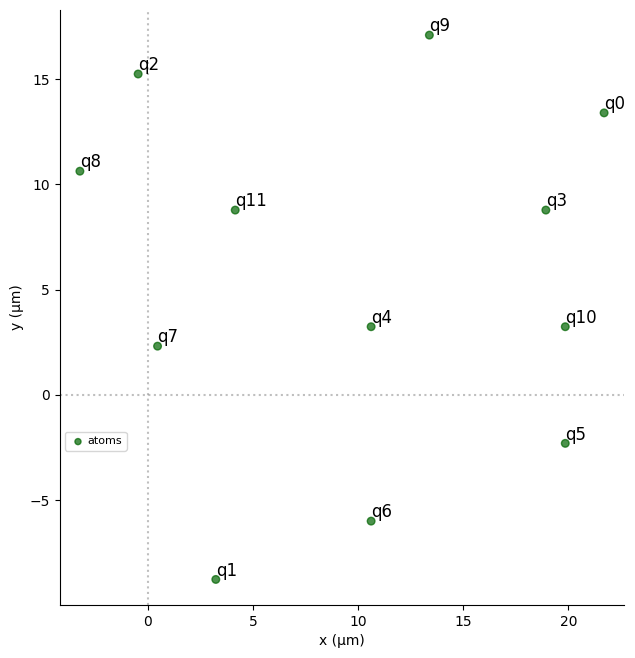

QAA lowest cost -4.21018918520123, lowest cost (found classically) : -41.38737069807715
Ratio QAA/classic : 0.8982735768378532
clustering=6 radius=16



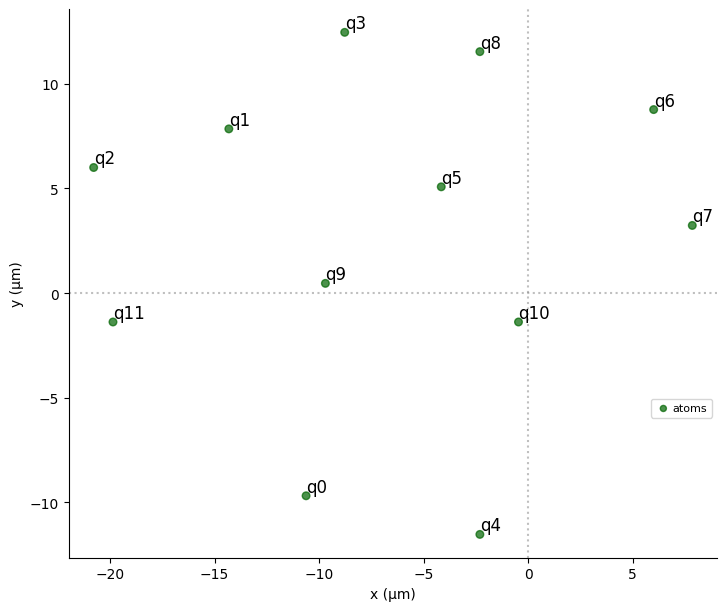

QAA lowest cost -4.784623551631779, lowest cost (found classically) : -40.638226325622696
Ratio QAA/classic : 0.8822629828060423
clustering=6 radius=17



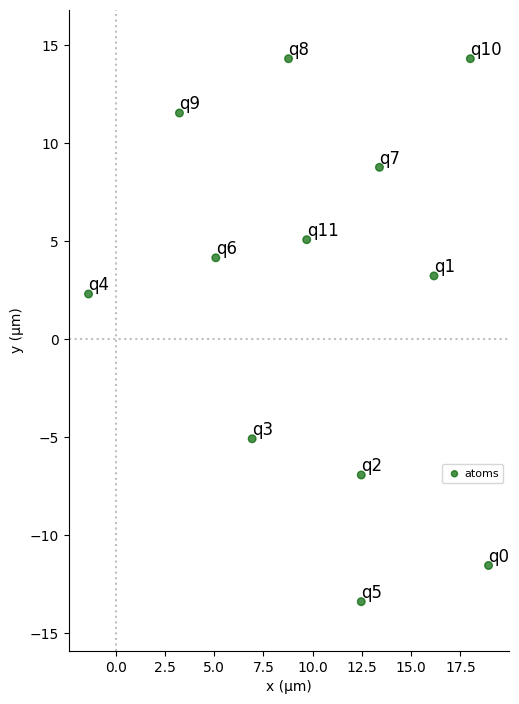

QAA lowest cost -19.2628929175866, lowest cost (found classically) : -36.78471819802473
Ratio QAA/classic : 0.4763343621694244
clustering=6 radius=18



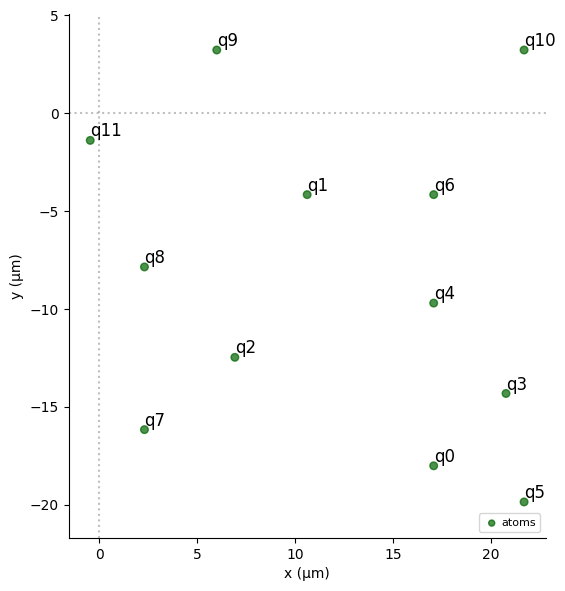

QAA lowest cost -8.271453298972585, lowest cost (found classically) : -40.633231011821124
Ratio QAA/classic : 0.7964362396737233
clustering=6 radius=19



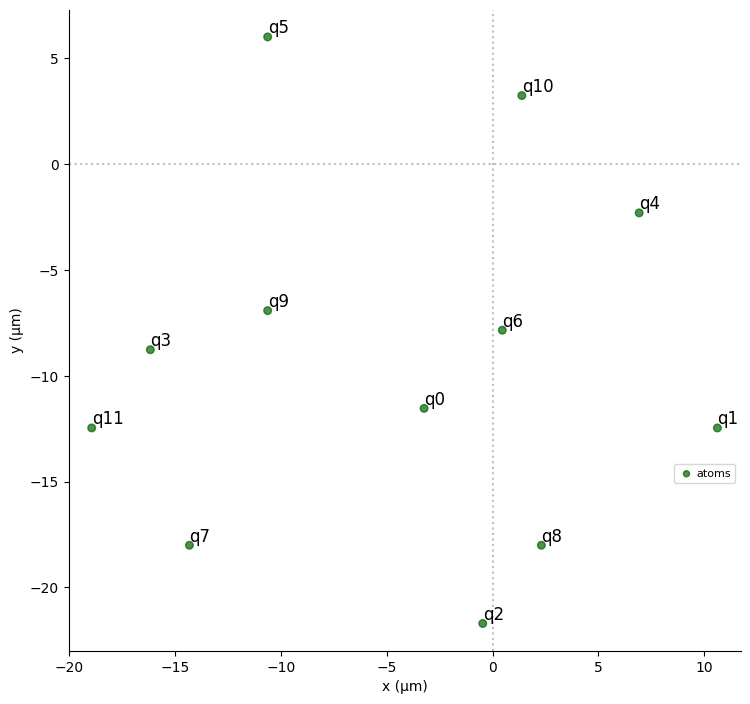

QAA lowest cost -2.5461281306980377, lowest cost (found classically) : -46.22615411293201
Ratio QAA/classic : 0.9449201825339447
clustering=7 radius=6



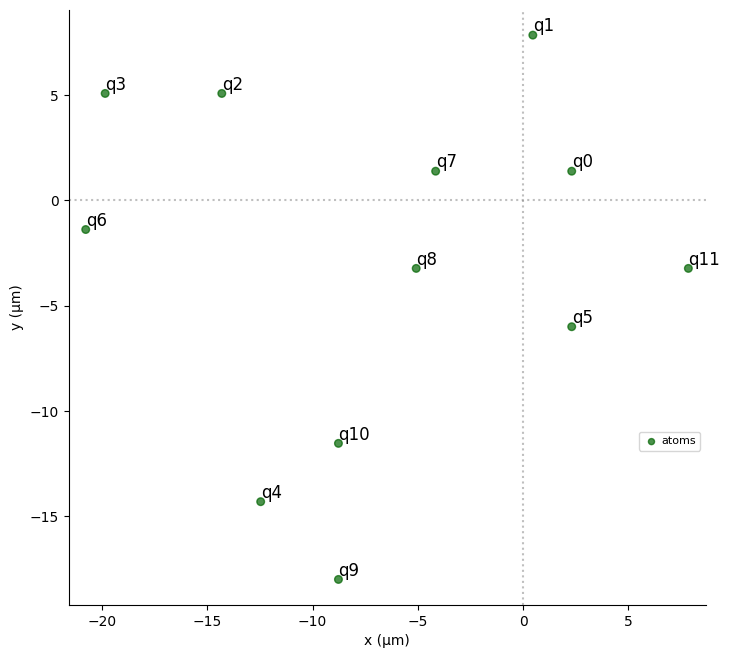

QAA lowest cost -3.588850660284319, lowest cost (found classically) : -41.102093553748176
Ratio QAA/classic : 0.912684480278571
clustering=7 radius=7



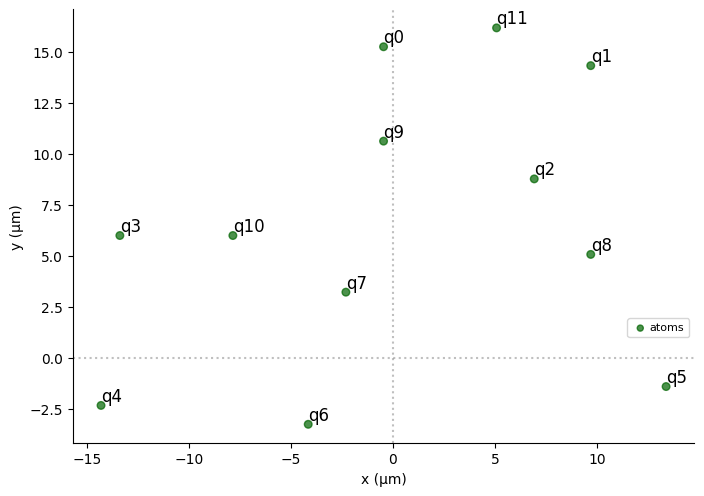

QAA lowest cost -14.91800362628149, lowest cost (found classically) : -36.99768264008137
Ratio QAA/classic : 0.5967854589324982
clustering=7 radius=8



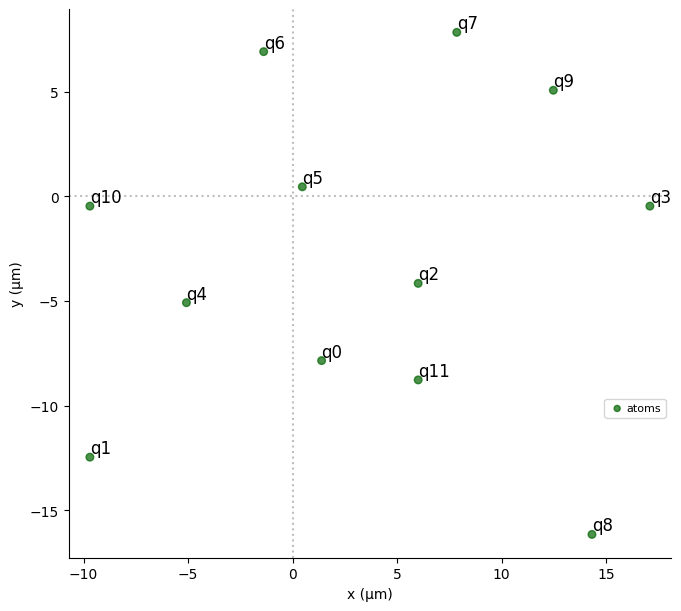

QAA lowest cost -9.309550586122388, lowest cost (found classically) : -45.14864919737227
Ratio QAA/classic : 0.7938022343608848
clustering=7 radius=9



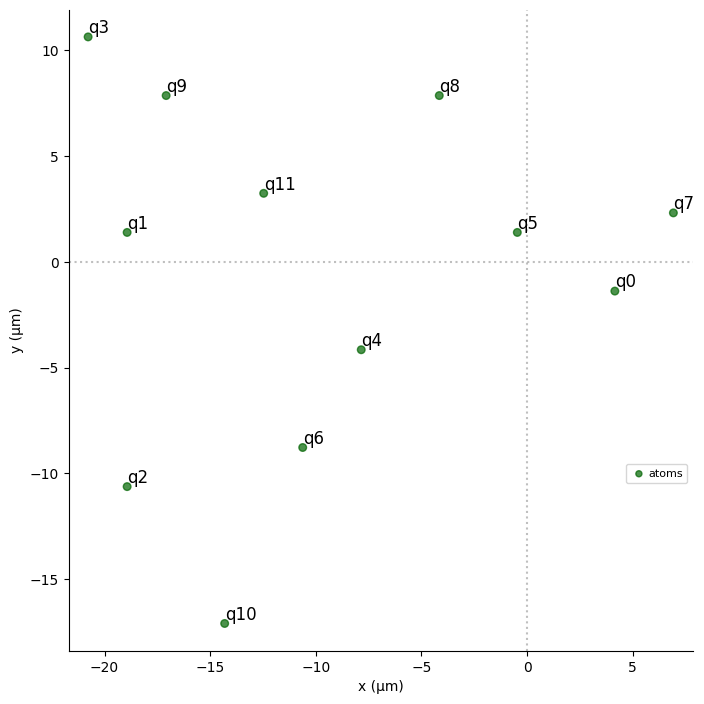

QAA lowest cost -3.737810113285989, lowest cost (found classically) : -41.69402490178791
Ratio QAA/classic : 0.9103514203272396
clustering=7 radius=10



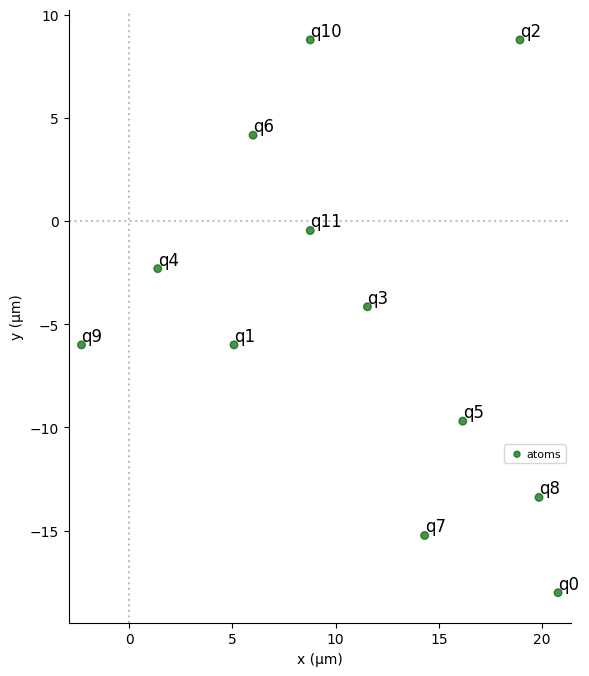

QAA lowest cost -16.359182718286505, lowest cost (found classically) : -36.942857709821375
Ratio QAA/classic : 0.5571760353033717
clustering=7 radius=11



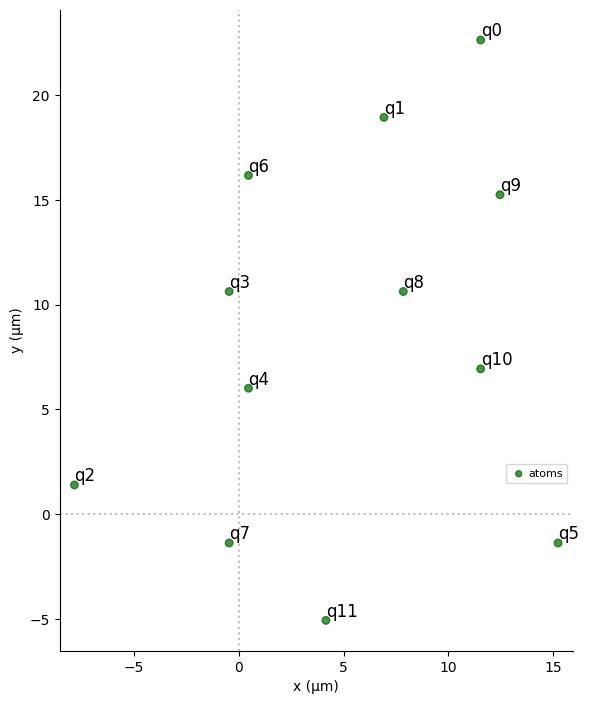

QAA lowest cost -14.13938393169581, lowest cost (found classically) : -41.81340893970558
Ratio QAA/classic : 0.6618457023658457
clustering=7 radius=12



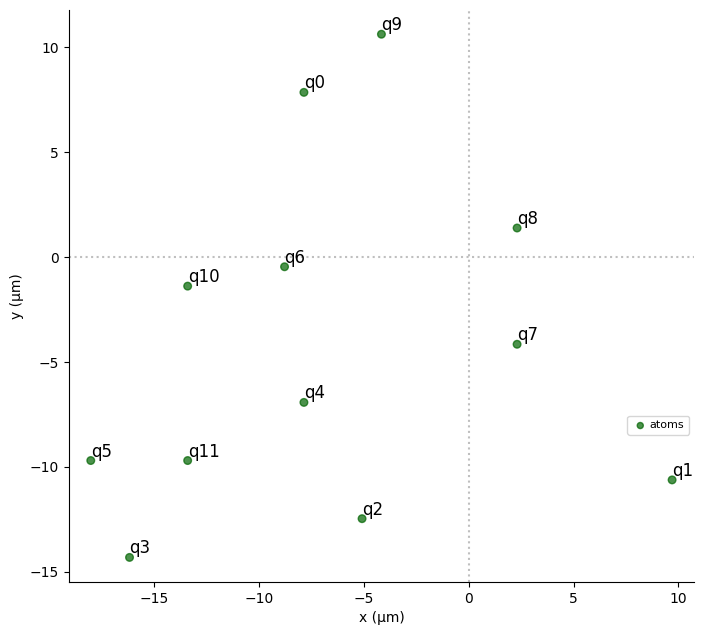

QAA lowest cost -15.360020680772985, lowest cost (found classically) : -40.8829420474269
Ratio QAA/classic : 0.6242926777883463
clustering=7 radius=13



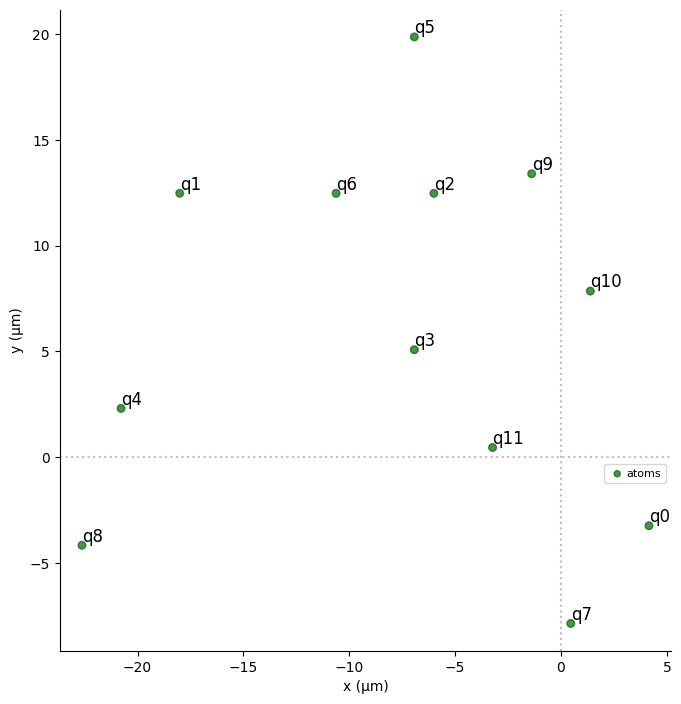

QAA lowest cost -8.682991149665268, lowest cost (found classically) : -45.481805541355
Ratio QAA/classic : 0.8090886884037589
clustering=7 radius=14



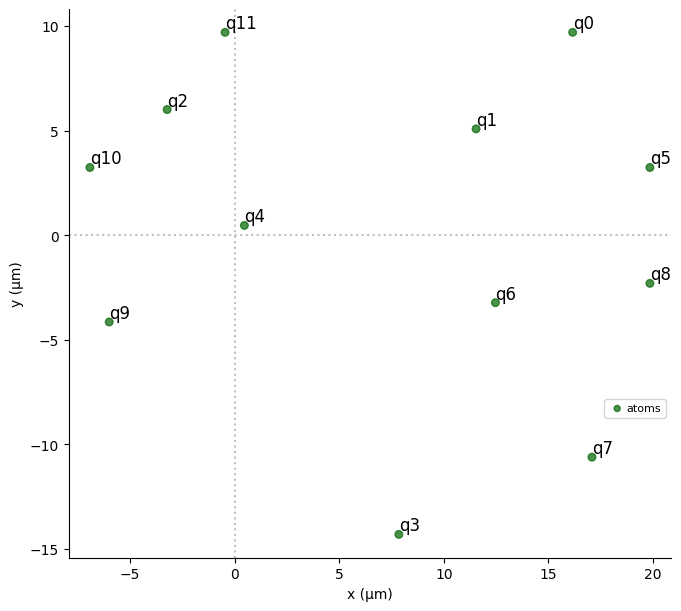

QAA lowest cost -1.6278387018950773, lowest cost (found classically) : -44.65823570742647
Ratio QAA/classic : 0.9635489697228595
clustering=7 radius=15



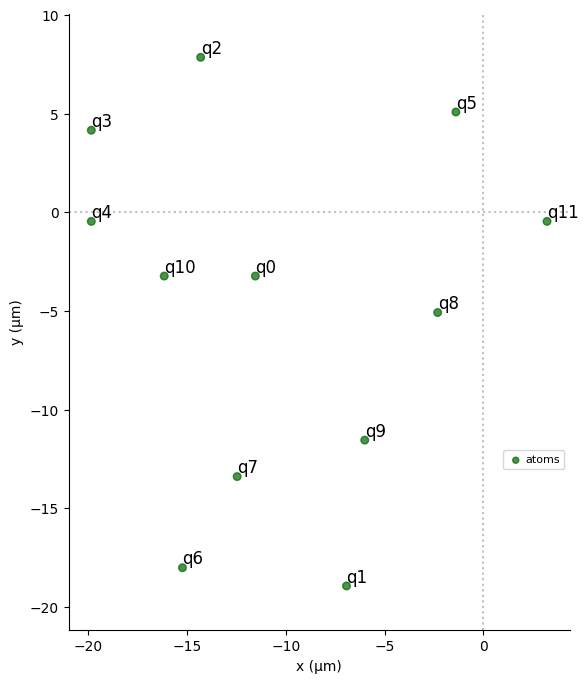

QAA lowest cost -8.326429151001431, lowest cost (found classically) : -34.388173687127164
Ratio QAA/classic : 0.7578693993243864
clustering=7 radius=16



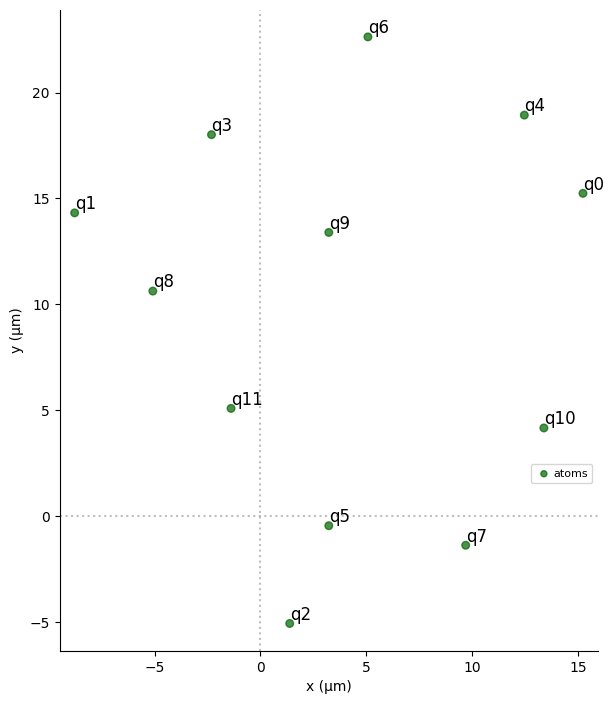

QAA lowest cost -5.399042317503404, lowest cost (found classically) : -39.91106394414031
Ratio QAA/classic : 0.8647231673638186
clustering=7 radius=17



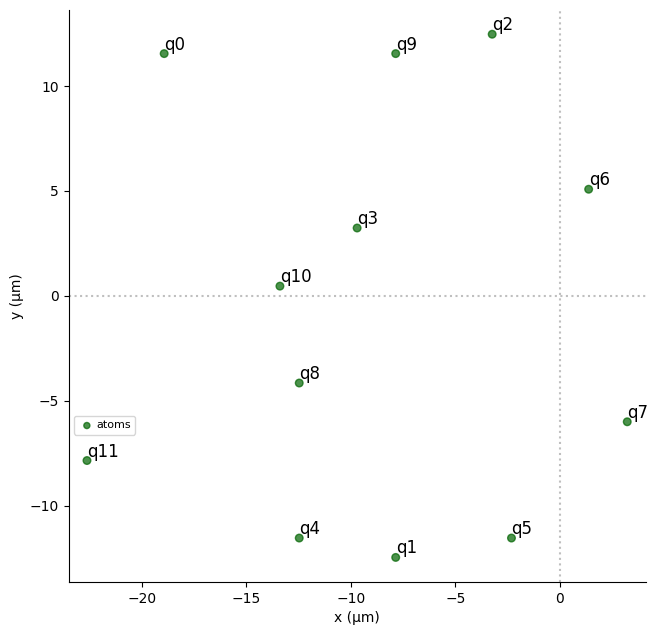

QAA lowest cost -4.648456161066527, lowest cost (found classically) : -47.146971681307264
Ratio QAA/classic : 0.9014049896462484
clustering=7 radius=18



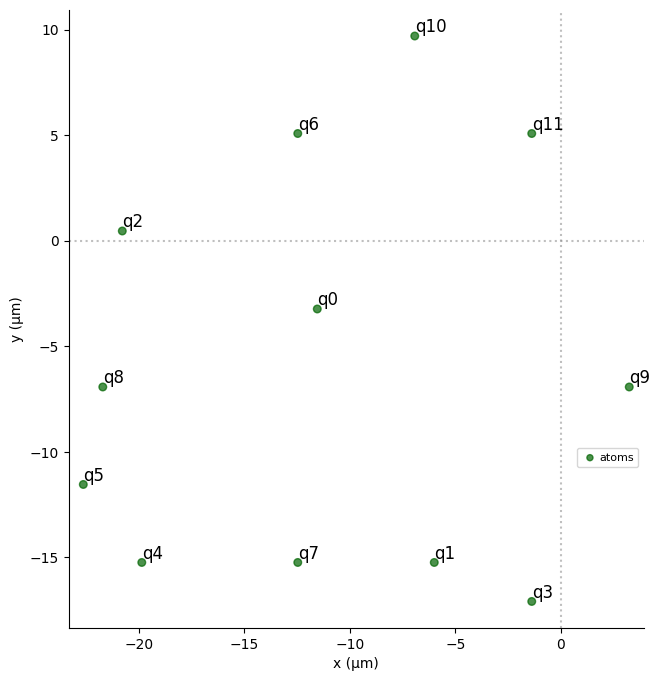

QAA lowest cost -1.5540017692993577, lowest cost (found classically) : -43.829902729220365
Ratio QAA/classic : 0.9645447132543294
clustering=7 radius=19



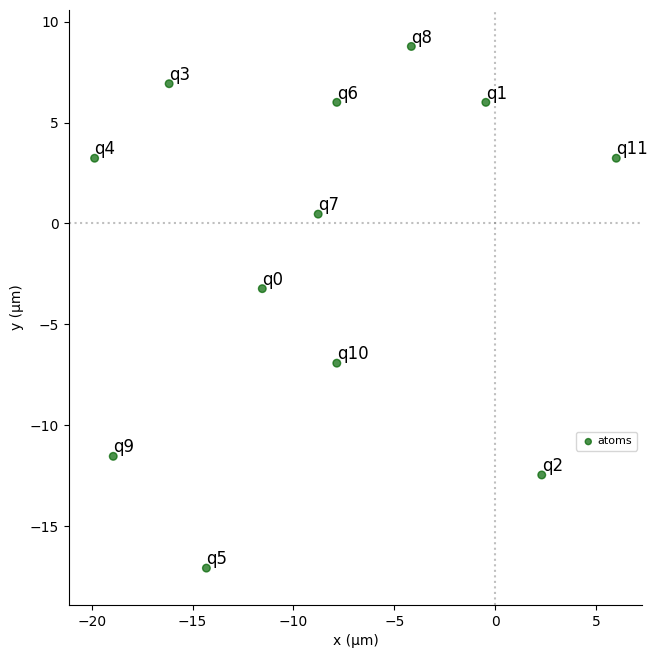

QAA lowest cost -5.918559418382296, lowest cost (found classically) : -44.125694206504924
Ratio QAA/classic : 0.8658704520163721
clustering=8 radius=6



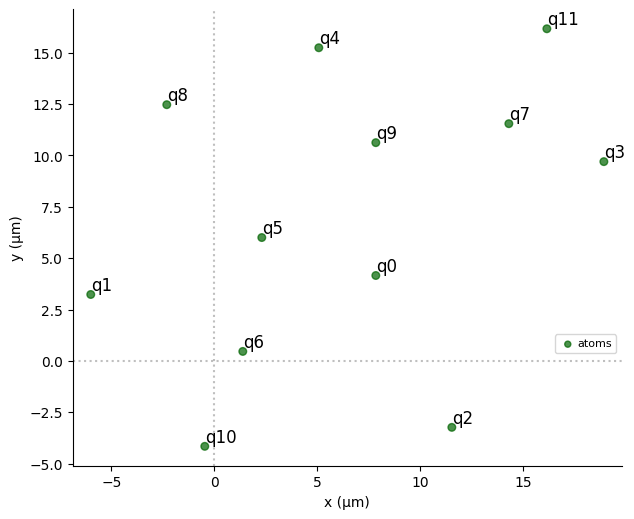

QAA lowest cost -23.890003674924397, lowest cost (found classically) : -36.970598307803186
Ratio QAA/classic : 0.3538107369530435
clustering=8 radius=7



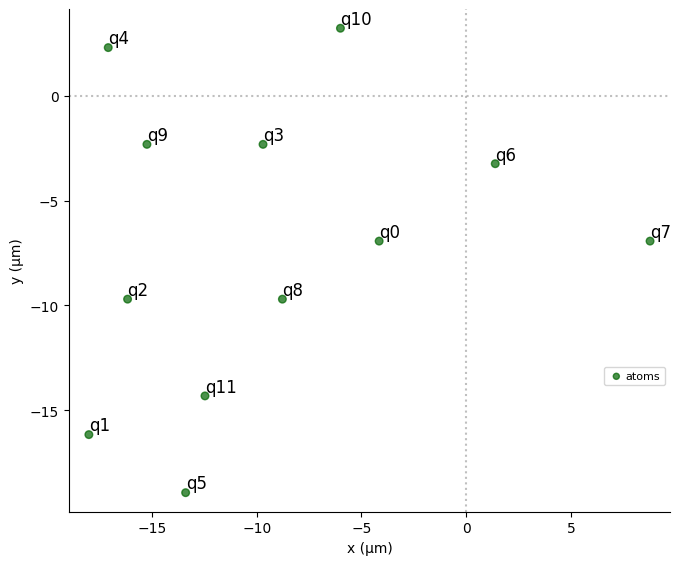

QAA lowest cost -25.734903165152307, lowest cost (found classically) : -36.18064556316797
Ratio QAA/classic : 0.28871077990519517
clustering=8 radius=8



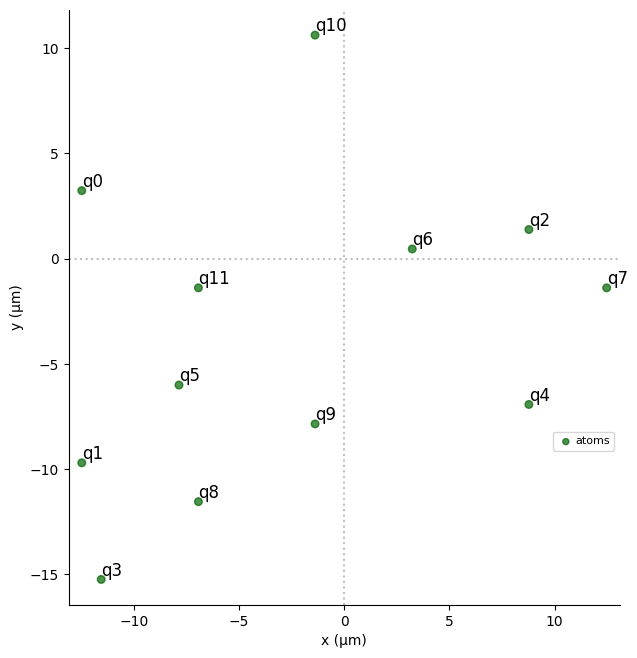

QAA lowest cost -8.455695463883961, lowest cost (found classically) : -42.80222060846204
Ratio QAA/classic : 0.8024472715742168
clustering=8 radius=9



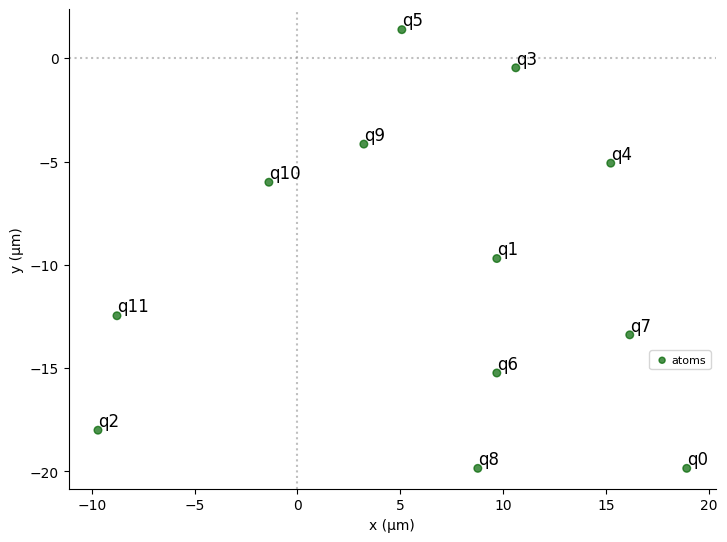

QAA lowest cost -9.900524270194841, lowest cost (found classically) : -37.41472594402116
Ratio QAA/classic : 0.7353842899983358
clustering=8 radius=10



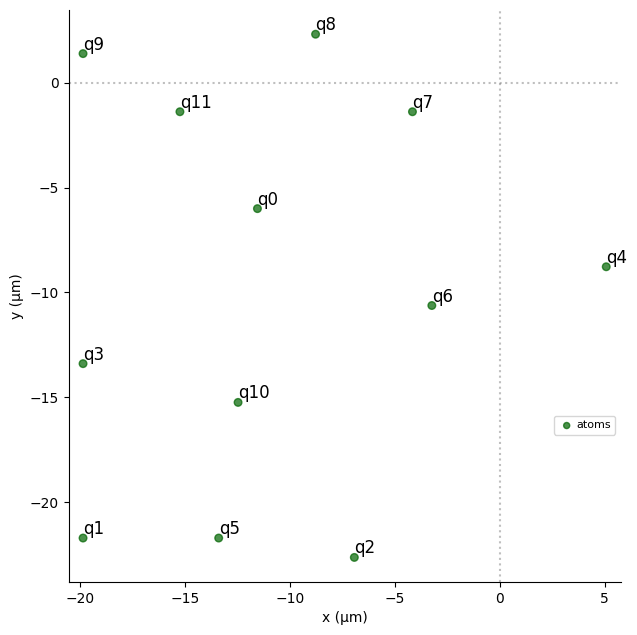

QAA lowest cost -4.479708840663768, lowest cost (found classically) : -42.99015401801782
Ratio QAA/classic : 0.8957968645847081
clustering=8 radius=11



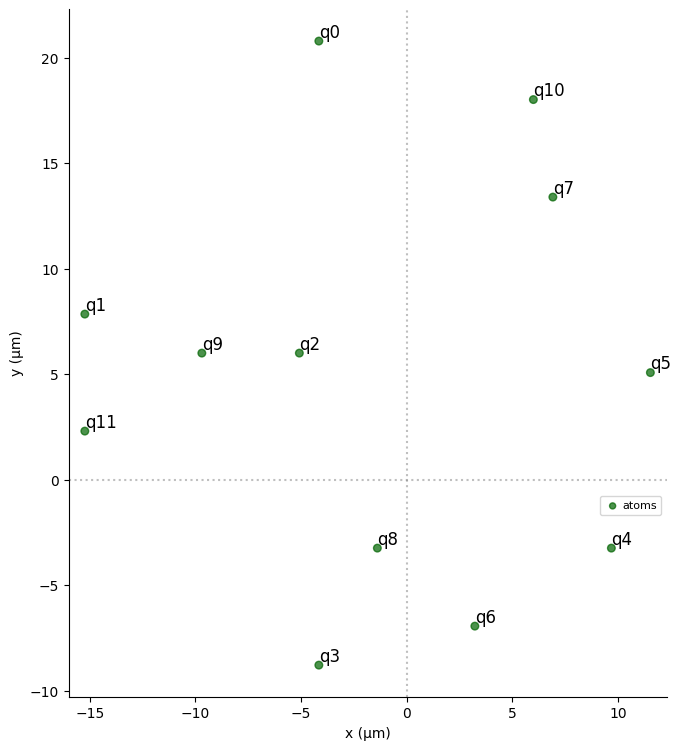

QAA lowest cost -1.8455288313399467, lowest cost (found classically) : -45.79923059140376
Ratio QAA/classic : 0.9597039337231499
clustering=8 radius=12



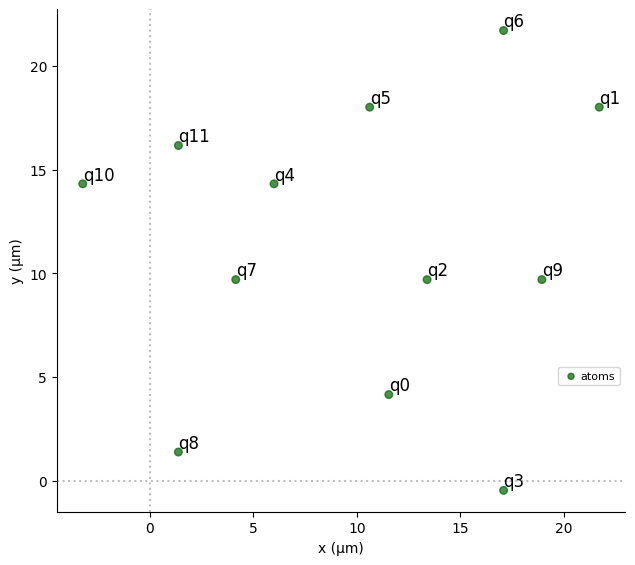

QAA lowest cost -17.533017273156773, lowest cost (found classically) : -39.82147676550271
Ratio QAA/classic : 0.5597095161386481
clustering=8 radius=13



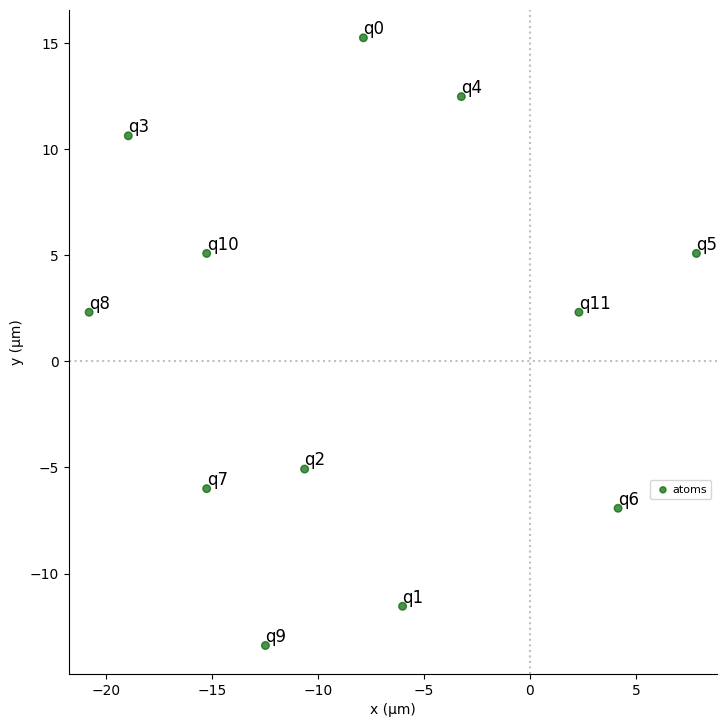

QAA lowest cost -0.7889772274360138, lowest cost (found classically) : -45.88083586240399
Ratio QAA/classic : 0.9828037738936983
clustering=8 radius=14



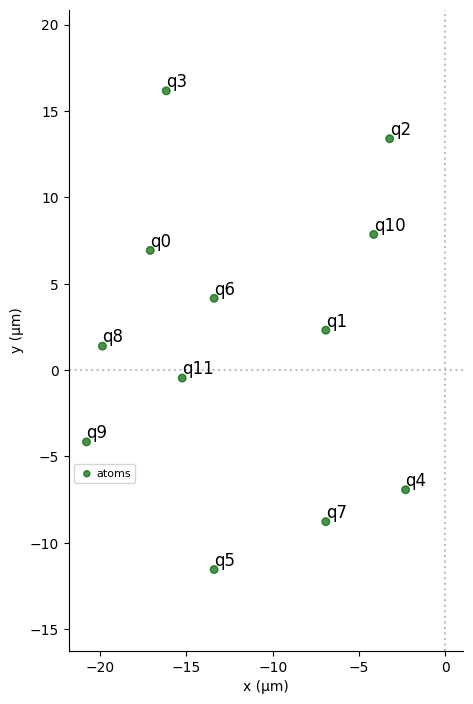

QAA lowest cost -11.217976938284218, lowest cost (found classically) : -41.71655744078188
Ratio QAA/classic : 0.7310905399083198
clustering=8 radius=15



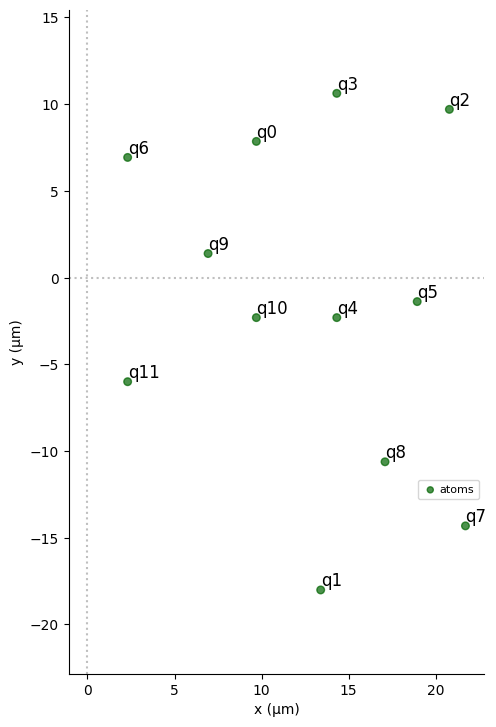

QAA lowest cost -18.817650425411365, lowest cost (found classically) : -40.719517100030934
Ratio QAA/classic : 0.5378714737902167
clustering=8 radius=16



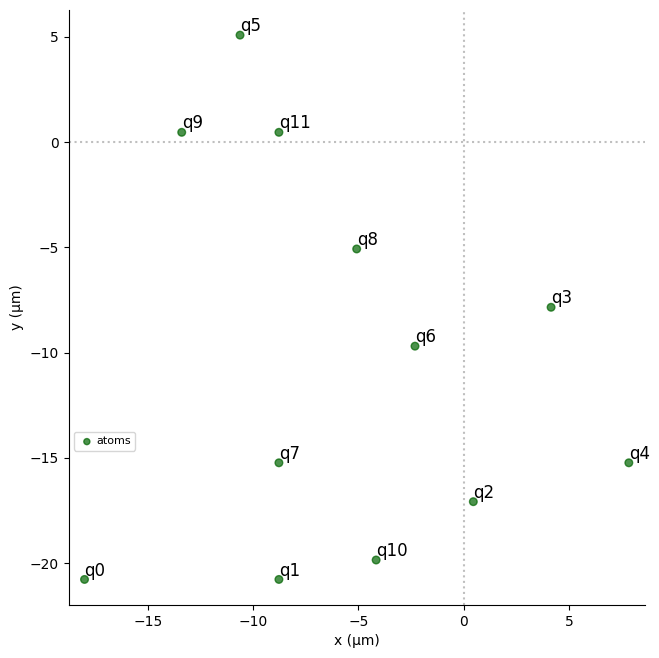

QAA lowest cost -8.096438985089177, lowest cost (found classically) : -39.72757763063717
Ratio QAA/classic : 0.7962010404871663
clustering=8 radius=17



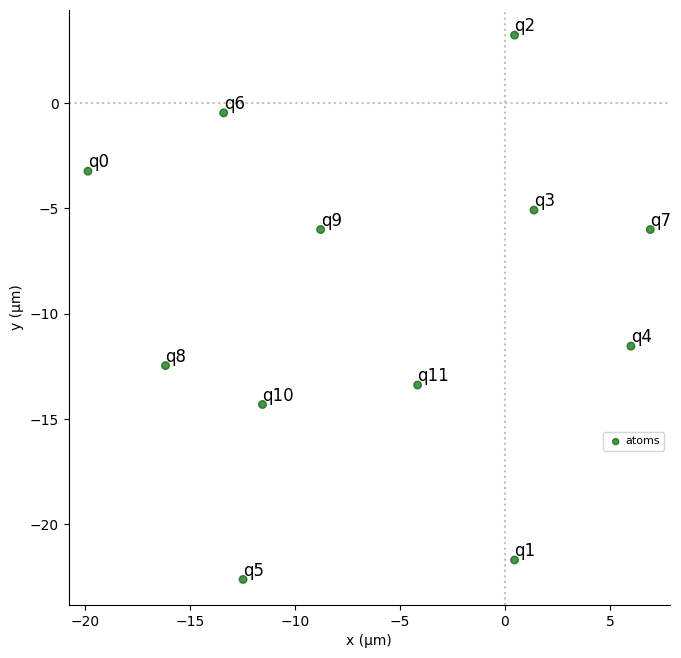

QAA lowest cost -4.791176688097446, lowest cost (found classically) : -43.52144611912669
Ratio QAA/classic : 0.8899122819820128
clustering=8 radius=18



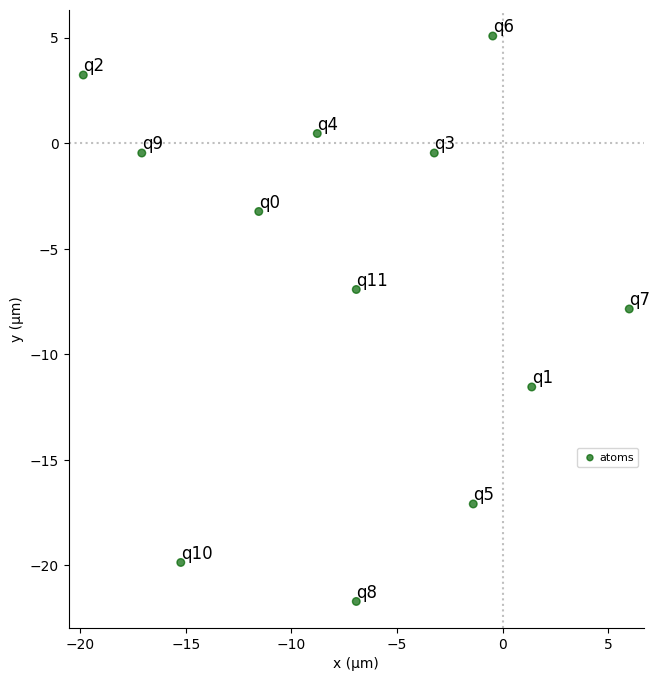

QAA lowest cost -5.119847321647848, lowest cost (found classically) : -43.16484952523673
Ratio QAA/classic : 0.8813885052777845
clustering=8 radius=19



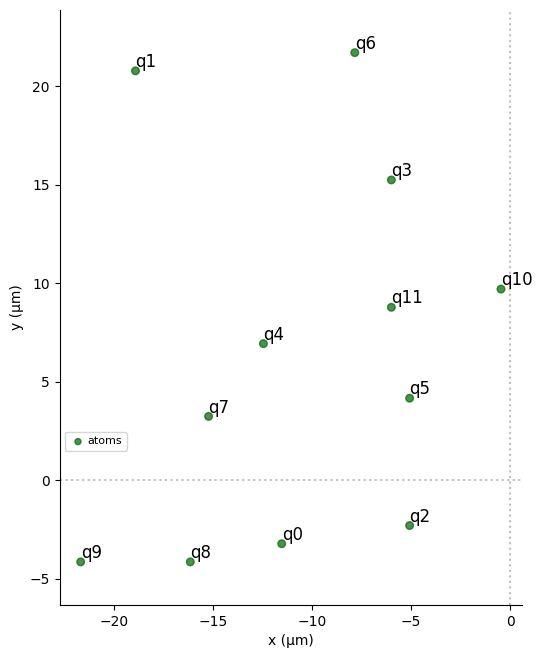

QAA lowest cost -18.751802507460287, lowest cost (found classically) : -39.81363711390367
Ratio QAA/classic : 0.5290105635460317
clustering=9 radius=6



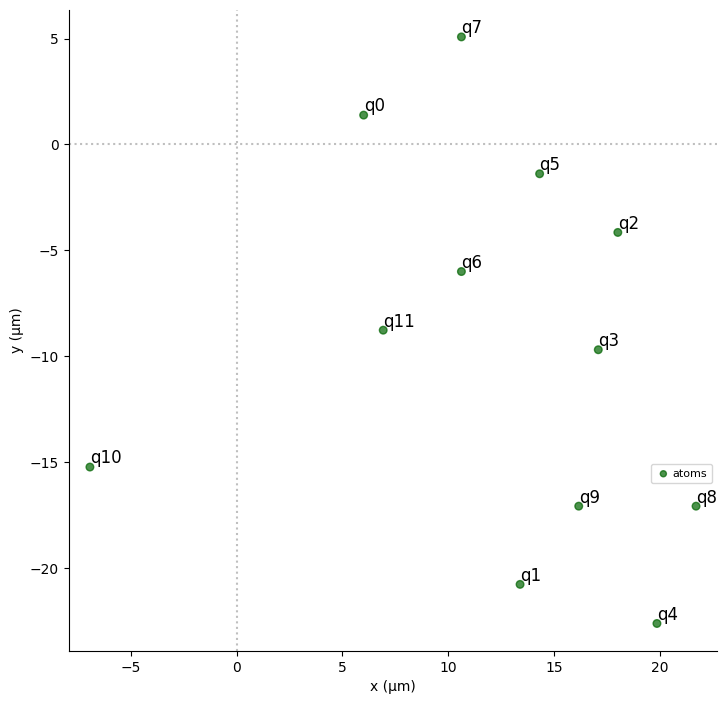

QAA lowest cost -15.369465410097865, lowest cost (found classically) : -39.728892952595615
Ratio QAA/classic : 0.6131413621709353
clustering=9 radius=7



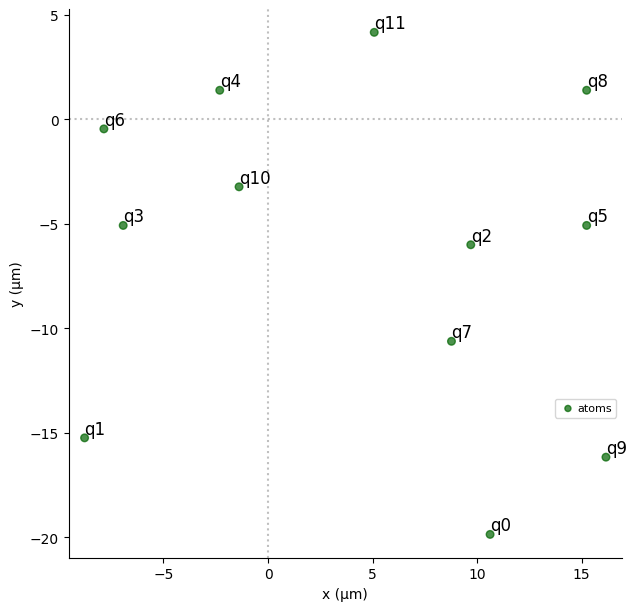

QAA lowest cost -4.25734036506753, lowest cost (found classically) : -44.53956821351468
Ratio QAA/classic : 0.9044144221457513
clustering=9 radius=8



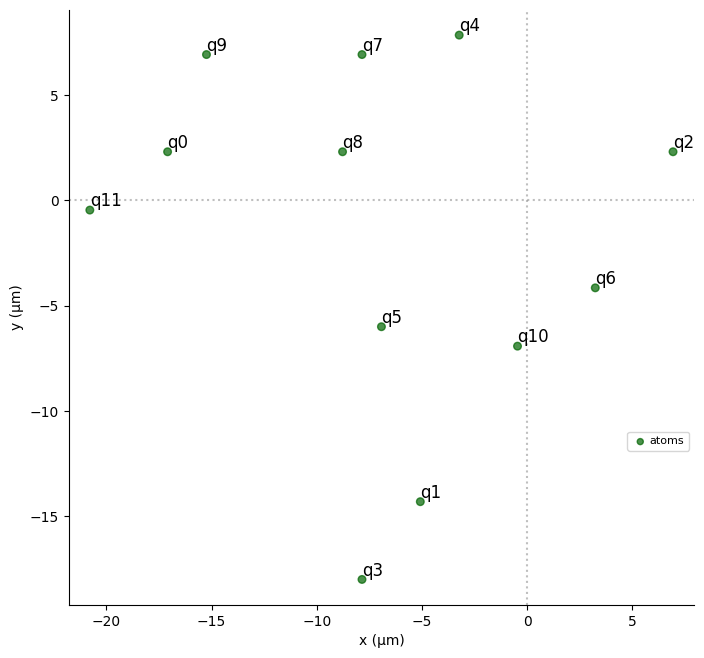

QAA lowest cost -8.52787239232028, lowest cost (found classically) : -41.26631177488329
Ratio QAA/classic : 0.7933454184410355
clustering=9 radius=9



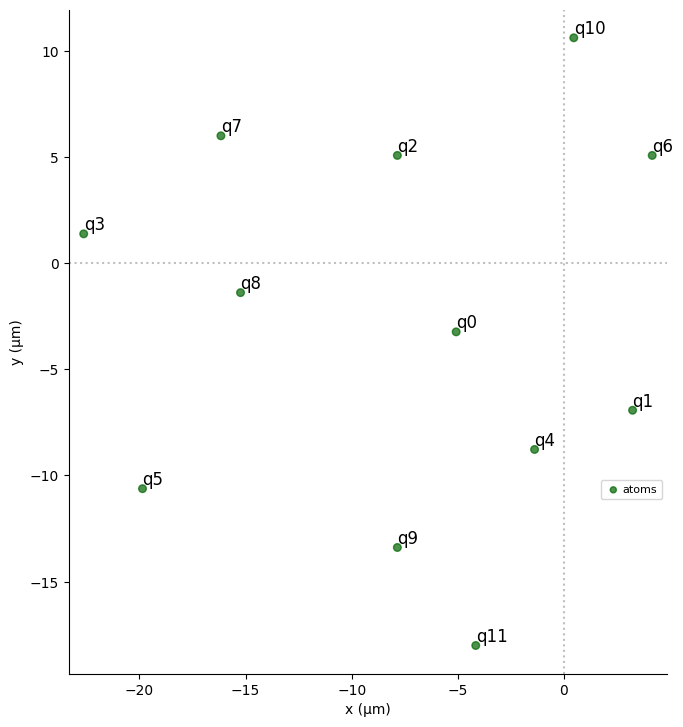

QAA lowest cost -2.7102915563891687, lowest cost (found classically) : -46.26378268539786
Ratio QAA/classic : 0.9414165595835593
clustering=9 radius=10



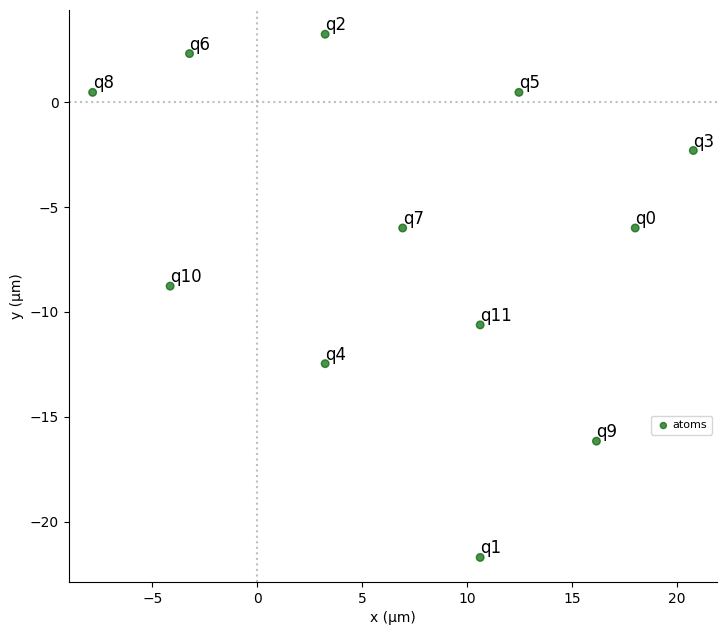

QAA lowest cost -4.471031984234898, lowest cost (found classically) : -40.464407639613306
Ratio QAA/classic : 0.8895070447081522
clustering=9 radius=11



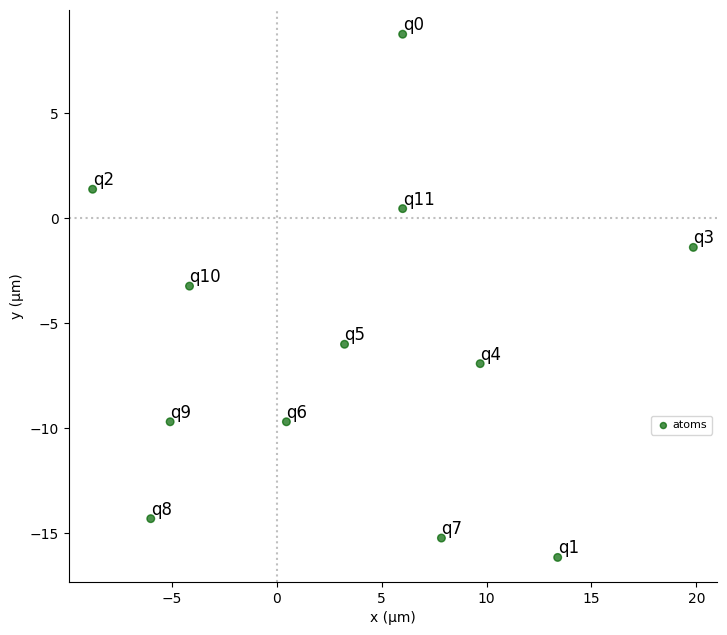

QAA lowest cost -10.123484710662263, lowest cost (found classically) : -50.53381793708806
Ratio QAA/classic : 0.7996691102329638
clustering=9 radius=12



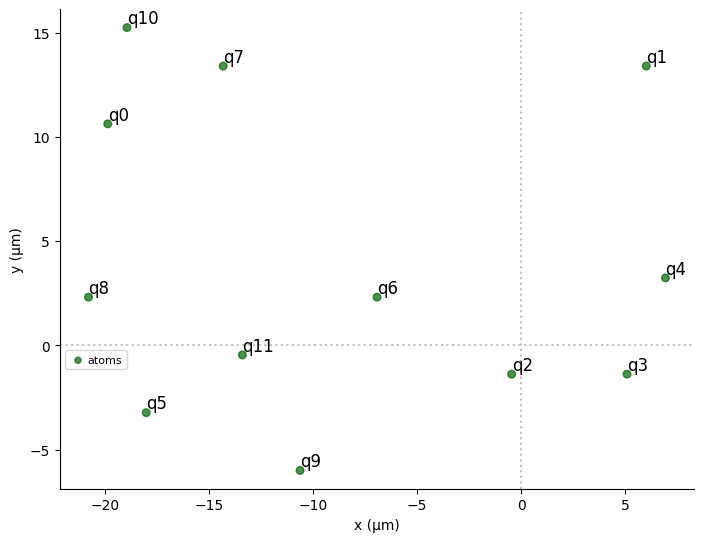

QAA lowest cost -2.8675805654426325, lowest cost (found classically) : -43.87393443264571
Ratio QAA/classic : 0.9346404510440048
clustering=9 radius=13



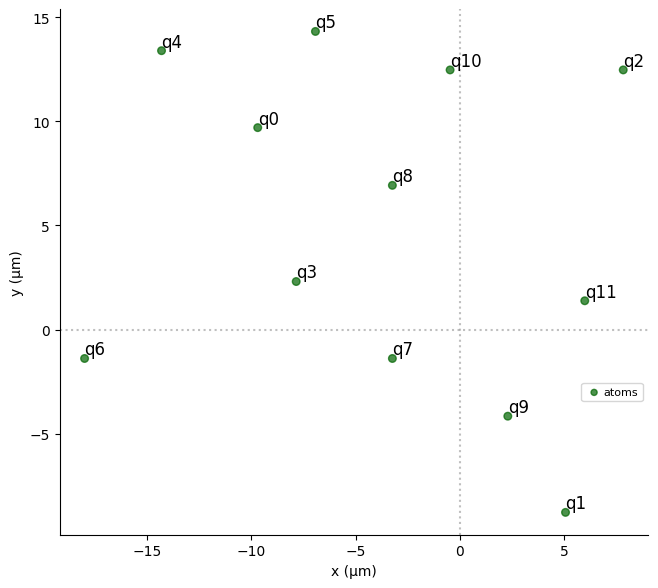

QAA lowest cost -16.64940231833155, lowest cost (found classically) : -42.615823334470484
Ratio QAA/classic : 0.6093140759558101
clustering=9 radius=14



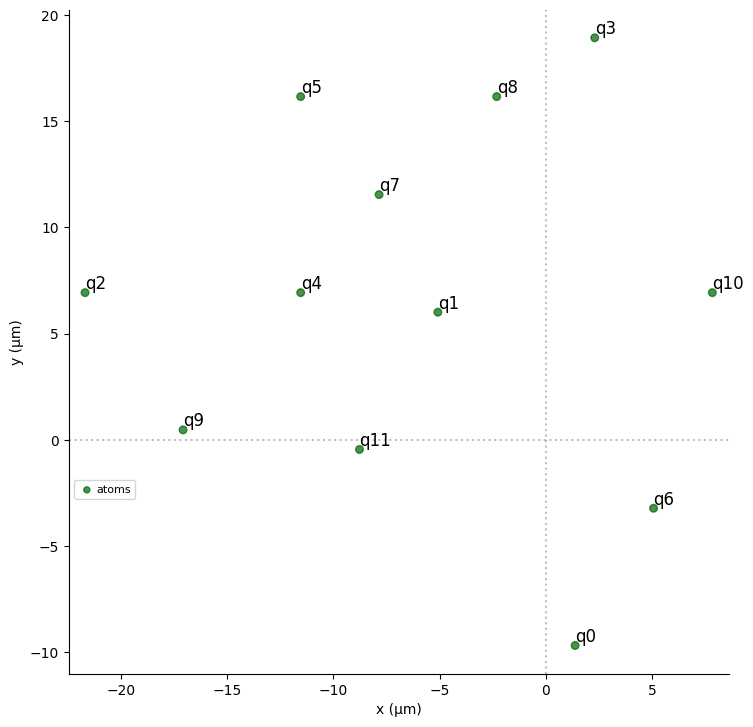

QAA lowest cost -8.32115576385832, lowest cost (found classically) : -50.96876479877474
Ratio QAA/classic : 0.8367400937277892
clustering=9 radius=15



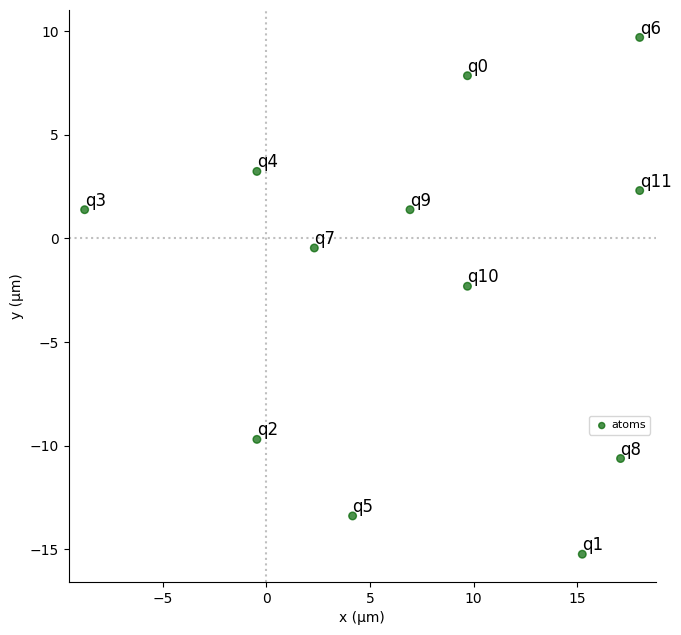

QAA lowest cost -9.291293238308459, lowest cost (found classically) : -43.64732369651379
Ratio QAA/classic : 0.7871279966003831
clustering=9 radius=16



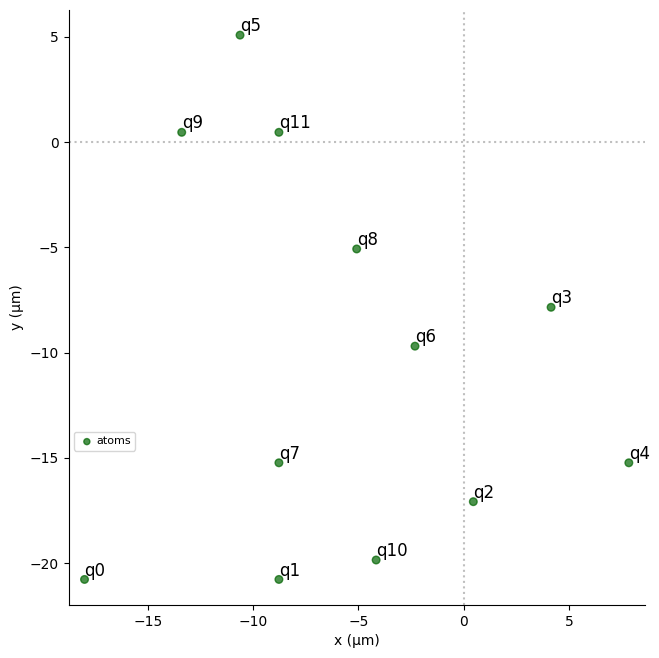

QAA lowest cost -8.096438985089177, lowest cost (found classically) : -39.72757763063717
Ratio QAA/classic : 0.7962010404871663
clustering=9 radius=17



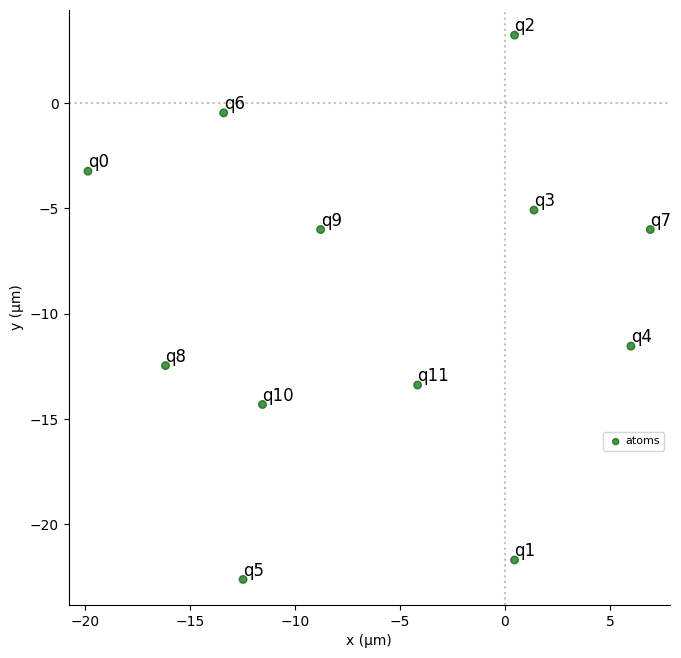

QAA lowest cost -4.791176688097446, lowest cost (found classically) : -43.52144611912669
Ratio QAA/classic : 0.8899122819820128
clustering=9 radius=18



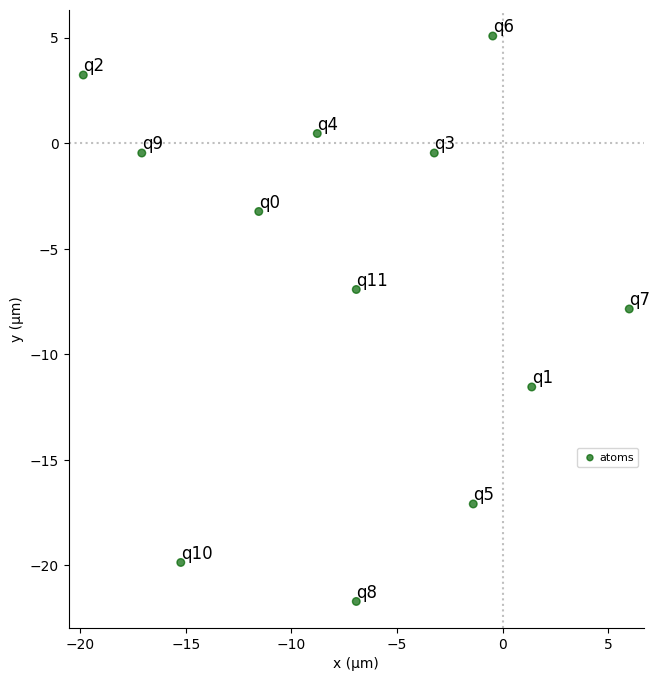

QAA lowest cost -5.119847321647848, lowest cost (found classically) : -43.16484952523673
Ratio QAA/classic : 0.8813885052777845
clustering=9 radius=19



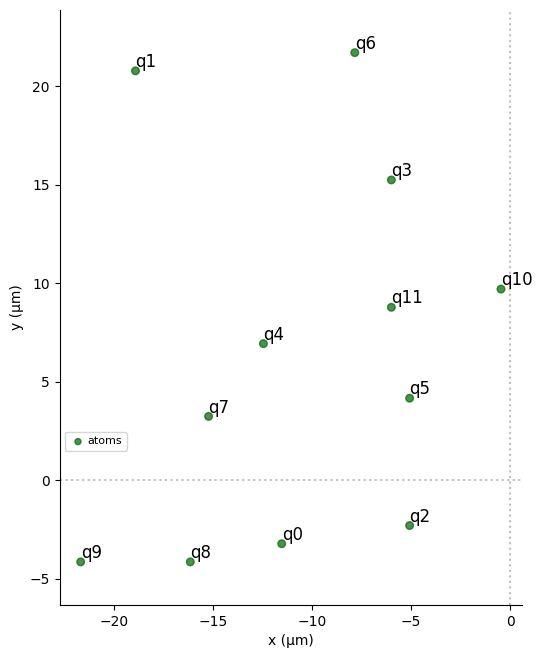

QAA lowest cost -18.751802507460287, lowest cost (found classically) : -39.81363711390367
Ratio QAA/classic : 0.5290105635460317


In [122]:
ratios = []
for i in range(0,10):
    for j in range(6,20):
        print(f"clustering={i} radius={j}\n")
        positions, cluster_centers, weight = generate_grid_clustered_graph(50, i, j, total_atoms=12, min_distance=5.0, minimal_capacity=0.2, max_distance=32.0)
        qubits = {f"q{i}": coord for (i, coord) in enumerate(positions)}
        reg = Register(qubits)
        reg.draw()
        Q_loop = coordinates_to_Q(positions)
        lowest_cost_classic = find_minimum_cost_classic(Q_loop)[0]
        lowest_cost_QAA = find_minimum_cost_QAA(Q_loop)
        ratio = (lowest_cost_QAA-lowest_cost_classic[1])/np.abs(lowest_cost_classic[1])
        print(f"QAA lowest cost {lowest_cost_QAA}, lowest cost (found classically) : {lowest_cost_classic[1]}\nRatio QAA/classic : {ratio}")
        ratios.append({f"clustering={i} radius={j}":ratio})

In [ ]:
labels = [list(d.keys())[0] for d in ratios]
values = [list(d.values())[0] for d in ratios]

import plotly.express as px
import pandas as pd

df = pd.DataFrame({"Label": labels, "Ratio": values})
fig = px.bar(df, x="Label", y="Ratio", title="Performance Ratio of QAA vs Ground State depending on clustering and radius",)
fig.update_layout(xaxis_tickangle=-45, height=600, width=1200)
fig.show()


# Bonus : QAA on a Cat and on a Flower

## Flower 

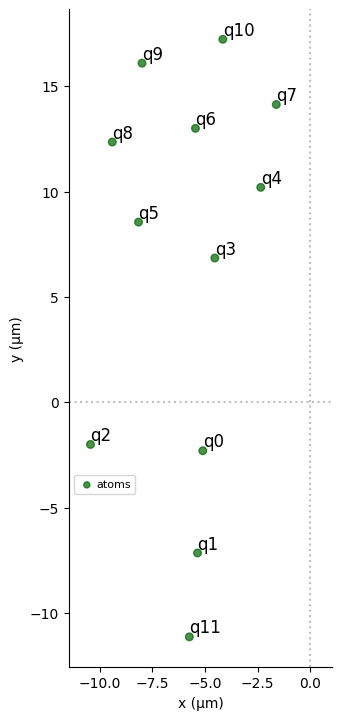

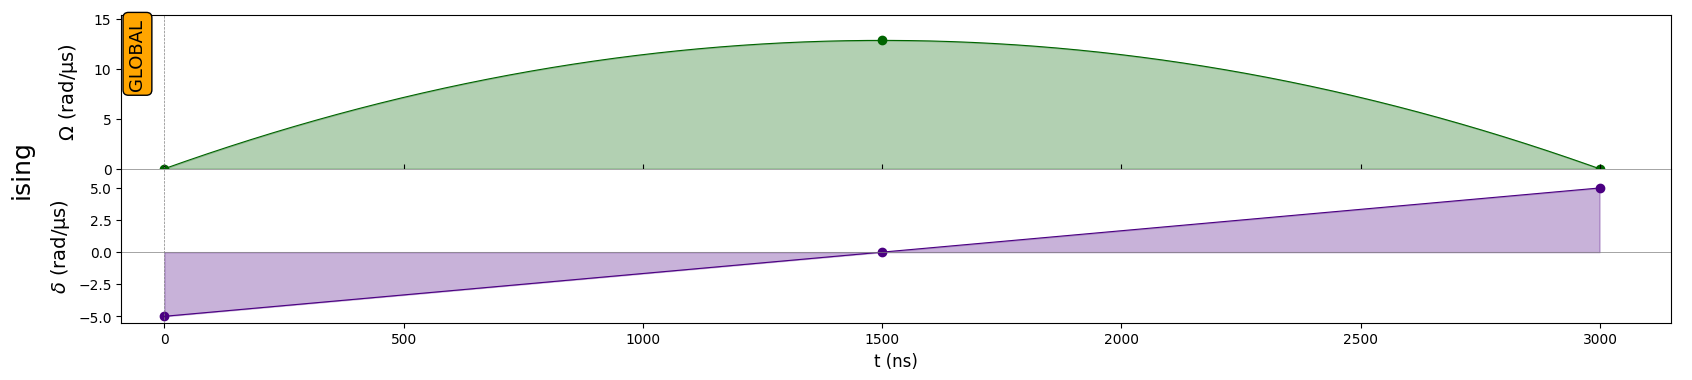

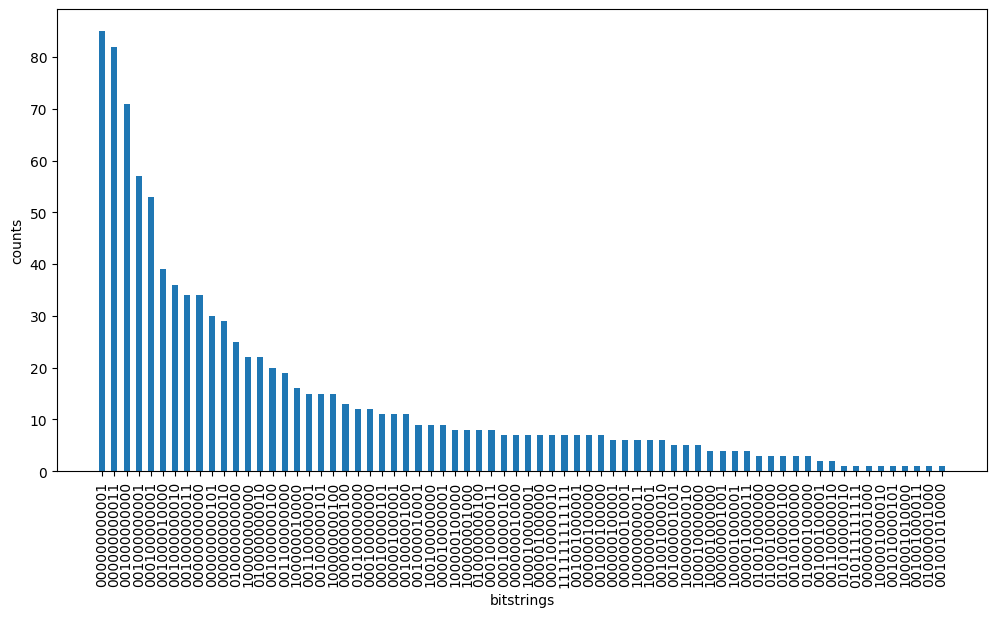

energy : 268.51877965080394


In [100]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 3000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
flower_reg = Register({
  "q0": (-5.1, -2.3),
  "q1": (-5.35, -7.1499999999999995),
  "q2": (-10.429296122005137, -2.00019322719794),
  "q3": (-4.530755649626032, 6.8467471320187725),
  "q4": (-2.35, 10.2),
  "q5": (-8.15, 8.55),
  "q6": (-5.45, 13),
  "q7": (-1.6134001919993728, 14.131592644572121),
  "q8": (-9.396945218792741, 12.350674627132676),
  "q9": (-7.985804877621276, 16.09349214038638),
  "q10": (-4.149205069620649, 17.225084784958504),
  "q11": (-5.739419551920048, -11.130998921449537),
})
flower_reg.draw()
Q_flower = coordinates_to_Q([[-5.1, -2.3],[-5.35, -7.1499999999999995],[-10.429296122005137, -2.00019322719794],[-4.530755649626032, 6.8467471320187725],[-2.35, 10.2],[-8.15, 8.55],[-5.45, 13],[-1.6134001919993728, 14.131592644572121],[-9.396945218792741, 12.350674627132676],[-7.985804877621276, 16.09349214038638],[-4.149205069620649, 17.225084784958504],[-5.739419551920048, -11.130998921449537]])
sequence_QAA_flower = Sequence(flower_reg, DigitalAnalogDevice)
sequence_QAA_flower.declare_channel("ising", "rydberg_global")
sequence_QAA_flower.add(adiabatic_pulse, "ising")
sequence_QAA_flower.draw()
simul_QAA = QutipEmulator.from_sequence(sequence_QAA_flower)
results_QAA = simul_QAA.run()
final_QAA = results_QAA.get_final_state()
count_dict_QAA = results_QAA.sample_final_state()
plot_distribution(count_dict_QAA)
print(f"energy : {get_cost(count_dict_QAA, Q_flower)}")

In [104]:
s_readable = sequence_QAA_flower.to_abstract_repr(
json_dumps_options={"indent": 1},
seq_name=f"flower_qaa_seq_{time.time()}",
)
with open(f"flower_QAA_{time.time()}.json", "w") as f:
    f.write(s_readable)

## Cat

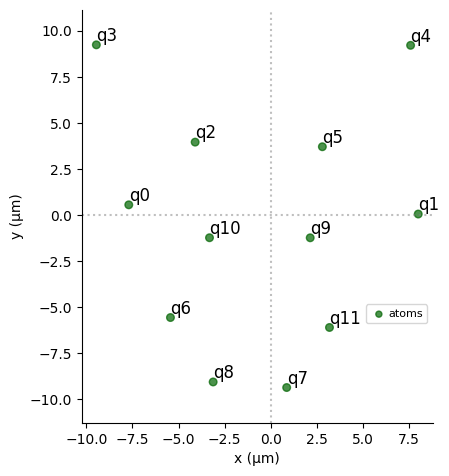

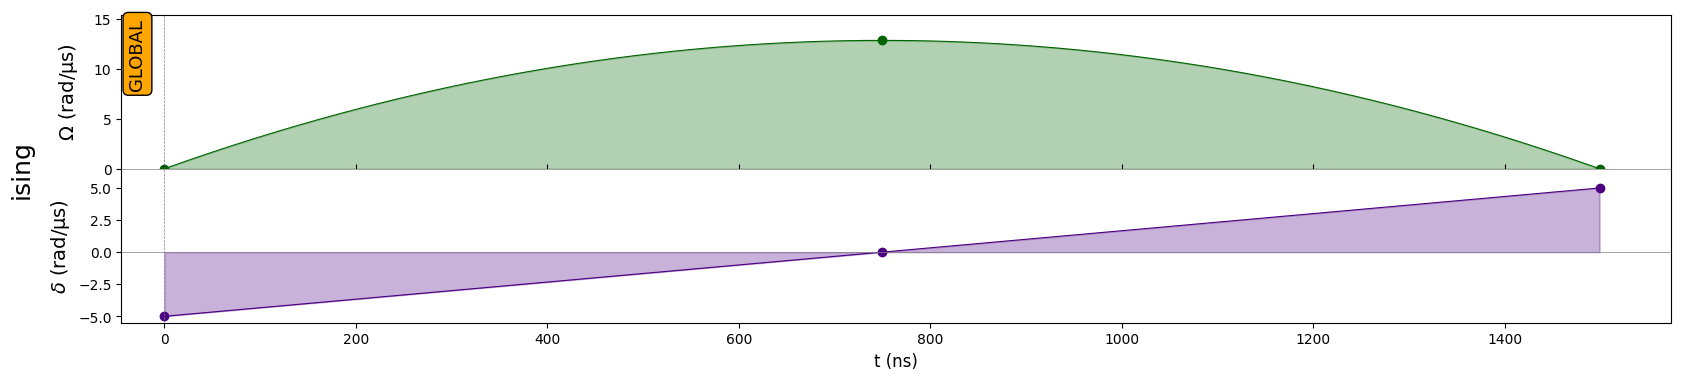

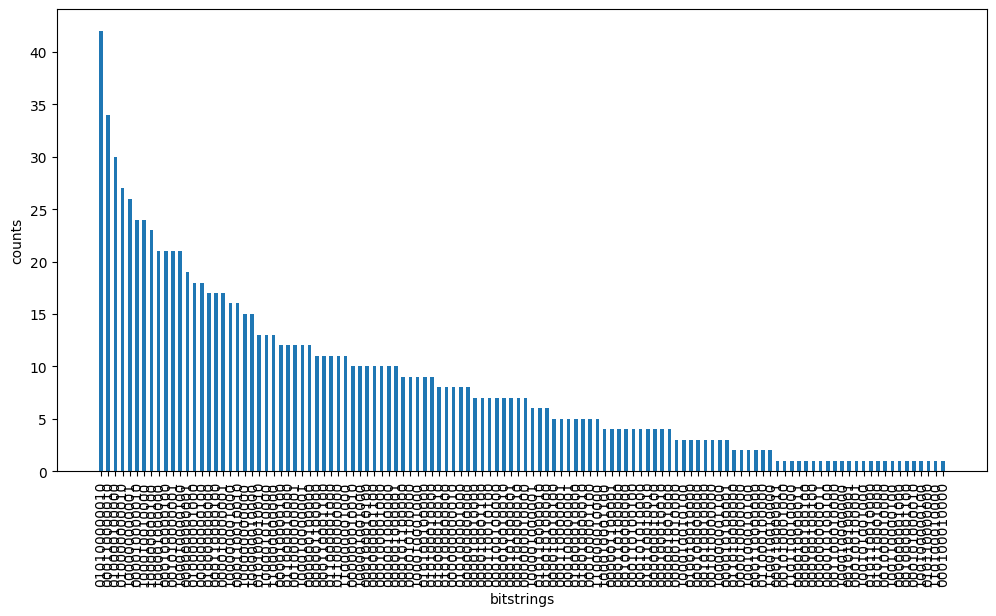

energy : -15.387593650183236


In [101]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 1500  # time in ns, we choose a time long enough to ensure the propagation of information in the system
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
cat_reg = Register({
  "q0": (-7.7, 0.5499999999999998),
  "q1": (8, 0.050000000000000266),
  "q2": (-4.1, 3.95),
  "q3": (-9.458268072574153, 9.22721873997051),
  "q4": (7.58589838486222, 9.200000000000001),
  "q5": (2.8, 3.7),
  "q6": (-5.439395879923375, -5.563895666164335),
  "q7": (0.8643526930765201, -9.360368260903469),
  "q8": (-3.124201217263207, -9.057981580783999),
  "q9": (2.140588244946235, -1.2385929437159227),
  "q10": (-3.321604204511879, -1.2352898106591148),
  "q11": (3.1860873721652885, -6.103138137022662),
})
cat_reg.draw()
Q_cat = coordinates_to_Q([[-7.7, 0.5499999999999998], [8, 0.050000000000000266], [-4.1, 3.95], [-9.458268072574153, 9.22721873997051], [7.58589838486222, 9.200000000000001], [2.8, 3.7], [-5.439395879923375, -5.563895666164335], [0.8643526930765201, -9.360368260903469], [-3.124201217263207, -9.057981580783999], [2.140588244946235, -1.2385929437159227], [-3.321604204511879, -1.2352898106591148], [3.1860873721652885, -6.103138137022662]])
sequence_QAA_cat = Sequence(cat_reg, DigitalAnalogDevice)
sequence_QAA_cat.declare_channel("ising", "rydberg_global")
sequence_QAA_cat.add(adiabatic_pulse, "ising")
sequence_QAA_cat.draw()
simul_QAA = QutipEmulator.from_sequence(sequence_QAA_cat)
results_QAA = simul_QAA.run()
final_QAA = results_QAA.get_final_state()
count_dict_QAA = results_QAA.sample_final_state()
plot_distribution(count_dict_QAA)
print(f"energy : {get_cost(count_dict_QAA, Q_cat)}")

In [103]:
s_readable = sequence_QAA_cat.to_abstract_repr(
json_dumps_options={"indent": 1},
seq_name=f"cat_qaa_seq_{time.time()}",
)
with open(f"cat_QAA_{time.time()}.json", "w") as f:
    f.write(s_readable)

# Section to check how well your Pulser Studio bitstring compares to the best possible result

In [113]:
def rank_bitstring(bitstring, sorted_results):
    for idx, (b, _) in enumerate(sorted_results):
        if b == bitstring:
            print(f"Got the {idx + 1}ᵗʰ best result out of {len(sorted_results)} best is {sorted_results[0]}")
            break
    else:
        print(f"Bitstring {bitstring} not found.")

result_Q = find_minimum_cost_classic(Q)
print("QAOA pascal triangle:")
rank_bitstring("100000000000",result_Q)

result_Q = find_minimum_cost_classic(Q)
print("QAA pascal triangle:")
rank_bitstring("100000000110",result_Q)

result_Q_cat = find_minimum_cost_classic(Q_cat)
print("QAA cat:")
rank_bitstring("010100000010",result_Q_cat)

result_Q_flower = find_minimum_cost_classic(Q_flower)
print("QAA flower:")
rank_bitstring("000000000011",result_Q_flower)

QAOA pascal triangle:
Got the 49ᵗʰ best result out of 4096 best is ('100000100100', -27.14493707061728)
QAA pascal triangle:
Got the 2ᵗʰ best result out of 4096 best is ('100000100100', -27.14493707061728)
QAA cat:
Got the 22ᵗʰ best result out of 4096 best is ('000110010000', -29.257273447253795)
QAA flower:
Got the 6ᵗʰ best result out of 4096 best is ('000100000011', -21.02253157240184)
